# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

In [1]:
# # Be sure to install the latest version of RLlib and sundry requirements
# ! pip install -U ray[rllib]
# ! pip install requests pandas aiohttp psutil setproctitle grpcio tensorflow-gpu==1.14.0

In [1]:
# view dependencies
! pip list | grep tensorflow

tensorflow             1.14.0             
tensorflow-estimator   1.14.0             
tensorflow-gpu         1.14.0             


Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ten

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [3]:
# Start ray locally (there are lots of configurations)
# to remote access ray dashboard, use ssh -L 8888:localhost:8265 local_host@xxx.xxx.xxx.xx
# on local: http://localhost:8888
ray.init(num_cpus=8, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

2020-03-11 17:14:11,686	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-11 17:14:11,687	INFO resource_spec.py:212 -- Starting Ray with 7.76 GiB memory available for workers and up to 3.9 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-11 17:14:12,016	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.236.176.76',
 'redis_address': '10.236.176.76:17658',
 'object_store_address': '/tmp/ray/session_2020-03-11_17-14-11_684300_31093/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-11_17-14-11_684300_31093/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-11_17-14-11_684300_31093'}

## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [5]:
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
print(config)

{'num_workers': 2, 'num_envs_per_worker': 1, 'sample_batch_size': 200, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 4000, 'model': {'conv_filters': None, 'conv_activation': 'relu', 'fcnet_activation': 'tanh', 'fcnet_hiddens': [256, 256], 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, 'state_shape': None, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_preprocessor': None, 'custom_model': None, 'custom_action_dist': None, 'custom_options': {}}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 5e-05, 'monitor': False, 'log_level': 'WARN', 'callbacks': {'on_episode_start': None, 'on_episode_step': None, 'on_episode_end': Non

In [6]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(config, 'Pong-ram-v0')


2020-03-10 17:31:16,624	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-10 17:31:16,627	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
for i in range(2):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-03-10_17-31-24
done: false
episode_len_mean: 1248.0
episode_reward_max: -20.0
episode_reward_mean: -20.333333333333332
episode_reward_min: -21.0
episodes_this_iter: 3
episodes_total: 3
experiment_id: 6507435c45c14468bd2b319ebfaaf302
hostname: qian-XPS-8920
info:
  grad_time_ms: 1305.772
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 1.7822446823120117
      entropy_coeff: 0.0
      kl: 0.009407696314156055
      policy_loss: -0.0038971842732280493
      total_loss: 0.4376855790615082
      vf_explained_var: 0.0065327961929142475
      vf_loss: 0.43970122933387756
  load_time_ms: 52.684
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 4162.778
  update_time_ms: 357.342
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 32.37777777777777
  gpu_util_percent0: 0.030000000000000002
  ram_util_p

In [7]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [8]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.sample())

Box(4,)
Discrete(2)
[-4.0115070e-02 -2.7820475e+38 -3.5773429e-01  2.6301286e+37]


In [17]:
# compute some observation, then ask the agent to compute an action
obs = env.observation_space.sample()
agent.compute_action(obs)

1

### EXERCISE:
Train the agent and try to get a reward of 200. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

This should take around 20 or 30 training iterations.

In [18]:
# build out a new config and trainer
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-23 17:48:03,561	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [19]:
## Train for a while
for i in range(20):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-23_17-48-20
done: false
episode_len_mean: 22.885057471264368
episode_reward_max: 83.0
episode_reward_mean: 22.885057471264368
episode_reward_min: 8.0
episodes_this_iter: 174
episodes_total: 174
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 1035.934
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6627660393714905
      entropy_coeff: 0.0
      kl: 0.030408170074224472
      policy_loss: -0.04281337186694145
      total_loss: 190.5047607421875
      vf_explained_var: 0.018993224948644638
      vf_loss: 190.54150390625
  load_time_ms: 37.091
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 821.954
  update_time_ms: 308.361
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 10.908333333333333
  ram_util_percent: 72.46666666666668
pid: 30552
p

custom_metrics: {}
date: 2020-02-23_17-48-29
done: false
episode_len_mean: 162.28
episode_reward_max: 200.0
episode_reward_mean: 162.28
episode_reward_min: 15.0
episodes_this_iter: 22
episodes_total: 413
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 852.671
  learner:
    default_policy:
      cur_kl_coeff: 0.07500000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.5493625402450562
      entropy_coeff: 0.0
      kl: 0.0024292394518852234
      policy_loss: -0.004398831631988287
      total_loss: 595.1405029296875
      vf_explained_var: 0.3493116796016693
      vf_loss: 595.1447143554688
  load_time_ms: 6.063
  num_steps_sampled: 28000
  num_steps_trained: 27776
  sample_time_ms: 766.55
  update_time_ms: 45.766
iterations_since_restore: 7
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 40.7
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward_mean: {}
policy

custom_metrics: {}
date: 2020-02-23_17-48-39
done: false
episode_len_mean: 187.5
episode_reward_max: 200.0
episode_reward_mean: 187.5
episode_reward_min: 22.0
episodes_this_iter: 23
episodes_total: 542
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 823.776
  learner:
    default_policy:
      cur_kl_coeff: 0.004687500186264515
      cur_lr: 4.999999873689376e-05
      entropy: 0.5304279923439026
      entropy_coeff: 0.0
      kl: 0.007987464778125286
      policy_loss: -0.0023089575115591288
      total_loss: 292.8392028808594
      vf_explained_var: 0.5363507270812988
      vf_loss: 292.8414611816406
  load_time_ms: 0.891
  num_steps_sampled: 52000
  num_steps_trained: 51584
  sample_time_ms: 742.016
  update_time_ms: 1.954
iterations_since_restore: 13
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 43.65
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward_mean: {}
polic

custom_metrics: {}
date: 2020-02-23_17-48-49
done: false
episode_len_mean: 198.06
episode_reward_max: 200.0
episode_reward_mean: 198.06
episode_reward_min: 60.0
episodes_this_iter: 20
episodes_total: 662
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 866.448
  learner:
    default_policy:
      cur_kl_coeff: 0.004687500186264515
      cur_lr: 4.999999873689376e-05
      entropy: 0.5659090280532837
      entropy_coeff: 0.0
      kl: 0.005861836951225996
      policy_loss: -0.0025119411293417215
      total_loss: 261.8939208984375
      vf_explained_var: 0.5556763410568237
      vf_loss: 261.8963623046875
  load_time_ms: 0.931
  num_steps_sampled: 76000
  num_steps_trained: 75392
  sample_time_ms: 787.942
  update_time_ms: 2.274
iterations_since_restore: 19
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 54.099999999999994
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward

In [20]:
## Save the agent off (this may become sticky depending which agent you've used)
checkpoint_path = agent.save()
print(checkpoint_path)

/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0/checkpoint_20/checkpoint-20


In [21]:
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
test_agent = PPOTrainer(trained_config, 'CartPole-v0')
test_agent.restore(checkpoint_path) 

/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-23 17:50:02,001	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-23 17:50:02,060	WARNING trainable.py:210 -- Getting current IP.
2020-02-23 17:50:02,061	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0/checkpoint_20/checkpoint-20
2020-02-23 17:50:02,061	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 80000, '_time_total': 33.20142102241516, '_episodes_total': 683}


### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [24]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [25]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

     |████████████████████████████████| 13.1 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 1.4 MB/s eta 0:00:0101


In [40]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0")

In [41]:
df = analysis.dataframe() # last trial from checkpoint

In [43]:
df_trials = analysis.trial_dataframes['/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0']

<IPython.core.display.Javascript object>


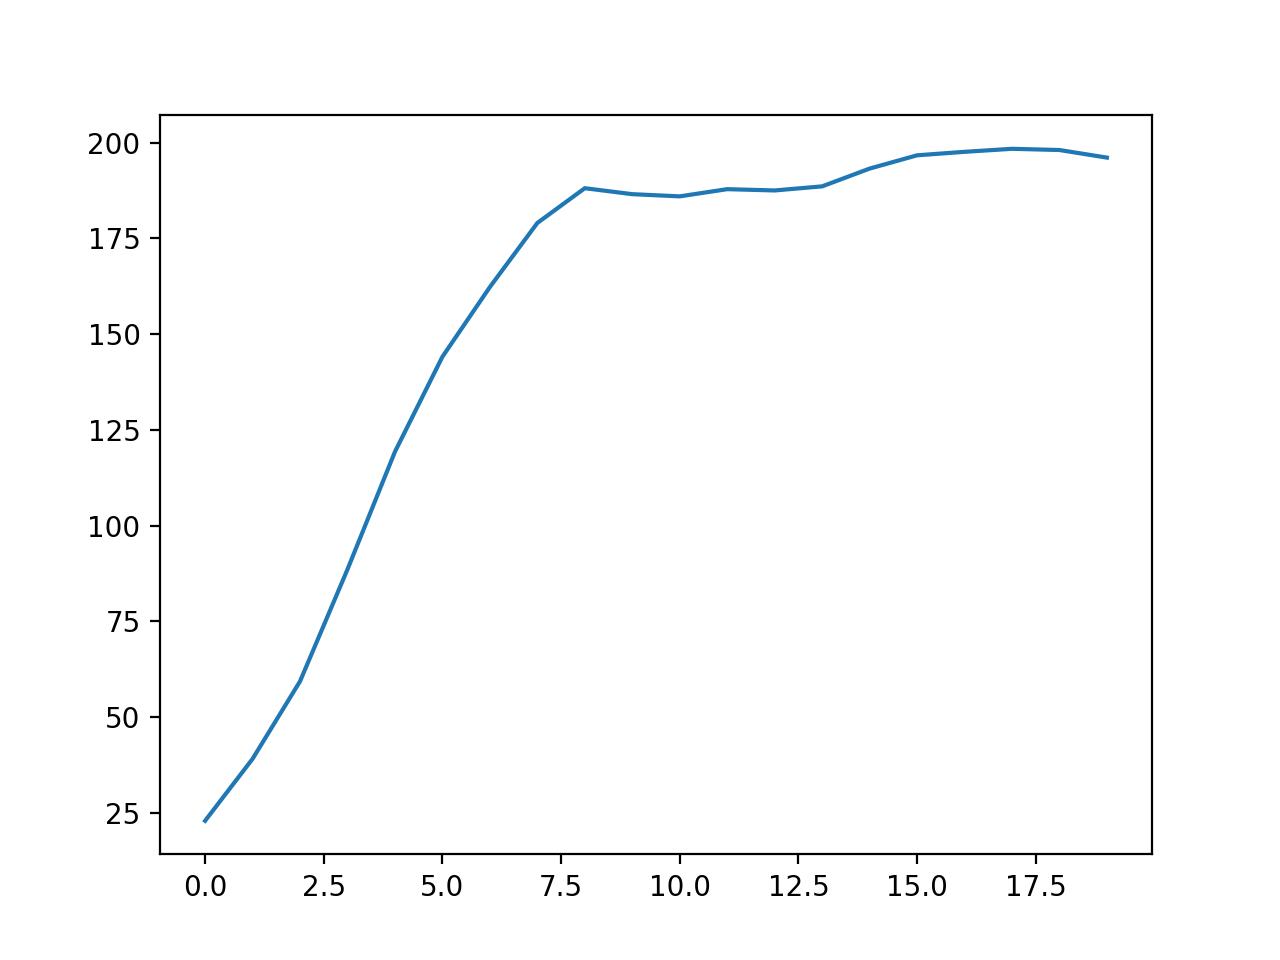

In [44]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [45]:
! pip install tensorboard

In [46]:
! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


### More details on tune
* https://github.com/ray-project/ray/tree/master/rllib/tuned_examples list essentially yaml that can be used with the command line interface for tune
* we will use tune to run of the a3c examples (this is a cpu only regression test)

In [1]:
# ! pip install pyyaml # install package to read yamls, import with yaml

In [4]:
import yaml
import urllib

In [20]:
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/ray/master/rllib/tuned_examples/pong-ppo.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# On a single GPU, this achieves maximum reward in ~15-20 minutes.\n#\n# $ python train.py -f tuned_examples/pong-ppo.yaml\n#\npong-ppo:\n    env: PongNoFrameskip-v4\n    run: PPO\n    config:\n        lambda: 0.95\n        kl_coeff: 0.5\n        clip_rewards: True\n        clip_param: 0.1\n        vf_clip_param: 10.0\n        entropy_coeff: 0.01\n        train_batch_size: 5000\n        sample_batch_size: 20\n        sgd_minibatch_size: 500\n        num_sgd_iter: 10\n        num_workers: 32\n        num_envs_per_worker: 5\n        batch_mode: truncate_episodes\n        observation_filter: NoFilter\n        vf_share_layers: true\n        num_gpus: 1\n        model:\n            dim: 42\n'


In [21]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)

{'pong-ppo': {'env': 'PongNoFrameskip-v4', 'run': 'PPO', 'config': {'lambda': 0.95, 'kl_coeff': 0.5, 'clip_rewards': True, 'clip_param': 0.1, 'vf_clip_param': 10.0, 'entropy_coeff': 0.01, 'train_batch_size': 5000, 'sample_batch_size': 20, 'sgd_minibatch_size': 500, 'num_sgd_iter': 10, 'num_workers': 32, 'num_envs_per_worker': 5, 'batch_mode': 'truncate_episodes', 'observation_filter': 'NoFilter', 'vf_share_layers': True, 'num_gpus': 1, 'model': {'dim': 42}}}}


In [22]:
tune_config_example["pong-ppo"]["config"]["num_workers"] = 7
tune_config_example["pong-ppo"]["config"]["num_gpus"]=1
tune_config_example["pong-ppo"]["config"]["train_batch_size"]=1000
tune_config_example["pong-ppo"]["config"]["sample_batch_size"]=50
# tune_config_example["pong-ppo"]["config"]["broadcast_interval"]=5
# tune_config_example["pong-ppo"]["config"]["max_sample_requests_in_flight_per_worker"]=1
# tune_config_example["pong-ppo"]["config"]["num_data_loader_buffers"]=4

print(tune_config_example)

{'pong-ppo': {'env': 'PongNoFrameskip-v4', 'run': 'PPO', 'config': {'lambda': 0.95, 'kl_coeff': 0.5, 'clip_rewards': True, 'clip_param': 0.1, 'vf_clip_param': 10.0, 'entropy_coeff': 0.01, 'train_batch_size': 1000, 'sample_batch_size': 50, 'sgd_minibatch_size': 500, 'num_sgd_iter': 10, 'num_workers': 7, 'num_envs_per_worker': 5, 'batch_mode': 'truncate_episodes', 'observation_filter': 'NoFilter', 'vf_share_layers': True, 'num_gpus': 1, 'model': {'dim': 42}}}}


In [ ]:
ray.tune.run_experiments(tune_config_example)

Trial name,status,loc
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-26
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1710.657
    learner:
      default_policy:
        cur_kl_coeff: 0.5
        cur_lr: 4.999999873689376e-05
        entropy: 5.225667791819433e-06
        entropy_coeff: 0.009999999776482582
        kl: 6.614026005991036e-06
        policy_loss: 0.0005572897498495877
        total_loss: 0.0016704673180356622
        vf_explained_var: -0.5306113958358765
        vf_loss: 0.001109920791350305
    load_time_ms: 119.957
    num_steps_sampled: 1750
    num_steps_trained: 1500
    sample_time_ms: 2552.905
    update_time_ms: 487.199
  iterations_since_restore: 1
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,nan,4.90388,1750,1


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-31
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1261.138
    learner:
      default_policy:
        cur_kl_coeff: 0.0625
        cur_lr: 4.999999873689376e-05
        entropy: 6.579217171065466e-08
        entropy_coeff: 0.009999999776482582
        kl: 0.004822791088372469
        policy_loss: 0.01988389901816845
        total_loss: 0.13049158453941345
        vf_explained_var: 0.010139386169612408
        vf_loss: 0.1103062629699707
    load_time_ms: 53.739
    num_steps_sampled: 7000
    num_steps_trained: 6000
    sample_time_ms: 1033.079
    update_time_ms: 125.564
  iterations_since_restore: 4
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_pol

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,nan,9.93793,7000,4


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-36
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1196.879
    learner:
      default_policy:
        cur_kl_coeff: 0.0078125
        cur_lr: 4.999999873689376e-05
        entropy: 4.213288207211008e-08
        entropy_coeff: 0.009999999776482582
        kl: 5.786943702013048e-10
        policy_loss: 0.0029708866495639086
        total_loss: 0.09690964221954346
        vf_explained_var: 0.03329779580235481
        vf_loss: 0.09393876045942307
    load_time_ms: 44.184
    num_steps_sampled: 12250
    num_steps_trained: 10500
    sample_time_ms: 814.854
    update_time_ms: 73.767
  iterations_since_restore: 7
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,nan,14.9635,12250,7


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-41
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1171.35
    learner:
      default_policy:
        cur_kl_coeff: 0.0009765625
        cur_lr: 4.999999873689376e-05
        entropy: 4.096826344834881e-08
        entropy_coeff: 0.009999999776482582
        kl: -6.840669003471689e-11
        policy_loss: 0.011212031356990337
        total_loss: 0.07845918089151382
        vf_explained_var: 0.07414903491735458
        vf_loss: 0.06724715232849121
    load_time_ms: 40.42
    num_steps_sampled: 17500
    num_steps_trained: 15000
    sample_time_ms: 727.93
    update_time_ms: 53.029
  iterations_since_restore: 10
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,nan,19.994,17500,10


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-46
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1111.712
    learner:
      default_policy:
        cur_kl_coeff: 0.0001220703125
        cur_lr: 4.999999873689376e-05
        entropy: 1.3710935320432327e-07
        entropy_coeff: 0.009999999776482582
        kl: -2.4326161085497233e-09
        policy_loss: -0.0063781775534152985
        total_loss: 0.07364005595445633
        vf_explained_var: 0.12834781408309937
        vf_loss: 0.08001822978258133
    load_time_ms: 31.49
    num_steps_sampled: 22750
    num_steps_trained: 19500
    sample_time_ms: 526.699
    update_time_ms: 4.583
  iterations_since_restore: 13
  node_ip: 10.236.176.76
  num_healthy_worke

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,nan,25.0384,22750,13


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-51
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 28
  episodes_total: 28
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1112.652
    learner:
      default_policy:
        cur_kl_coeff: 1.52587890625e-05
        cur_lr: 4.999999873689376e-05
        entropy: 0.0007809018134139478
        entropy_coeff: 0.009999999776482582
        kl: 7.422230555675924e-05
        policy_loss: 0.006876353640109301
        total_loss: 0.11111544817686081
        vf_explained_var: 0.0032506585121154785
        vf_loss: 0.10424690693616867
    load_time_ms: 31.407
    num_steps_sampled: 28000
    num_steps_trained: 24000
    sample_time_ms: 536.199
    update_time_ms: 4.692
  iterations_since_restore: 16
  node_ip: 10.236.176.76
  num_health

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,30.1675,28000,16


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-16-56
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1113.032
    learner:
      default_policy:
        cur_kl_coeff: 5.7220458984375e-06
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: 0.010688099078834057
        total_loss: 0.08213246613740921
        vf_explained_var: 0.07554282993078232
        vf_loss: 0.07144436985254288
    load_time_ms: 31.401
    num_steps_sampled: 33250
    num_steps_trained: 28500
    sample_time_ms: 536.728
    update_time_ms: 4.747
  iterations_since_restore: 19
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimator: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,35.2132,33250,19


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-01
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1113.982
    learner:
      default_policy:
        cur_kl_coeff: 7.152557373046875e-07
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: -0.01748736761510372
        total_loss: 0.07933910936117172
        vf_explained_var: 0.10647740215063095
        vf_loss: 0.09682647138834
    load_time_ms: 31.407
    num_steps_sampled: 38500
    num_steps_trained: 33000
    sample_time_ms: 536.857
    update_time_ms: 4.822
  iterations_since_restore: 22
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimator: {

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,40.2533,38500,22


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-06
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1114.196
    learner:
      default_policy:
        cur_kl_coeff: 8.940696716308594e-08
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: -0.00010485202074050903
        total_loss: 0.07819205522537231
        vf_explained_var: 0.15952835977077484
        vf_loss: 0.07829690724611282
    load_time_ms: 31.417
    num_steps_sampled: 43750
    num_steps_trained: 37500
    sample_time_ms: 535.884
    update_time_ms: 4.726
  iterations_since_restore: 25
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estima

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,45.2997,43750,25


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-11
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1114.296
    learner:
      default_policy:
        cur_kl_coeff: 1.1175870895385742e-08
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: -0.01562563329935074
        total_loss: 0.036754440516233444
        vf_explained_var: 0.2632924020290375
        vf_loss: 0.05238007381558418
    load_time_ms: 31.35
    num_steps_sampled: 49000
    num_steps_trained: 42000
    sample_time_ms: 527.136
    update_time_ms: 4.777
  iterations_since_restore: 28
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimator

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,50.3469,49000,28


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-16
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 63
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1114.024
    learner:
      default_policy:
        cur_kl_coeff: 1.3969838619232178e-09
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: 0.006083893124014139
        total_loss: 0.21448999643325806
        vf_explained_var: 0.023953119292855263
        vf_loss: 0.20840609073638916
    load_time_ms: 31.326
    num_steps_sampled: 54250
    num_steps_trained: 46500
    sample_time_ms: 534.865
    update_time_ms: 4.789
  iterations_since_restore: 31
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estima

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,55.4643,54250,31


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-21
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 63
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1113.584
    learner:
      default_policy:
        cur_kl_coeff: 1.7462298274040222e-10
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: 0.01332391519099474
        total_loss: 0.07946540415287018
        vf_explained_var: 0.10352275520563126
        vf_loss: 0.06614147871732712
    load_time_ms: 31.312
    num_steps_sampled: 59500
    num_steps_trained: 51000
    sample_time_ms: 535.87
    update_time_ms: 4.862
  iterations_since_restore: 34
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimator:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,60.5046,59500,34


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-27
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 63
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1113.333
    learner:
      default_policy:
        cur_kl_coeff: 2.1827872842550278e-11
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: 0.005877356510609388
        total_loss: 0.07463929802179337
        vf_explained_var: 0.09111890941858292
        vf_loss: 0.06876194477081299
    load_time_ms: 31.366
    num_steps_sampled: 64750
    num_steps_trained: 55500
    sample_time_ms: 535.283
    update_time_ms: 5.092
  iterations_since_restore: 37
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimato

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,65.5594,64750,37


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-32
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 63
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1113.586
    learner:
      default_policy:
        cur_kl_coeff: 2.7284841053187847e-12
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: -0.011035571806132793
        total_loss: 0.08371482044458389
        vf_explained_var: 0.16678492724895477
        vf_loss: 0.09475039690732956
    load_time_ms: 31.409
    num_steps_sampled: 70000
    num_steps_trained: 60000
    sample_time_ms: 534.682
    update_time_ms: 5.101
  iterations_since_restore: 40
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimat

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,70.5889,70000,40


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-37
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 63
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1113.955
    learner:
      default_policy:
        cur_kl_coeff: 3.410605131648481e-13
        cur_lr: 4.999999873689376e-05
        entropy: 0.0
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: 0.005060069262981415
        total_loss: 0.0737733468413353
        vf_explained_var: 0.23412321507930756
        vf_loss: 0.06871327012777328
    load_time_ms: 31.432
    num_steps_sampled: 75250
    num_steps_trained: 64500
    sample_time_ms: 525.778
    update_time_ms: 5.775
  iterations_since_restore: 43
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_policy_estimator:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,75.6324,75250,43


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-42
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 98
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1114.676
    learner:
      default_policy:
        cur_kl_coeff: 4.263256414560601e-14
        cur_lr: 4.999999873689376e-05
        entropy: 1.6410675494382738e-32
        entropy_coeff: 0.009999999776482582
        kl: 0.0
        policy_loss: -0.004332667216658592
        total_loss: 0.25764620304107666
        vf_explained_var: 0.05029614642262459
        vf_loss: 0.2619788646697998
    load_time_ms: 31.477
    num_steps_sampled: 80500
    num_steps_trained: 69000
    sample_time_ms: 531.715
    update_time_ms: 5.924
  iterations_since_restore: 46
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,80.7519,80500,46


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-47
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 98
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1114.693
    learner:
      default_policy:
        cur_kl_coeff: 5.329070518200751e-15
        cur_lr: 4.999999873689376e-05
        entropy: 7.241441471231213e-34
        entropy_coeff: 0.009999999776482582
        kl: 5.091830563916842e-35
        policy_loss: 0.00021705155086237937
        total_loss: 0.09266617149114609
        vf_explained_var: 0.08485424518585205
        vf_loss: 0.09244910627603531
    load_time_ms: 31.281
    num_steps_sampled: 85750
    num_steps_trained: 73500
    sample_time_ms: 532.839
    update_time_ms: 5.572
  iterations_since_restore: 49
  node_ip: 10.236.176.76
  num_hea

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,85.7907,85750,49


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-52
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 98
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1115.336
    learner:
      default_policy:
        cur_kl_coeff: 6.661338147750939e-16
        cur_lr: 4.999999873689376e-05
        entropy: 8.850459975346683e-35
        entropy_coeff: 0.009999999776482582
        kl: -3.626846514767103e-37
        policy_loss: -0.009951659478247166
        total_loss: 0.049952078610658646
        vf_explained_var: 0.13401643931865692
        vf_loss: 0.05990372970700264
    load_time_ms: 31.356
    num_steps_sampled: 91000
    num_steps_trained: 78000
    sample_time_ms: 532.634
    update_time_ms: 5.183
  iterations_since_restore: 52
  node_ip: 10.236.176.76
  num_he

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,90.8328,91000,52


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-17-57
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 98
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.404
    learner:
      default_policy:
        cur_kl_coeff: 8.326672684688674e-17
        cur_lr: 4.999999873689376e-05
        entropy: 1.2357416505442953e-33
        entropy_coeff: 0.009999999776482582
        kl: -5.594444440727494e-36
        policy_loss: -0.017603350803256035
        total_loss: 0.0461360402405262
        vf_explained_var: 0.23921336233615875
        vf_loss: 0.06373939663171768
    load_time_ms: 31.386
    num_steps_sampled: 96250
    num_steps_trained: 82500
    sample_time_ms: 533.423
    update_time_ms: 4.672
  iterations_since_restore: 55
  node_ip: 10.236.176.76
  num_hea

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,95.8929,96250,55


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-02
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 98
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.635
    learner:
      default_policy:
        cur_kl_coeff: 1.0408340855860843e-17
        cur_lr: 4.999999873689376e-05
        entropy: 9.194410999929727e-34
        entropy_coeff: 0.009999999776482582
        kl: 7.147138240497086e-35
        policy_loss: -0.0171074029058218
        total_loss: 0.06586647778749466
        vf_explained_var: 0.27533453702926636
        vf_loss: 0.08297387510538101
    load_time_ms: 31.411
    num_steps_sampled: 101500
    num_steps_trained: 87000
    sample_time_ms: 525.727
    update_time_ms: 4.637
  iterations_since_restore: 58
  node_ip: 10.236.176.76
  num_heal

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,100.933,101500,58


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-07
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 133
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.875
    learner:
      default_policy:
        cur_kl_coeff: 1.3010426069826053e-18
        cur_lr: 4.999999873689376e-05
        entropy: 3.8502967558833584e-28
        entropy_coeff: 0.009999999776482582
        kl: -2.320262197669042e-33
        policy_loss: -0.005551833193749189
        total_loss: 0.2466367483139038
        vf_explained_var: 0.049635231494903564
        vf_loss: 0.2521885633468628
    load_time_ms: 31.321
    num_steps_sampled: 106750
    num_steps_trained: 91500
    sample_time_ms: 535.526
    update_time_ms: 4.723
  iterations_since_restore: 61
  node_ip: 10.236.176.76
  num

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,106.078,106750,61


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-12
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 133
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.556
    learner:
      default_policy:
        cur_kl_coeff: 1.6263032587282567e-19
        cur_lr: 4.999999873689376e-05
        entropy: 1.1282726550717892e-29
        entropy_coeff: 0.009999999776482582
        kl: 2.0586180539961905e-30
        policy_loss: -0.004042146261781454
        total_loss: 0.09668347984552383
        vf_explained_var: 0.10415349155664444
        vf_loss: 0.10072562843561172
    load_time_ms: 31.351
    num_steps_sampled: 112000
    num_steps_trained: 96000
    sample_time_ms: 534.56
    update_time_ms: 4.679
  iterations_since_restore: 64
  node_ip: 10.236.176.76
  num_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,111.113,112000,64


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-17
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 133
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.28
    learner:
      default_policy:
        cur_kl_coeff: 2.0328790734103208e-20
        cur_lr: 4.999999873689376e-05
        entropy: 5.688188575606437e-30
        entropy_coeff: 0.009999999776482582
        kl: 6.378799523586004e-32
        policy_loss: -0.000388643384212628
        total_loss: 0.08229350298643112
        vf_explained_var: 0.12996067106723785
        vf_loss: 0.08268214017152786
    load_time_ms: 31.371
    num_steps_sampled: 117250
    num_steps_trained: 100500
    sample_time_ms: 534.513
    update_time_ms: 4.715
  iterations_since_restore: 67
  node_ip: 10.236.176.76
  num_h

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,116.162,117250,67


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-22
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 133
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.044
    learner:
      default_policy:
        cur_kl_coeff: 2.541098841762901e-21
        cur_lr: 4.999999873689376e-05
        entropy: 3.4345701523568584e-29
        entropy_coeff: 0.009999999776482582
        kl: -1.384988603037134e-31
        policy_loss: 0.004992692265659571
        total_loss: 0.06041594222187996
        vf_explained_var: 0.23008102178573608
        vf_loss: 0.05542324110865593
    load_time_ms: 31.293
    num_steps_sampled: 122500
    num_steps_trained: 105000
    sample_time_ms: 535.463
    update_time_ms: 4.589
  iterations_since_restore: 70
  node_ip: 10.236.176.76
  num_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,121.226,122500,70


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-28
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 133
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.342
    learner:
      default_policy:
        cur_kl_coeff: 3.1763735522036263e-22
        cur_lr: 4.999999873689376e-05
        entropy: 4.175540402098251e-29
        entropy_coeff: 0.009999999776482582
        kl: -1.6796610567035246e-31
        policy_loss: -0.0002928950416389853
        total_loss: 0.06857680529356003
        vf_explained_var: 0.28134986758232117
        vf_loss: 0.0688697025179863
    load_time_ms: 31.251
    num_steps_sampled: 127750
    num_steps_trained: 109500
    sample_time_ms: 527.611
    update_time_ms: 4.638
  iterations_since_restore: 73
  node_ip: 10.236.176.76
  nu

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,126.273,127750,73


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-33
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 34
  episodes_total: 167
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.472
    learner:
      default_policy:
        cur_kl_coeff: 3.970466940254533e-23
        cur_lr: 4.999999873689376e-05
        entropy: 9.662653098412684e-23
        entropy_coeff: 0.009999999776482582
        kl: -2.409049470936774e-28
        policy_loss: 0.00973797682672739
        total_loss: 0.283549040555954
        vf_explained_var: 0.09408219903707504
        vf_loss: 0.27381107211112976
    load_time_ms: 31.214
    num_steps_sampled: 133000
    num_steps_trained: 114000
    sample_time_ms: 535.949
    update_time_ms: 4.662
  iterations_since_restore: 76
  node_ip: 10.236.176.76
  num_hea

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,131.403,133000,76


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-38
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 168
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.288
    learner:
      default_policy:
        cur_kl_coeff: 4.963083675318166e-24
        cur_lr: 4.999999873689376e-05
        entropy: 3.2570599495291866e-23
        entropy_coeff: 0.009999999776482582
        kl: 2.938109236748231e-25
        policy_loss: 0.0150498291477561
        total_loss: 0.07586956769227982
        vf_explained_var: 0.2580406069755554
        vf_loss: 0.06081973388791084
    load_time_ms: 31.291
    num_steps_sampled: 138250
    num_steps_trained: 118500
    sample_time_ms: 534.797
    update_time_ms: 4.842
  iterations_since_restore: 79
  node_ip: 10.236.176.76
  num_heal

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,136.455,138250,79


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-43
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 168
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.168
    learner:
      default_policy:
        cur_kl_coeff: 6.203854594147708e-25
        cur_lr: 4.999999873689376e-05
        entropy: 1.4346254990709398e-24
        entropy_coeff: 0.009999999776482582
        kl: 3.8275760384024073e-25
        policy_loss: -0.0137148043140769
        total_loss: 0.06494297087192535
        vf_explained_var: 0.2935190200805664
        vf_loss: 0.07865776866674423
    load_time_ms: 31.207
    num_steps_sampled: 143500
    num_steps_trained: 123000
    sample_time_ms: 534.453
    update_time_ms: 4.919
  iterations_since_restore: 82
  node_ip: 10.236.176.76
  num_he

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,141.501,143500,82


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-48
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 168
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.791
    learner:
      default_policy:
        cur_kl_coeff: 7.754818242684634e-26
        cur_lr: 4.999999873689376e-05
        entropy: 6.574130125840346e-24
        entropy_coeff: 0.009999999776482582
        kl: -3.3963358568400917e-26
        policy_loss: 0.006566253956407309
        total_loss: 0.07244236022233963
        vf_explained_var: 0.32997044920921326
        vf_loss: 0.06587610393762589
    load_time_ms: 31.507
    num_steps_sampled: 148750
    num_steps_trained: 127500
    sample_time_ms: 534.593
    update_time_ms: 4.872
  iterations_since_restore: 85
  node_ip: 10.236.176.76
  num_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,146.558,148750,85


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-53
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 168
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.497
    learner:
      default_policy:
        cur_kl_coeff: 9.693522803355793e-27
        cur_lr: 4.999999873689376e-05
        entropy: 5.341911721400849e-23
        entropy_coeff: 0.009999999776482582
        kl: -3.2484071807788502e-25
        policy_loss: -0.016139036044478416
        total_loss: 0.029070043936371803
        vf_explained_var: 0.3982725143432617
        vf_loss: 0.04520907998085022
    load_time_ms: 31.466
    num_steps_sampled: 154000
    num_steps_trained: 132000
    sample_time_ms: 527.521
    update_time_ms: 4.793
  iterations_since_restore: 88
  node_ip: 10.236.176.76
  num

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,151.614,154000,88


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-18-58
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 16
  episodes_total: 184
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.278
    learner:
      default_policy:
        cur_kl_coeff: 1.2116903504194741e-27
        cur_lr: 4.999999873689376e-05
        entropy: 1.5087721381709233e-19
        entropy_coeff: 0.009999999776482582
        kl: -1.532735755144347e-23
        policy_loss: -0.013106665574014187
        total_loss: 0.23936033248901367
        vf_explained_var: 0.13047398626804352
        vf_loss: 0.25246697664260864
    load_time_ms: 31.499
    num_steps_sampled: 159250
    num_steps_trained: 136500
    sample_time_ms: 533.444
    update_time_ms: 4.786
  iterations_since_restore: 91
  node_ip: 10.236.176.76
  n

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,156.725,159250,91


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-03
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 203
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.653
    learner:
      default_policy:
        cur_kl_coeff: 1.5146129380243427e-28
        cur_lr: 4.999999873689376e-05
        entropy: 3.205164400604147e-18
        entropy_coeff: 0.009999999776482582
        kl: 7.469446618220551e-19
        policy_loss: 0.00322076678276062
        total_loss: 0.051757436245679855
        vf_explained_var: 0.3704892098903656
        vf_loss: 0.048536669462919235
    load_time_ms: 31.245
    num_steps_sampled: 164500
    num_steps_trained: 141000
    sample_time_ms: 538.728
    update_time_ms: 4.706
  iterations_since_restore: 94
  node_ip: 10.236.176.76
  num_h

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,161.823,164500,94


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-08
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 203
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1115.969
    learner:
      default_policy:
        cur_kl_coeff: 1.8932661725304283e-29
        cur_lr: 4.999999873689376e-05
        entropy: 5.362441305179939e-19
        entropy_coeff: 0.009999999776482582
        kl: -5.117633264901232e-22
        policy_loss: 0.0003753121418412775
        total_loss: 0.046309083700180054
        vf_explained_var: 0.4646778404712677
        vf_loss: 0.04593377187848091
    load_time_ms: 31.41
    num_steps_sampled: 169750
    num_steps_trained: 145500
    sample_time_ms: 537.577
    update_time_ms: 4.753
  iterations_since_restore: 97
  node_ip: 10.236.176.76
  num_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,166.873,169750,97


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-13
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 203
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.108
    learner:
      default_policy:
        cur_kl_coeff: 2.3665827156630354e-30
        cur_lr: 4.999999873689376e-05
        entropy: 2.0694958775862057e-18
        entropy_coeff: 0.009999999776482582
        kl: 1.8847786855225234e-20
        policy_loss: 0.00968137290328741
        total_loss: 0.05997493490576744
        vf_explained_var: 0.5768532156944275
        vf_loss: 0.050293561071157455
    load_time_ms: 31.44
    num_steps_sampled: 175000
    num_steps_trained: 150000
    sample_time_ms: 536.88
    update_time_ms: 4.814
  iterations_since_restore: 100
  node_ip: 10.236.176.76
  num_h

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,171.932,175000,100


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-19
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 203
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1115.664
    learner:
      default_policy:
        cur_kl_coeff: 2.9582283945787943e-31
        cur_lr: 4.999999873689376e-05
        entropy: 7.017728352186595e-18
        entropy_coeff: 0.009999999776482582
        kl: -5.903414840850205e-20
        policy_loss: -0.014249622821807861
        total_loss: 0.021795377135276794
        vf_explained_var: 0.6298436522483826
        vf_loss: 0.036044999957084656
    load_time_ms: 31.473
    num_steps_sampled: 180250
    num_steps_trained: 154500
    sample_time_ms: 527.54
    update_time_ms: 4.84
  iterations_since_restore: 103
  node_ip: 10.236.176.76
  num

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,176.981,180250,103


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-24
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 206
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.071
    learner:
      default_policy:
        cur_kl_coeff: 3.697785493223493e-32
        cur_lr: 4.999999873689376e-05
        entropy: 9.225535445636567e-17
        entropy_coeff: 0.009999999776482582
        kl: -8.108192385306702e-19
        policy_loss: 0.007306473795324564
        total_loss: 0.07565165311098099
        vf_explained_var: 0.47983670234680176
        vf_loss: 0.06834518164396286
    load_time_ms: 31.423
    num_steps_sampled: 185500
    num_steps_trained: 159000
    sample_time_ms: 527.371
    update_time_ms: 4.771
  iterations_since_restore: 106
  node_ip: 10.236.176.76
  num_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,182.03,185500,106


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-29
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 238
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.323
    learner:
      default_policy:
        cur_kl_coeff: 4.622231866529366e-33
        cur_lr: 4.999999873689376e-05
        entropy: 1.9327519439901004e-15
        entropy_coeff: 0.009999999776482582
        kl: 2.773630296910092e-16
        policy_loss: -0.009289497509598732
        total_loss: 0.056580472737550735
        vf_explained_var: 0.3064762353897095
        vf_loss: 0.06586998701095581
    load_time_ms: 31.337
    num_steps_sampled: 190750
    num_steps_trained: 163500
    sample_time_ms: 532.846
    update_time_ms: 4.678
  iterations_since_restore: 109
  node_ip: 10.236.176.76
  num

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,187.146,190750,109


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-34
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 238
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.581
    learner:
      default_policy:
        cur_kl_coeff: 5.7777898331617076e-34
        cur_lr: 4.999999873689376e-05
        entropy: 4.3321746256271487e-16
        entropy_coeff: 0.009999999776482582
        kl: 4.712361922930893e-18
        policy_loss: -0.00728909857571125
        total_loss: 0.028143586590886116
        vf_explained_var: 0.567253053188324
        vf_loss: 0.035432685166597366
    load_time_ms: 31.357
    num_steps_sampled: 196000
    num_steps_trained: 168000
    sample_time_ms: 534.031
    update_time_ms: 4.657
  iterations_since_restore: 112
  node_ip: 10.236.176.76
  num

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,192.209,196000,112


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-39
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 238
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.159
    learner:
      default_policy:
        cur_kl_coeff: 7.222237291452134e-35
        cur_lr: 4.999999873689376e-05
        entropy: 9.410591101136848e-16
        entropy_coeff: 0.009999999776482582
        kl: 1.933523928494739e-17
        policy_loss: 0.008899281732738018
        total_loss: 0.03756879270076752
        vf_explained_var: 0.6873639225959778
        vf_loss: 0.028669513761997223
    load_time_ms: 31.387
    num_steps_sampled: 201250
    num_steps_trained: 172500
    sample_time_ms: 534.451
    update_time_ms: 4.617
  iterations_since_restore: 115
  node_ip: 10.236.176.76
  num_h

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,197.259,201250,115


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-44
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 238
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.151
    learner:
      default_policy:
        cur_kl_coeff: 9.027796614315168e-36
        cur_lr: 4.999999873689376e-05
        entropy: 8.276869794368081e-16
        entropy_coeff: 0.009999999776482582
        kl: 3.325147775635576e-18
        policy_loss: 0.0017068622400984168
        total_loss: 0.023878073319792747
        vf_explained_var: 0.8046777844429016
        vf_loss: 0.022171208634972572
    load_time_ms: 31.416
    num_steps_sampled: 206500
    num_steps_trained: 177000
    sample_time_ms: 527.085
    update_time_ms: 4.553
  iterations_since_restore: 118
  node_ip: 10.236.176.76
  num

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,202.303,206500,118


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-49
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 238
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.769
    learner:
      default_policy:
        cur_kl_coeff: 1.128474576789396e-36
        cur_lr: 4.999999873689376e-05
        entropy: 1.246132849143898e-14
        entropy_coeff: 0.009999999776482582
        kl: -1.0046459264036244e-16
        policy_loss: -0.0033094838727265596
        total_loss: 0.006118678022176027
        vf_explained_var: 0.8998710513114929
        vf_loss: 0.009428161196410656
    load_time_ms: 31.398
    num_steps_sampled: 211750
    num_steps_trained: 181500
    sample_time_ms: 527.064
    update_time_ms: 4.562
  iterations_since_restore: 121
  node_ip: 10.236.176.76
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,207.364,211750,121


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-54
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.615
    learner:
      default_policy:
        cur_kl_coeff: 1.410593220986745e-37
        cur_lr: 4.999999873689376e-05
        entropy: 9.812818248667709e-15
        entropy_coeff: 0.009999999776482582
        kl: 1.0125530954332735e-14
        policy_loss: 0.011507035233080387
        total_loss: 0.0758662223815918
        vf_explained_var: 0.35656943917274475
        vf_loss: 0.06435918062925339
    load_time_ms: 31.359
    num_steps_sampled: 217000
    num_steps_trained: 186000
    sample_time_ms: 536.357
    update_time_ms: 4.605
  iterations_since_restore: 124
  node_ip: 10.236.176.76
  num_h

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,212.504,217000,124


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-19-59
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.995
    learner:
      default_policy:
        cur_kl_coeff: 1.7632415262334313e-38
        cur_lr: 4.999999873689376e-05
        entropy: 3.832149424583221e-15
        entropy_coeff: 0.009999999776482582
        kl: 2.5910532715717134e-17
        policy_loss: 0.0006516969879157841
        total_loss: 0.031679678708314896
        vf_explained_var: 0.6699261665344238
        vf_loss: 0.031027982011437416
    load_time_ms: 31.212
    num_steps_sampled: 222250
    num_steps_trained: 190500
    sample_time_ms: 535.851
    update_time_ms: 4.753
  iterations_since_restore: 127
  node_ip: 10.236.176.76
  n

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,217.551,222250,127


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-04
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.849
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.549205501856173e-14
        entropy_coeff: 0.009999999776482582
        kl: 8.744776626054675e-19
        policy_loss: -0.02228487841784954
        total_loss: -0.01033568661659956
        vf_explained_var: 0.8397367596626282
        vf_loss: 0.011949189007282257
    load_time_ms: 31.145
    num_steps_sampled: 227500
    num_steps_trained: 195000
    sample_time_ms: 534.335
    update_time_ms: 4.83
  iterations_since_restore: 130
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,222.608,227500,130


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-10
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.044
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.746952546211096e-14
        entropy_coeff: 0.009999999776482582
        kl: 6.140504470626966e-16
        policy_loss: 0.020522067323327065
        total_loss: 0.030376112088561058
        vf_explained_var: 0.8857914805412292
        vf_loss: 0.009854043833911419
    load_time_ms: 31.106
    num_steps_sampled: 232750
    num_steps_trained: 199500
    sample_time_ms: 524.804
    update_time_ms: 4.875
  iterations_since_restore: 133
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,227.656,232750,133


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-15
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.088
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.0428725363132745e-13
        entropy_coeff: 0.009999999776482582
        kl: -4.1893148428366264e-15
        policy_loss: -0.01554813887923956
        total_loss: -0.008288380689918995
        vf_explained_var: 0.9355691075325012
        vf_loss: 0.0072597600519657135
    load_time_ms: 31.119
    num_steps_sampled: 238000
    num_steps_trained: 204000
    sample_time_ms: 525.748
    update_time_ms: 4.765
  iterations_since_restore: 136
  node_ip: 10.236.176.76
  num_healthy_worke

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,232.714,238000,136


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-20
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 308
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.918
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.70391302035356e-13
        entropy_coeff: 0.009999999776482582
        kl: 3.981708422717313e-14
        policy_loss: -0.018218668177723885
        total_loss: 0.013984995894134045
        vf_explained_var: 0.592691957950592
        vf_loss: 0.032203663140535355
    load_time_ms: 31.188
    num_steps_sampled: 243250
    num_steps_trained: 208500
    sample_time_ms: 532.027
    update_time_ms: 4.677
  iterations_since_restore: 139
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,237.837,243250,139


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-25
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 308
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.057
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.424228975332682e-13
        entropy_coeff: 0.009999999776482582
        kl: 1.160854842563756e-14
        policy_loss: 0.010775645263493061
        total_loss: 0.030711300671100616
        vf_explained_var: 0.8008772730827332
        vf_loss: 0.01993565633893013
    load_time_ms: 31.279
    num_steps_sampled: 248500
    num_steps_trained: 213000
    sample_time_ms: 532.852
    update_time_ms: 4.724
  iterations_since_restore: 142
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,242.889,248500,142


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-30
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 308
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.058
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.951817597799058e-12
        entropy_coeff: 0.009999999776482582
        kl: -6.664915337293784e-14
        policy_loss: 0.018286356702446938
        total_loss: 0.025030331686139107
        vf_explained_var: 0.9270660877227783
        vf_loss: 0.006743972655385733
    load_time_ms: 31.303
    num_steps_sampled: 253750
    num_steps_trained: 217500
    sample_time_ms: 534.508
    update_time_ms: 4.766
  iterations_since_restore: 145
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,247.96,253750,145


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-35
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 308
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.425
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.078467144707503e-13
        entropy_coeff: 0.009999999776482582
        kl: 1.3714537453824241e-14
        policy_loss: 0.020783403888344765
        total_loss: 0.02473730780184269
        vf_explained_var: 0.9469128251075745
        vf_loss: 0.003953896928578615
    load_time_ms: 31.275
    num_steps_sampled: 259000
    num_steps_trained: 222000
    sample_time_ms: 526.497
    update_time_ms: 4.747
  iterations_since_restore: 148
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,253.016,259000,148


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-40
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 308
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.132
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.05313208240837e-12
        entropy_coeff: 0.009999999776482582
        kl: -8.320825616253778e-15
        policy_loss: -0.012874090112745762
        total_loss: -0.0073006669990718365
        vf_explained_var: 0.9383437037467957
        vf_loss: 0.0055734217166900635
    load_time_ms: 31.221
    num_steps_sampled: 264250
    num_steps_trained: 226500
    sample_time_ms: 526.476
    update_time_ms: 4.754
  iterations_since_restore: 151
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,258.063,264250,151


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-45
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 343
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.438
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.4420379740884854e-11
        entropy_coeff: 0.009999999776482582
        kl: 9.783913046054749e-13
        policy_loss: -0.009865324012935162
        total_loss: 0.025146663188934326
        vf_explained_var: 0.5411271452903748
        vf_loss: 0.035011980682611465
    load_time_ms: 31.15
    num_steps_sampled: 269500
    num_steps_trained: 231000
    sample_time_ms: 533.655
    update_time_ms: 4.825
  iterations_since_restore: 154
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,263.197,269500,154


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-50
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 343
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.221
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 7.20588042360526e-12
        entropy_coeff: 0.009999999776482582
        kl: 1.2000304721281052e-13
        policy_loss: 0.002392740221694112
        total_loss: 0.01829424872994423
        vf_explained_var: 0.8129274249076843
        vf_loss: 0.015901507809758186
    load_time_ms: 31.087
    num_steps_sampled: 274750
    num_steps_trained: 235500
    sample_time_ms: 533.817
    update_time_ms: 4.832
  iterations_since_restore: 157
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,268.257,274750,157


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-20-56
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 343
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1127.631
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.23177593125412e-10
        entropy_coeff: 0.009999999776482582
        kl: 1.7058521479054733e-12
        policy_loss: 0.007289933040738106
        total_loss: 0.015554911457002163
        vf_explained_var: 0.9215046763420105
        vf_loss: 0.008264977484941483
    load_time_ms: 31.182
    num_steps_sampled: 280000
    num_steps_trained: 240000
    sample_time_ms: 536.646
    update_time_ms: 4.698
  iterations_since_restore: 160
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,273.419,280000,160


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-01
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 343
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1144.703
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.789817071275792e-11
        entropy_coeff: 0.009999999776482582
        kl: 1.2293807736141887e-13
        policy_loss: -0.005505176726728678
        total_loss: 0.00040109953260980546
        vf_explained_var: 0.9307072758674622
        vf_loss: 0.005906280130147934
    load_time_ms: 31.203
    num_steps_sampled: 285250
    num_steps_trained: 244500
    sample_time_ms: 535.093
    update_time_ms: 4.815
  iterations_since_restore: 163
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,278.714,285250,163


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-06
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 343
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1155.687
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.8214152408546624e-11
        entropy_coeff: 0.009999999776482582
        kl: -6.521070169311985e-14
        policy_loss: -0.005212342832237482
        total_loss: -0.00026265159249305725
        vf_explained_var: 0.9358945488929749
        vf_loss: 0.00494969030842185
    load_time_ms: 31.261
    num_steps_sampled: 290500
    num_steps_trained: 249000
    sample_time_ms: 542.977
    update_time_ms: 4.909
  iterations_since_restore: 166
  node_ip: 10.236.176.76
  num_healthy_worke

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,283.965,290500,166


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-11
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1154.685
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1417581324835169e-09
        entropy_coeff: 0.009999999776482582
        kl: 1.875485738933591e-10
        policy_loss: -0.007180576678365469
        total_loss: 0.03719150647521019
        vf_explained_var: 0.5034312605857849
        vf_loss: 0.0443720817565918
    load_time_ms: 31.287
    num_steps_sampled: 295750
    num_steps_trained: 253500
    sample_time_ms: 549.887
    update_time_ms: 5.033
  iterations_since_restore: 169
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,289.095,295750,169


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-16
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1137.443
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 7.991771688864446e-10
        entropy_coeff: 0.009999999776482582
        kl: -1.4348239393488504e-12
        policy_loss: 0.0064446269534528255
        total_loss: 0.013240736909210682
        vf_explained_var: 0.912768542766571
        vf_loss: 0.006796109955757856
    load_time_ms: 31.381
    num_steps_sampled: 301000
    num_steps_trained: 258000
    sample_time_ms: 541.861
    update_time_ms: 4.926
  iterations_since_restore: 172
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,294.156,301000,172


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-21
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1122.472
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.7114221978763453e-09
        entropy_coeff: 0.009999999776482582
        kl: 4.378418461126188e-11
        policy_loss: -0.010716659016907215
        total_loss: -0.006002929527312517
        vf_explained_var: 0.9463496804237366
        vf_loss: 0.004713731352239847
    load_time_ms: 31.286
    num_steps_sampled: 306250
    num_steps_trained: 262500
    sample_time_ms: 539.534
    update_time_ms: 4.825
  iterations_since_restore: 175
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,299.228,306250,175


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-27
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.033
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.298053662450286e-10
        entropy_coeff: 0.009999999776482582
        kl: 6.496329949673418e-12
        policy_loss: -0.013928334228694439
        total_loss: -0.009283307939767838
        vf_explained_var: 0.952031672000885
        vf_loss: 0.004645026754587889
    load_time_ms: 31.299
    num_steps_sampled: 311500
    num_steps_trained: 267000
    sample_time_ms: 525.703
    update_time_ms: 4.805
  iterations_since_restore: 178
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,304.284,311500,178


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-32
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.779
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.2869173782181775e-10
        entropy_coeff: 0.009999999776482582
        kl: 1.0691368580381666e-12
        policy_loss: -0.0038245359901338816
        total_loss: 4.4991571485297754e-05
        vf_explained_var: 0.9521991610527039
        vf_loss: 0.0038695286493748426
    load_time_ms: 31.235
    num_steps_sampled: 316750
    num_steps_trained: 271500
    sample_time_ms: 527.017
    update_time_ms: 4.738
  iterations_since_restore: 181
  node_ip: 10.236.176.76
  num_healthy_wor

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,309.353,316750,181


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-37
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 413
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.824
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.2192696291778446e-10
        entropy_coeff: 0.009999999776482582
        kl: 4.637041792210361e-11
        policy_loss: 1.3132889762346167e-05
        total_loss: 0.05047649145126343
        vf_explained_var: 0.4397844076156616
        vf_loss: 0.05046336352825165
    load_time_ms: 31.117
    num_steps_sampled: 322000
    num_steps_trained: 276000
    sample_time_ms: 535.474
    update_time_ms: 4.722
  iterations_since_restore: 184
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,314.501,322000,184


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-42
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 413
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.789
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.4583602648297074e-10
        entropy_coeff: 0.009999999776482582
        kl: 2.4680708865520984e-12
        policy_loss: -0.01115261111408472
        total_loss: -0.0054631889797747135
        vf_explained_var: 0.9382577538490295
        vf_loss: 0.005689423065632582
    load_time_ms: 31.043
    num_steps_sampled: 327250
    num_steps_trained: 280500
    sample_time_ms: 536.749
    update_time_ms: 4.788
  iterations_since_restore: 187
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,319.569,327250,187


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-47
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 413
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.993
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.776643525161717e-10
        entropy_coeff: 0.009999999776482582
        kl: 1.4933860354934825e-12
        policy_loss: -0.015726273879408836
        total_loss: -0.012471020221710205
        vf_explained_var: 0.9588955044746399
        vf_loss: 0.003255256684496999
    load_time_ms: 31.129
    num_steps_sampled: 332500
    num_steps_trained: 285000
    sample_time_ms: 535.361
    update_time_ms: 4.737
  iterations_since_restore: 190
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,324.627,332500,190


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-52
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 413
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.8
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.1773201297481393e-10
        entropy_coeff: 0.009999999776482582
        kl: 7.949843040810922e-12
        policy_loss: 0.0013376366114243865
        total_loss: 0.006638437043875456
        vf_explained_var: 0.9369063377380371
        vf_loss: 0.00530079985037446
    load_time_ms: 31.169
    num_steps_sampled: 337750
    num_steps_trained: 289500
    sample_time_ms: 527.98
    update_time_ms: 4.727
  iterations_since_restore: 193
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,329.695,337750,193


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-21-57
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 413
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.763
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.270938770892016e-10
        entropy_coeff: 0.009999999776482582
        kl: 9.539552307813448e-13
        policy_loss: 0.005254929885268211
        total_loss: 0.009980679489672184
        vf_explained_var: 0.9507965445518494
        vf_loss: 0.004725741688162088
    load_time_ms: 31.233
    num_steps_sampled: 343000
    num_steps_trained: 294000
    sample_time_ms: 526.957
    update_time_ms: 4.929
  iterations_since_restore: 196
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,334.761,343000,196


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-02
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 448
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.113
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.041903337170254e-10
        entropy_coeff: 0.009999999776482582
        kl: 3.229792475134552e-11
        policy_loss: 0.0028456896543502808
        total_loss: 0.04940598085522652
        vf_explained_var: 0.40388885140419006
        vf_loss: 0.046560291200876236
    load_time_ms: 31.256
    num_steps_sampled: 348250
    num_steps_trained: 298500
    sample_time_ms: 537.218
    update_time_ms: 4.944
  iterations_since_restore: 199
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,339.907,348250,199


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-07
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 448
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.507
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.509401044383026e-10
        entropy_coeff: 0.009999999776482582
        kl: 9.80932002292434e-12
        policy_loss: -0.007478897925466299
        total_loss: -0.0002488891186658293
        vf_explained_var: 0.9280180931091309
        vf_loss: 0.007230012211948633
    load_time_ms: 31.144
    num_steps_sampled: 353500
    num_steps_trained: 303000
    sample_time_ms: 537.778
    update_time_ms: 4.96
  iterations_since_restore: 202
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,344.981,353500,202


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-13
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 448
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.578
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.914333301935358e-09
        entropy_coeff: 0.009999999776482582
        kl: -1.9306277063146915e-11
        policy_loss: -0.007273684721440077
        total_loss: -0.002696725307032466
        vf_explained_var: 0.9531356692314148
        vf_loss: 0.004576956387609243
    load_time_ms: 31.14
    num_steps_sampled: 358750
    num_steps_trained: 307500
    sample_time_ms: 537.911
    update_time_ms: 4.81
  iterations_since_restore: 205
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,350.038,358750,205


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-18
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 448
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.894
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.2731330151515294e-09
        entropy_coeff: 0.009999999776482582
        kl: 1.0164340896734458e-10
        policy_loss: -0.0162651464343071
        total_loss: -0.012589012272655964
        vf_explained_var: 0.9517931938171387
        vf_loss: 0.0036761348601430655
    load_time_ms: 31.006
    num_steps_sampled: 364000
    num_steps_trained: 312000
    sample_time_ms: 530.755
    update_time_ms: 5.341
  iterations_since_restore: 208
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,355.117,364000,208


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-23
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 448
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.055
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.329172103607505e-10
        entropy_coeff: 0.009999999776482582
        kl: 2.4472425821930877e-11
        policy_loss: -0.015982894226908684
        total_loss: -0.010977663099765778
        vf_explained_var: 0.9398939609527588
        vf_loss: 0.005005224142223597
    load_time_ms: 30.927
    num_steps_sampled: 369250
    num_steps_trained: 316500
    sample_time_ms: 529.361
    update_time_ms: 5.422
  iterations_since_restore: 211
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,360.178,369250,211


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-28
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 483
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.991
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.845990382776108e-08
        entropy_coeff: 0.009999999776482582
        kl: -2.3629229128907525e-10
        policy_loss: -0.00886564515531063
        total_loss: 0.03252057358622551
        vf_explained_var: 0.45069488883018494
        vf_loss: 0.04138622060418129
    load_time_ms: 31.018
    num_steps_sampled: 374500
    num_steps_trained: 321000
    sample_time_ms: 537.165
    update_time_ms: 5.387
  iterations_since_restore: 214
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,365.324,374500,214


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-33
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 483
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.089
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.3357259237855033e-08
        entropy_coeff: 0.009999999776482582
        kl: 2.164687734618198e-10
        policy_loss: 0.005880637094378471
        total_loss: 0.012930178083479404
        vf_explained_var: 0.914764404296875
        vf_loss: 0.007049541920423508
    load_time_ms: 30.922
    num_steps_sampled: 379750
    num_steps_trained: 325500
    sample_time_ms: 537.269
    update_time_ms: 4.751
  iterations_since_restore: 217
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,370.394,379750,217


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-38
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 483
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.778
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.858170044030885e-08
        entropy_coeff: 0.009999999776482582
        kl: -1.808246191670193e-10
        policy_loss: 0.000456703215604648
        total_loss: 0.00639195553958416
        vf_explained_var: 0.9479625821113586
        vf_loss: 0.00593525217846036
    load_time_ms: 30.983
    num_steps_sampled: 385000
    num_steps_trained: 330000
    sample_time_ms: 535.043
    update_time_ms: 4.769
  iterations_since_restore: 220
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,375.444,385000,220


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-43
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 483
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.011
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.458850710875595e-08
        entropy_coeff: 0.009999999776482582
        kl: 1.4478608312273877e-09
        policy_loss: 0.011836408637464046
        total_loss: 0.014892905950546265
        vf_explained_var: 0.9649609923362732
        vf_loss: 0.003056494751945138
    load_time_ms: 30.975
    num_steps_sampled: 390250
    num_steps_trained: 334500
    sample_time_ms: 527.148
    update_time_ms: 4.745
  iterations_since_restore: 223
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,380.509,390250,223


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-48
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 483
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.781
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 8.087319258720527e-09
        entropy_coeff: 0.009999999776482582
        kl: 3.147443139450701e-10
        policy_loss: -0.011746679432690144
        total_loss: -0.00863517727702856
        vf_explained_var: 0.9607806205749512
        vf_loss: 0.0031114991288632154
    load_time_ms: 31.087
    num_steps_sampled: 395500
    num_steps_trained: 339000
    sample_time_ms: 525.664
    update_time_ms: 4.856
  iterations_since_restore: 226
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,385.571,395500,226


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-53
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 518
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.562
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.6882029285625322e-07
        entropy_coeff: 0.009999999776482582
        kl: -3.0113334048564866e-09
        policy_loss: -0.016718585044145584
        total_loss: 0.029054278507828712
        vf_explained_var: 0.43326500058174133
        vf_loss: 0.045772865414619446
    load_time_ms: 31.314
    num_steps_sampled: 400750
    num_steps_trained: 343500
    sample_time_ms: 534.667
    update_time_ms: 4.898
  iterations_since_restore: 229
  node_ip: 10.236.176.76
  num_healthy_worke

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,390.711,400750,229


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-22-59
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 518
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.276
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.535867563186912e-07
        entropy_coeff: 0.009999999776482582
        kl: 3.072505805334913e-09
        policy_loss: -0.015962829813361168
        total_loss: -0.01145358756184578
        vf_explained_var: 0.9440311789512634
        vf_loss: 0.0045092422515153885
    load_time_ms: 31.261
    num_steps_sampled: 406000
    num_steps_trained: 348000
    sample_time_ms: 536.662
    update_time_ms: 4.797
  iterations_since_restore: 232
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,395.787,406000,232


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-04
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 518
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.136
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 6.476626026596932e-07
        entropy_coeff: 0.009999999776482582
        kl: 9.447950199970023e-10
        policy_loss: 0.0023014105390757322
        total_loss: 0.008352364413440228
        vf_explained_var: 0.9367944598197937
        vf_loss: 0.006050954107195139
    load_time_ms: 31.304
    num_steps_sampled: 411250
    num_steps_trained: 352500
    sample_time_ms: 537.106
    update_time_ms: 4.696
  iterations_since_restore: 235
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,400.863,411250,235


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-09
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 518
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.029
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.4866391211398877e-06
        entropy_coeff: 0.009999999776482582
        kl: 1.161641893787646e-08
        policy_loss: 0.008784177713096142
        total_loss: 0.012421230785548687
        vf_explained_var: 0.9634151458740234
        vf_loss: 0.0036370691377669573
    load_time_ms: 30.904
    num_steps_sampled: 416500
    num_steps_trained: 357000
    sample_time_ms: 530.516
    update_time_ms: 4.707
  iterations_since_restore: 238
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,405.928,416500,238


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-14
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 518
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.872
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.176277682039654e-07
        entropy_coeff: 0.009999999776482582
        kl: 5.92884452643716e-09
        policy_loss: -0.0010687416652217507
        total_loss: 0.00189909094478935
        vf_explained_var: 0.9656901359558105
        vf_loss: 0.0029678381979465485
    load_time_ms: 30.885
    num_steps_sampled: 421750
    num_steps_trained: 361500
    sample_time_ms: 530.532
    update_time_ms: 4.698
  iterations_since_restore: 241
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,411.008,421750,241


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-19
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 553
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.369
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.2393032875479548e-06
        entropy_coeff: 0.009999999776482582
        kl: 4.05672011538627e-08
        policy_loss: -0.022215381264686584
        total_loss: 0.029543524608016014
        vf_explained_var: 0.41854777932167053
        vf_loss: 0.051758915185928345
    load_time_ms: 30.949
    num_steps_sampled: 427000
    num_steps_trained: 366000
    sample_time_ms: 537.506
    update_time_ms: 4.601
  iterations_since_restore: 244
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,416.148,427000,244


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-24
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 553
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.394
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 6.350563126034103e-06
        entropy_coeff: 0.009999999776482582
        kl: 3.530579162358549e-10
        policy_loss: -0.005586222279816866
        total_loss: -0.0019315992249175906
        vf_explained_var: 0.9560316205024719
        vf_loss: 0.003654683008790016
    load_time_ms: 30.993
    num_steps_sampled: 432250
    num_steps_trained: 370500
    sample_time_ms: 536.694
    update_time_ms: 4.652
  iterations_since_restore: 247
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,421.211,432250,247


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-29
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 553
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.89
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.114548457640922e-06
        entropy_coeff: 0.009999999776482582
        kl: 3.8955203507384795e-09
        policy_loss: -0.01124329399317503
        total_loss: -0.005147571209818125
        vf_explained_var: 0.925319254398346
        vf_loss: 0.0060957688838243484
    load_time_ms: 31.097
    num_steps_sampled: 437500
    num_steps_trained: 375000
    sample_time_ms: 535.953
    update_time_ms: 4.785
  iterations_since_restore: 250
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,426.284,437500,250


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-34
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 553
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.185
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.357155532692559e-05
        entropy_coeff: 0.009999999776482582
        kl: 8.466328722533945e-07
        policy_loss: -0.009913268499076366
        total_loss: -0.005909366067498922
        vf_explained_var: 0.9572814106941223
        vf_loss: 0.0040044323541224
    load_time_ms: 31.094
    num_steps_sampled: 442750
    num_steps_trained: 379500
    sample_time_ms: 526.741
    update_time_ms: 4.807
  iterations_since_restore: 253
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,431.339,442750,253


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-39
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 553
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.237
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.896781916206237e-05
        entropy_coeff: 0.009999999776482582
        kl: 1.6133473934587528e-07
        policy_loss: 0.009709879755973816
        total_loss: 0.01299258042126894
        vf_explained_var: 0.9641014933586121
        vf_loss: 0.0032829854171723127
    load_time_ms: 31.087
    num_steps_sampled: 448000
    num_steps_trained: 384000
    sample_time_ms: 528.23
    update_time_ms: 4.799
  iterations_since_restore: 256
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,436.415,448000,256


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-45
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 8
  episodes_total: 588
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.113
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.00023804981901776046
        entropy_coeff: 0.009999999776482582
        kl: 1.22098836072837e-05
        policy_loss: 0.015237466432154179
        total_loss: 0.07208738476037979
        vf_explained_var: 0.5063074827194214
        vf_loss: 0.05685229226946831
    load_time_ms: 31.053
    num_steps_sampled: 453250
    num_steps_trained: 388500
    sample_time_ms: 536.683
    update_time_ms: 4.799
  iterations_since_restore: 259
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,441.576,453250,259


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-50
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 588
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.786
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.245067248120904e-05
        entropy_coeff: 0.009999999776482582
        kl: 3.952031235598952e-08
        policy_loss: 0.01053021103143692
        total_loss: 0.01546091865748167
        vf_explained_var: 0.9438316822052002
        vf_loss: 0.004931125324219465
    load_time_ms: 31.041
    num_steps_sampled: 458500
    num_steps_trained: 393000
    sample_time_ms: 537.544
    update_time_ms: 4.823
  iterations_since_restore: 262
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,446.634,458500,262


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-23-55
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 588
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.718
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.747904545685742e-05
        entropy_coeff: 0.009999999776482582
        kl: 7.004219426676173e-10
        policy_loss: -0.0008002915419638157
        total_loss: 0.00205472600646317
        vf_explained_var: 0.9656496644020081
        vf_loss: 0.0028552927542477846
    load_time_ms: 31.106
    num_steps_sampled: 463750
    num_steps_trained: 397500
    sample_time_ms: 536.671
    update_time_ms: 4.772
  iterations_since_restore: 265
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,451.698,463750,265


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-00
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 588
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.753
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.001049322891049087
        entropy_coeff: 0.009999999776482582
        kl: 0.03483903408050537
        policy_loss: 0.0023095484357327223
        total_loss: 0.005216289311647415
        vf_explained_var: 0.9665336608886719
        vf_loss: 0.0029172301292419434
    load_time_ms: 31.187
    num_steps_sampled: 469000
    num_steps_trained: 402000
    sample_time_ms: 527.742
    update_time_ms: 4.573
  iterations_since_restore: 268
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,456.747,469000,268


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-05
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 588
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.782
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.00031409115763381124
        entropy_coeff: 0.009999999776482582
        kl: 2.7914165912079625e-06
        policy_loss: 0.01080662664026022
        total_loss: 0.014413726516067982
        vf_explained_var: 0.9607164859771729
        vf_loss: 0.003610239364206791
    load_time_ms: 31.15
    num_steps_sampled: 474250
    num_steps_trained: 406500
    sample_time_ms: 525.162
    update_time_ms: 4.493
  iterations_since_restore: 271
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,461.805,474250,271


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-10
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 20
  episodes_total: 623
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.446
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.00013078747724648565
        entropy_coeff: 0.009999999776482582
        kl: 7.976762390171643e-06
        policy_loss: 0.010983838699758053
        total_loss: 0.05233944579958916
        vf_explained_var: 0.7980604767799377
        vf_loss: 0.04135691002011299
    load_time_ms: 31.061
    num_steps_sampled: 479500
    num_steps_trained: 411000
    sample_time_ms: 533.974
    update_time_ms: 4.623
  iterations_since_restore: 274
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,466.951,479500,274


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-15
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 623
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.47
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.98166002923972e-06
        entropy_coeff: 0.009999999776482582
        kl: 3.747693000377694e-08
        policy_loss: 0.0015870332717895508
        total_loss: 0.008158360607922077
        vf_explained_var: 0.9296236038208008
        vf_loss: 0.006571364123374224
    load_time_ms: 30.96
    num_steps_sampled: 484750
    num_steps_trained: 415500
    sample_time_ms: 535.504
    update_time_ms: 4.862
  iterations_since_restore: 277
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,472.007,484750,277


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-20
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 623
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.914
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.6342715980499634e-06
        entropy_coeff: 0.009999999776482582
        kl: 5.6845311791065e-10
        policy_loss: 0.0034752171486616135
        total_loss: 0.007107107434421778
        vf_explained_var: 0.958953857421875
        vf_loss: 0.0036319077480584383
    load_time_ms: 31.059
    num_steps_sampled: 490000
    num_steps_trained: 420000
    sample_time_ms: 535.684
    update_time_ms: 4.956
  iterations_since_restore: 280
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,477.066,490000,280


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-25
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 623
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.986
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 7.410511443595169e-06
        entropy_coeff: 0.009999999776482582
        kl: 7.330164208951828e-08
        policy_loss: 0.014347400516271591
        total_loss: 0.017940865829586983
        vf_explained_var: 0.9582815766334534
        vf_loss: 0.0035935339983552694
    load_time_ms: 30.963
    num_steps_sampled: 495250
    num_steps_trained: 424500
    sample_time_ms: 534.568
    update_time_ms: 4.895
  iterations_since_restore: 283
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,482.148,495250,283


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-31
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 623
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.559
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.751732381511829e-06
        entropy_coeff: 0.009999999776482582
        kl: 2.2192985227320605e-08
        policy_loss: -0.00479405140504241
        total_loss: -0.0018579059978947043
        vf_explained_var: 0.9659488201141357
        vf_loss: 0.0029361627530306578
    load_time_ms: 31.069
    num_steps_sampled: 500500
    num_steps_trained: 429000
    sample_time_ms: 529.825
    update_time_ms: 4.786
  iterations_since_restore: 286
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,487.21,500500,286


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-36
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 31
  episodes_total: 658
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.098
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.0005468138842843473
        entropy_coeff: 0.009999999776482582
        kl: 5.0448627007426694e-05
        policy_loss: 0.000999701558612287
        total_loss: 0.03253431245684624
        vf_explained_var: 0.8819723129272461
        vf_loss: 0.031540077179670334
    load_time_ms: 31.129
    num_steps_sampled: 505750
    num_steps_trained: 433500
    sample_time_ms: 539.76
    update_time_ms: 4.613
  iterations_since_restore: 289
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,492.376,505750,289


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-41
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 658
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.339
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 6.626736194448313e-06
        entropy_coeff: 0.009999999776482582
        kl: 5.718539952681567e-08
        policy_loss: 0.0032435376197099686
        total_loss: 0.008860395289957523
        vf_explained_var: 0.9329115748405457
        vf_loss: 0.005616923328489065
    load_time_ms: 31.103
    num_steps_sampled: 511000
    num_steps_trained: 438000
    sample_time_ms: 536.815
    update_time_ms: 4.592
  iterations_since_restore: 292
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,497.419,511000,292


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-46
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 658
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.547
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.456899665048695e-06
        entropy_coeff: 0.009999999776482582
        kl: 8.693262110170963e-09
        policy_loss: 0.008574741892516613
        total_loss: 0.012435500510036945
        vf_explained_var: 0.9559834599494934
        vf_loss: 0.003860780969262123
    load_time_ms: 31.086
    num_steps_sampled: 516250
    num_steps_trained: 442500
    sample_time_ms: 536.215
    update_time_ms: 4.597
  iterations_since_restore: 295
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,502.479,516250,295


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-51
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 658
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.547
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.254205471923342e-05
        entropy_coeff: 0.009999999776482582
        kl: 1.5960137034198851e-07
        policy_loss: -0.004844490438699722
        total_loss: -0.0011045671999454498
        vf_explained_var: 0.9577126502990723
        vf_loss: 0.0037400436121970415
    load_time_ms: 31.075
    num_steps_sampled: 521500
    num_steps_trained: 447000
    sample_time_ms: 534.187
    update_time_ms: 4.658
  iterations_since_restore: 298
  node_ip: 10.236.176.76
  num_healthy_worke

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,507.542,521500,298


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-24-56
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 658
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.605
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 6.294499598880066e-06
        entropy_coeff: 0.009999999776482582
        kl: 1.2645547720069317e-08
        policy_loss: 0.007830697111785412
        total_loss: 0.010043404065072536
        vf_explained_var: 0.9739429950714111
        vf_loss: 0.0022127660922706127
    load_time_ms: 31.111
    num_steps_sampled: 526750
    num_steps_trained: 451500
    sample_time_ms: 528.232
    update_time_ms: 4.831
  iterations_since_restore: 301
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,512.603,526750,301


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-01
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 693
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.784
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.002377621131017804
        entropy_coeff: 0.009999999776482582
        kl: 0.0002642934850882739
        policy_loss: 0.0016646776348352432
        total_loss: 0.04251369833946228
        vf_explained_var: 0.8929979205131531
        vf_loss: 0.04087279364466667
    load_time_ms: 31.156
    num_steps_sampled: 532000
    num_steps_trained: 456000
    sample_time_ms: 536.818
    update_time_ms: 5.428
  iterations_since_restore: 304
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,517.756,532000,304


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-06
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 693
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.124
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 7.010284025454894e-05
        entropy_coeff: 0.009999999776482582
        kl: 5.258744977254537e-07
        policy_loss: -0.00737338000908494
        total_loss: -0.003545217216014862
        vf_explained_var: 0.9525232315063477
        vf_loss: 0.003828861750662327
    load_time_ms: 31.093
    num_steps_sampled: 537250
    num_steps_trained: 460500
    sample_time_ms: 536.287
    update_time_ms: 5.396
  iterations_since_restore: 307
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,522.82,537250,307


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-11
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 693
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.83
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.224727333872579e-05
        entropy_coeff: 0.009999999776482582
        kl: 1.4068497478092468e-07
        policy_loss: -0.016190769150853157
        total_loss: -0.011706456542015076
        vf_explained_var: 0.9468153119087219
        vf_loss: 0.004484632983803749
    load_time_ms: 30.98
    num_steps_sampled: 542500
    num_steps_trained: 465000
    sample_time_ms: 536.981
    update_time_ms: 5.905
  iterations_since_restore: 310
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,527.895,542500,310


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-17
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 693
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.312
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.00016625596617814153
        entropy_coeff: 0.009999999776482582
        kl: 2.332111080249888e-06
        policy_loss: -0.016088558360934258
        total_loss: -0.011649399995803833
        vf_explained_var: 0.9515752792358398
        vf_loss: 0.0044408198446035385
    load_time_ms: 31.108
    num_steps_sampled: 547750
    num_steps_trained: 469500
    sample_time_ms: 534.913
    update_time_ms: 5.333
  iterations_since_restore: 313
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,532.949,547750,313


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-22
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 693
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.689
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 9.72527195699513e-05
        entropy_coeff: 0.009999999776482582
        kl: 3.75609005232036e-07
        policy_loss: -0.006914930883795023
        total_loss: -0.004525582771748304
        vf_explained_var: 0.9730160236358643
        vf_loss: 0.0023903215769678354
    load_time_ms: 31.079
    num_steps_sampled: 553000
    num_steps_trained: 474000
    sample_time_ms: 527.515
    update_time_ms: 5.375
  iterations_since_restore: 316
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,538.011,553000,316


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-27
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 35
  episodes_total: 728
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.655
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.00033141474705189466
        entropy_coeff: 0.009999999776482582
        kl: 0.00010021202615462244
        policy_loss: -0.00440463051199913
        total_loss: 0.037191420793533325
        vf_explained_var: 0.9069256782531738
        vf_loss: 0.04159935936331749
    load_time_ms: 31.137
    num_steps_sampled: 558250
    num_steps_trained: 478500
    sample_time_ms: 534.378
    update_time_ms: 4.954
  iterations_since_restore: 319
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,543.148,558250,319


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-32
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 728
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.716
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.225911885034293e-06
        entropy_coeff: 0.009999999776482582
        kl: 5.8711506767394894e-09
        policy_loss: 0.014846287667751312
        total_loss: 0.019049188122153282
        vf_explained_var: 0.951245129108429
        vf_loss: 0.0042029148899018764
    load_time_ms: 31.338
    num_steps_sampled: 563500
    num_steps_trained: 483000
    sample_time_ms: 534.676
    update_time_ms: 4.879
  iterations_since_restore: 322
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,548.199,563500,322


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-37
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 728
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.222
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.369293499919877e-06
        entropy_coeff: 0.009999999776482582
        kl: 5.690335758146148e-09
        policy_loss: 0.007055586203932762
        total_loss: 0.010545467026531696
        vf_explained_var: 0.9591575264930725
        vf_loss: 0.0034898912999778986
    load_time_ms: 31.262
    num_steps_sampled: 568750
    num_steps_trained: 487500
    sample_time_ms: 533.908
    update_time_ms: 4.792
  iterations_since_restore: 325
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,553.253,568750,325


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-42
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 728
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.413
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.072009854397038e-05
        entropy_coeff: 0.009999999776482582
        kl: 8.483272040393786e-08
        policy_loss: -0.008055983111262321
        total_loss: -0.0042553734965622425
        vf_explained_var: 0.9549663662910461
        vf_loss: 0.0038007099647074938
    load_time_ms: 31.231
    num_steps_sampled: 574000
    num_steps_trained: 492000
    sample_time_ms: 533.248
    update_time_ms: 4.646
  iterations_since_restore: 328
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,558.306,574000,328


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-47
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 728
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.445
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.858253421640256e-06
        entropy_coeff: 0.009999999776482582
        kl: 2.3408203375652192e-08
        policy_loss: -0.004672503098845482
        total_loss: -0.002465177560225129
        vf_explained_var: 0.975429356098175
        vf_loss: 0.0022073679137974977
    load_time_ms: 30.991
    num_steps_sampled: 579250
    num_steps_trained: 496500
    sample_time_ms: 527.129
    update_time_ms: 4.675
  iterations_since_restore: 331
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,563.368,579250,331


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-52
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 31
  episodes_total: 759
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.901
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.0004365802451502532
        entropy_coeff: 0.009999999776482582
        kl: 2.9151235139579512e-05
        policy_loss: -0.00569114787504077
        total_loss: 0.04020873084664345
        vf_explained_var: 0.9055244326591492
        vf_loss: 0.045904237776994705
    load_time_ms: 30.995
    num_steps_sampled: 584500
    num_steps_trained: 501000
    sample_time_ms: 536.342
    update_time_ms: 4.741
  iterations_since_restore: 334
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,568.516,584500,334


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-25-57
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 763
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.257
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0698024652811e-06
        entropy_coeff: 0.009999999776482582
        kl: 1.0264762373424219e-09
        policy_loss: 0.014308764599263668
        total_loss: 0.018201205879449844
        vf_explained_var: 0.9515916705131531
        vf_loss: 0.003892450826242566
    load_time_ms: 30.954
    num_steps_sampled: 589750
    num_steps_trained: 505500
    sample_time_ms: 536.524
    update_time_ms: 4.779
  iterations_since_restore: 337
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,573.575,589750,337


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-02
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 763
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.003
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1029738971046754e-06
        entropy_coeff: 0.009999999776482582
        kl: -1.8371206778056148e-09
        policy_loss: -0.002296680584549904
        total_loss: 0.0001940814108820632
        vf_explained_var: 0.9720215797424316
        vf_loss: 0.0024907728657126427
    load_time_ms: 30.966
    num_steps_sampled: 595000
    num_steps_trained: 510000
    sample_time_ms: 535.675
    update_time_ms: 4.716
  iterations_since_restore: 340
  node_ip: 10.236.176.76
  num_healthy_work

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,578.634,595000,340


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-08
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 763
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.492
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 5.641647021548124e-06
        entropy_coeff: 0.009999999776482582
        kl: 8.721604416450646e-08
        policy_loss: 0.0007511377334594727
        total_loss: 0.00377417984418571
        vf_explained_var: 0.9640111923217773
        vf_loss: 0.0030230972915887833
    load_time_ms: 31.056
    num_steps_sampled: 600250
    num_steps_trained: 514500
    sample_time_ms: 534.992
    update_time_ms: 4.597
  iterations_since_restore: 343
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,583.712,600250,343


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-13
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 763
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.629
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 3.5835812468576478e-06
        entropy_coeff: 0.009999999776482582
        kl: 7.172545224420901e-09
        policy_loss: -0.003906829282641411
        total_loss: -0.0013261064887046814
        vf_explained_var: 0.9704341888427734
        vf_loss: 0.0025807570200413465
    load_time_ms: 31.085
    num_steps_sampled: 605500
    num_steps_trained: 519000
    sample_time_ms: 528.272
    update_time_ms: 4.58
  iterations_since_restore: 346
  node_ip: 10.236.176.76
  num_healthy_worker

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,588.78,605500,346


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-18
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 25
  episodes_total: 788
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.334
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.0017966130981221795
        entropy_coeff: 0.009999999776482582
        kl: 0.0001333187537966296
        policy_loss: 0.0003514158015605062
        total_loss: 0.04590144380927086
        vf_explained_var: 0.8835897445678711
        vf_loss: 0.045567989349365234
    load_time_ms: 31.13
    num_steps_sampled: 610750
    num_steps_trained: 523500
    sample_time_ms: 534.413
    update_time_ms: 4.522
  iterations_since_restore: 349
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,593.901,610750,349


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-23
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 798
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.99
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 8.949366929300595e-06
        entropy_coeff: 0.009999999776482582
        kl: 3.641392538611399e-07
        policy_loss: -0.018071100115776062
        total_loss: -0.013806323520839214
        vf_explained_var: 0.9407523274421692
        vf_loss: 0.004264863673597574
    load_time_ms: 31.09
    num_steps_sampled: 616000
    num_steps_trained: 528000
    sample_time_ms: 538.158
    update_time_ms: 4.53
  iterations_since_restore: 352
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,598.997,616000,352


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-28
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 798
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.914
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 8.112036994134542e-06
        entropy_coeff: 0.009999999776482582
        kl: 3.1711711034887458e-09
        policy_loss: -0.0058947172947227955
        total_loss: -0.0024383682757616043
        vf_explained_var: 0.9612452983856201
        vf_loss: 0.0034564232919365168
    load_time_ms: 31.043
    num_steps_sampled: 621250
    num_steps_trained: 532500
    sample_time_ms: 538.999
    update_time_ms: 4.65
  iterations_since_restore: 355
  node_ip: 10.236.176.76
  num_healthy_worke

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,604.077,621250,355


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-33
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 798
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.254
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 4.904992601950653e-05
        entropy_coeff: 0.009999999776482582
        kl: 8.986751822703809e-07
        policy_loss: 0.009271200746297836
        total_loss: 0.0135878287255764
        vf_explained_var: 0.9475002884864807
        vf_loss: 0.004317119251936674
    load_time_ms: 31.069
    num_steps_sampled: 626500
    num_steps_trained: 537000
    sample_time_ms: 539.42
    update_time_ms: 4.926
  iterations_since_restore: 358
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,609.143,626500,358


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-38
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 798
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.075
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 2.891896292567253e-05
        entropy_coeff: 0.009999999776482582
        kl: 5.583664730579585e-08
        policy_loss: -0.016115080565214157
        total_loss: -0.014076892286539078
        vf_explained_var: 0.9753910899162292
        vf_loss: 0.0020384800154715776
    load_time_ms: 31.129
    num_steps_sampled: 631750
    num_steps_trained: 541500
    sample_time_ms: 529.399
    update_time_ms: 4.992
  iterations_since_restore: 361
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,614.198,631750,361


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-43
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 16
  episodes_total: 814
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.457
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.0021101997699588537
        entropy_coeff: 0.009999999776482582
        kl: 9.402355499332771e-05
        policy_loss: 0.0009599303011782467
        total_loss: 0.044136498123407364
        vf_explained_var: 0.8521754145622253
        vf_loss: 0.04319767281413078
    load_time_ms: 31.451
    num_steps_sampled: 637000
    num_steps_trained: 546000
    sample_time_ms: 532.325
    update_time_ms: 4.961
  iterations_since_restore: 364
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,619.303,637000,364


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-49
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 833
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.407
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.06546452641487122
        entropy_coeff: 0.009999999776482582
        kl: 0.0004668148176278919
        policy_loss: 0.007999055087566376
        total_loss: 0.020842229947447777
        vf_explained_var: 0.8240018486976624
        vf_loss: 0.01349781546741724
    load_time_ms: 31.399
    num_steps_sampled: 642250
    num_steps_trained: 550500
    sample_time_ms: 535.676
    update_time_ms: 4.734
  iterations_since_restore: 367
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,624.412,642250,367


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-54
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 833
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.743
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.09091009944677353
        entropy_coeff: 0.009999999776482582
        kl: 6.578212196473032e-05
        policy_loss: 0.005847454536706209
        total_loss: 0.010431311093270779
        vf_explained_var: 0.934115469455719
        vf_loss: 0.0054929605685174465
    load_time_ms: 31.308
    num_steps_sampled: 647500
    num_steps_trained: 555000
    sample_time_ms: 537.327
    update_time_ms: 4.838
  iterations_since_restore: 370
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,629.485,647500,370


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-26-59
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 833
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.8
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.2229739874601364
        entropy_coeff: 0.009999999776482582
        kl: 0.00031759284320287406
        policy_loss: 0.003470721887424588
        total_loss: 0.02212558127939701
        vf_explained_var: 0.7661498188972473
        vf_loss: 0.020884593948721886
    load_time_ms: 31.374
    num_steps_sampled: 652750
    num_steps_trained: 559500
    sample_time_ms: 537.3
    update_time_ms: 4.781
  iterations_since_restore: 373
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,634.552,652750,373


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-04
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 833
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.464
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.17302024364471436
        entropy_coeff: 0.009999999776482582
        kl: 0.0003960809262935072
        policy_loss: -0.004435189068317413
        total_loss: 0.0029709215741604567
        vf_explained_var: 0.895810604095459
        vf_loss: 0.009136312641203403
    load_time_ms: 31.152
    num_steps_sampled: 658000
    num_steps_trained: 564000
    sample_time_ms: 529.335
    update_time_ms: 4.703
  iterations_since_restore: 376
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,639.616,658000,376


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-09
  done: false
  episode_len_mean: 3056.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 835
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.801
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.3228243589401245
        entropy_coeff: 0.009999999776482582
        kl: 0.005637384485453367
        policy_loss: 0.013083639554679394
        total_loss: 0.04990239068865776
        vf_explained_var: 0.8089025020599365
        vf_loss: 0.040046997368335724
    load_time_ms: 31.102
    num_steps_sampled: 663250
    num_steps_trained: 568500
    sample_time_ms: 531.34
    update_time_ms: 4.669
  iterations_since_restore: 379
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,644.704,663250,379


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-14
  done: false
  episode_len_mean: 3067.22
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 868
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.94
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.04080227017402649
        entropy_coeff: 0.009999999776482582
        kl: 0.0002290354314027354
        policy_loss: 0.00540965935215354
        total_loss: 0.023512497544288635
        vf_explained_var: 0.8447871804237366
        vf_loss: 0.018510852009058
    load_time_ms: 31.163
    num_steps_sampled: 668500
    num_steps_trained: 573000
    sample_time_ms: 537.937
    update_time_ms: 4.639
  iterations_since_restore: 382
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,649.849,668500,382


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-19
  done: false
  episode_len_mean: 3067.22
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 868
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.848
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.035337284207344055
        entropy_coeff: 0.009999999776482582
        kl: 3.664226096589118e-05
        policy_loss: 0.012553014792501926
        total_loss: 0.020138533785939217
        vf_explained_var: 0.9018726944923401
        vf_loss: 0.007938890717923641
    load_time_ms: 31.052
    num_steps_sampled: 673750
    num_steps_trained: 577500
    sample_time_ms: 537.949
    update_time_ms: 4.619
  iterations_since_restore: 385
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,654.906,673750,385


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-24
  done: false
  episode_len_mean: 3067.22
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 868
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.617
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.08481404930353165
        entropy_coeff: 0.009999999776482582
        kl: 4.365615313872695e-05
        policy_loss: 0.007276423275470734
        total_loss: 0.015407495200634003
        vf_explained_var: 0.9128031730651855
        vf_loss: 0.008979212492704391
    load_time_ms: 31.022
    num_steps_sampled: 679000
    num_steps_trained: 582000
    sample_time_ms: 535.983
    update_time_ms: 4.705
  iterations_since_restore: 388
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,659.965,679000,388


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-29
  done: false
  episode_len_mean: 3067.22
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 868
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.721
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.09953125566244125
        entropy_coeff: 0.009999999776482582
        kl: 0.0007802581530995667
        policy_loss: -0.000532961159478873
        total_loss: 0.008428850211203098
        vf_explained_var: 0.8860053420066833
        vf_loss: 0.009957126341760159
    load_time_ms: 31.08
    num_steps_sampled: 684250
    num_steps_trained: 586500
    sample_time_ms: 526.091
    update_time_ms: 4.717
  iterations_since_restore: 391
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,665.025,684250,391


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-34
  done: false
  episode_len_mean: 3067.22
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 868
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.878
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.29055526852607727
        entropy_coeff: 0.009999999776482582
        kl: 0.000614929769653827
        policy_loss: 0.010223801247775555
        total_loss: 0.05028265714645386
        vf_explained_var: 0.7859349250793457
        vf_loss: 0.04296441376209259
    load_time_ms: 31.228
    num_steps_sampled: 689500
    num_steps_trained: 591000
    sample_time_ms: 525.814
    update_time_ms: 4.642
  iterations_since_restore: 394
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,670.087,689500,394


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-40
  done: false
  episode_len_mean: 3107.69
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 899
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.933
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.09049694985151291
        entropy_coeff: 0.009999999776482582
        kl: 0.00018655990425031632
        policy_loss: 0.013091645203530788
        total_loss: 0.04119674861431122
        vf_explained_var: 0.8981021046638489
        vf_loss: 0.029010074213147163
    load_time_ms: 31.241
    num_steps_sampled: 694750
    num_steps_trained: 595500
    sample_time_ms: 533.132
    update_time_ms: 4.642
  iterations_since_restore: 397
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-21,675.218,694750,397


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-45
  done: false
  episode_len_mean: 3118.22
  episode_reward_max: -20.0
  episode_reward_mean: -20.99
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 903
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.88
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.07810952514410019
        entropy_coeff: 0.009999999776482582
        kl: 0.00666895741596818
        policy_loss: -0.0022791672963649035
        total_loss: 0.00262267398647964
        vf_explained_var: 0.9340593814849854
        vf_loss: 0.00568293547257781
    load_time_ms: 31.255
    num_steps_sampled: 700000
    num_steps_trained: 600000
    sample_time_ms: 534.592
    update_time_ms: 4.541
  iterations_since_restore: 400
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.99,680.285,700000,400


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-50
  done: false
  episode_len_mean: 3118.22
  episode_reward_max: -20.0
  episode_reward_mean: -20.99
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 903
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.503
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.1581622213125229
        entropy_coeff: 0.009999999776482582
        kl: 0.0007178029627539217
        policy_loss: -2.1557013951678528e-06
        total_loss: 0.012895815074443817
        vf_explained_var: 0.8828985095024109
        vf_loss: 0.014479589648544788
    load_time_ms: 31.06
    num_steps_sampled: 705250
    num_steps_trained: 604500
    sample_time_ms: 535.323
    update_time_ms: 4.55
  iterations_since_restore: 403
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.99,685.354,705250,403


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-27-55
  done: false
  episode_len_mean: 3118.22
  episode_reward_max: -20.0
  episode_reward_mean: -20.99
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 903
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.25
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.24572984874248505
        entropy_coeff: 0.009999999776482582
        kl: 0.0002660824393387884
        policy_loss: 0.0033407488372176886
        total_loss: 0.025863027200102806
        vf_explained_var: 0.7407793998718262
        vf_loss: 0.02497957833111286
    load_time_ms: 31.146
    num_steps_sampled: 710500
    num_steps_trained: 609000
    sample_time_ms: 528.895
    update_time_ms: 4.555
  iterations_since_restore: 406
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.99,690.42,710500,406


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-00
  done: false
  episode_len_mean: 3118.22
  episode_reward_max: -20.0
  episode_reward_mean: -20.99
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 903
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.355
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.23555956780910492
        entropy_coeff: 0.009999999776482582
        kl: 0.0008184723556041718
        policy_loss: -0.001566066057421267
        total_loss: 0.02605934999883175
        vf_explained_var: 0.7414965629577637
        vf_loss: 0.029981015250086784
    load_time_ms: 31.104
    num_steps_sampled: 715750
    num_steps_trained: 613500
    sample_time_ms: 527.127
    update_time_ms: 4.629
  iterations_since_restore: 409
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.99,695.476,715750,409


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-05
  done: false
  episode_len_mean: 3157.99
  episode_reward_max: -20.0
  episode_reward_mean: -20.97
  episode_reward_min: -21.0
  episodes_this_iter: 14
  episodes_total: 928
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.323
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.3069118559360504
        entropy_coeff: 0.009999999776482582
        kl: 0.005399934481829405
        policy_loss: 0.018667561933398247
        total_loss: 0.05759386345744133
        vf_explained_var: 0.9156423211097717
        vf_loss: 0.04199542477726936
    load_time_ms: 31.118
    num_steps_sampled: 721000
    num_steps_trained: 618000
    sample_time_ms: 533.918
    update_time_ms: 4.853
  iterations_since_restore: 412
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.97,700.601,721000,412


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-10
  done: false
  episode_len_mean: 3178.83
  episode_reward_max: -20.0
  episode_reward_mean: -20.95
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 938
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.561
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.06224996969103813
        entropy_coeff: 0.009999999776482582
        kl: 0.0004297299310564995
        policy_loss: 0.008783271536231041
        total_loss: 0.023343151435256004
        vf_explained_var: 0.8694179058074951
        vf_loss: 0.015182378701865673
    load_time_ms: 31.145
    num_steps_sampled: 726250
    num_steps_trained: 622500
    sample_time_ms: 536.572
    update_time_ms: 4.932
  iterations_since_restore: 415
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.95,705.711,726250,415


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-15
  done: false
  episode_len_mean: 3178.83
  episode_reward_max: -20.0
  episode_reward_mean: -20.95
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 938
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.418
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.06990909576416016
        entropy_coeff: 0.009999999776482582
        kl: 0.00041805554064922035
        policy_loss: 0.01359133142977953
        total_loss: 0.023022601380944252
        vf_explained_var: 0.8867306113243103
        vf_loss: 0.010130357928574085
    load_time_ms: 31.171
    num_steps_sampled: 731500
    num_steps_trained: 627000
    sample_time_ms: 537.414
    update_time_ms: 4.76
  iterations_since_restore: 418
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.95,710.77,731500,418


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-20
  done: false
  episode_len_mean: 3178.83
  episode_reward_max: -20.0
  episode_reward_mean: -20.95
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 938
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.88
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.216461181640625
        entropy_coeff: 0.009999999776482582
        kl: 0.004303904715925455
        policy_loss: -0.0012761851539835334
        total_loss: 0.03139729052782059
        vf_explained_var: 0.6535847783088684
        vf_loss: 0.03483809158205986
    load_time_ms: 31.248
    num_steps_sampled: 736750
    num_steps_trained: 631500
    sample_time_ms: 535.857
    update_time_ms: 4.732
  iterations_since_restore: 421
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.95,715.837,736750,421


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-26
  done: false
  episode_len_mean: 3178.83
  episode_reward_max: -20.0
  episode_reward_mean: -20.95
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 938
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.808
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.32681724429130554
        entropy_coeff: 0.009999999776482582
        kl: 0.0033489756751805544
        policy_loss: 0.0028951738495379686
        total_loss: 0.057307466864585876
        vf_explained_var: 0.45651841163635254
        vf_loss: 0.05768046900629997
    load_time_ms: 31.263
    num_steps_sampled: 742000
    num_steps_trained: 636000
    sample_time_ms: 527.813
    update_time_ms: 4.723
  iterations_since_restore: 424
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.95,720.898,742000,424


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-31
  done: false
  episode_len_mean: 3187.59
  episode_reward_max: -20.0
  episode_reward_mean: -20.93
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 943
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.527
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.41387996077537537
        entropy_coeff: 0.009999999776482582
        kl: 0.0018644019728526473
        policy_loss: 0.021211206912994385
        total_loss: 0.06930505484342575
        vf_explained_var: 0.7570326924324036
        vf_loss: 0.052232641726732254
    load_time_ms: 31.05
    num_steps_sampled: 747250
    num_steps_trained: 640500
    sample_time_ms: 531.218
    update_time_ms: 4.641
  iterations_since_restore: 427
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.93,725.991,747250,427


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-36
  done: false
  episode_len_mean: 3246.22
  episode_reward_max: -20.0
  episode_reward_mean: -20.85
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 967
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.776
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.3502592146396637
        entropy_coeff: 0.009999999776482582
        kl: 0.001442413660697639
        policy_loss: 0.017222581431269646
        total_loss: 0.0768229067325592
        vf_explained_var: 0.8492382168769836
        vf_loss: 0.06310292333364487
    load_time_ms: 30.971
    num_steps_sampled: 752500
    num_steps_trained: 645000
    sample_time_ms: 538.878
    update_time_ms: 4.531
  iterations_since_restore: 430
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.85,731.13,752500,430


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-41
  done: false
  episode_len_mean: 3262.66
  episode_reward_max: -20.0
  episode_reward_mean: -20.83
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 973
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.604
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.32918891310691833
        entropy_coeff: 0.009999999776482582
        kl: 0.001408498384989798
        policy_loss: -0.019412385299801826
        total_loss: 0.05056806281208992
        vf_explained_var: 0.36695897579193115
        vf_loss: 0.07327234745025635
    load_time_ms: 30.954
    num_steps_sampled: 757750
    num_steps_trained: 649500
    sample_time_ms: 541.087
    update_time_ms: 4.735
  iterations_since_restore: 433
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.83,736.209,757750,433


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-46
  done: false
  episode_len_mean: 3262.66
  episode_reward_max: -20.0
  episode_reward_mean: -20.83
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 973
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.429
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.45069703459739685
        entropy_coeff: 0.009999999776482582
        kl: 0.0008485570433549583
        policy_loss: 0.0010296484688296914
        total_loss: 0.019573023542761803
        vf_explained_var: 0.7696545720100403
        vf_loss: 0.023050345480442047
    load_time_ms: 31.081
    num_steps_sampled: 763000
    num_steps_trained: 654000
    sample_time_ms: 537.224
    update_time_ms: 4.945
  iterations_since_restore: 436
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.83,741.248,763000,436


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-51
  done: false
  episode_len_mean: 3262.66
  episode_reward_max: -20.0
  episode_reward_mean: -20.83
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 973
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.214
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.627629816532135
        entropy_coeff: 0.009999999776482582
        kl: 0.0013850503601133823
        policy_loss: -0.01474862452596426
        total_loss: -0.0063008591532707214
        vf_explained_var: 0.8532907962799072
        vf_loss: 0.014724061824381351
    load_time_ms: 31.1
    num_steps_sampled: 768250
    num_steps_trained: 658500
    sample_time_ms: 528.799
    update_time_ms: 5.076
  iterations_since_restore: 439
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.83,746.304,768250,439


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-28-56
  done: false
  episode_len_mean: 3273.39
  episode_reward_max: -18.0
  episode_reward_mean: -20.8
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 974
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.07
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.6400868892669678
        entropy_coeff: 0.009999999776482582
        kl: 0.0013852729462087154
        policy_loss: -0.003965507727116346
        total_loss: 0.009911435656249523
        vf_explained_var: 0.8548584580421448
        vf_loss: 0.020277811214327812
    load_time_ms: 31.12
    num_steps_sampled: 773500
    num_steps_trained: 663000
    sample_time_ms: 525.901
    update_time_ms: 4.737
  iterations_since_restore: 442
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.8,751.358,773500,442


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-01
  done: false
  episode_len_mean: 3295.95
  episode_reward_max: -18.0
  episode_reward_mean: -20.76
  episode_reward_min: -21.0
  episodes_this_iter: 8
  episodes_total: 991
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.954
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.6550875306129456
        entropy_coeff: 0.009999999776482582
        kl: 0.0111318901181221
        policy_loss: -0.028706787154078484
        total_loss: 0.011059959419071674
        vf_explained_var: 0.8777308464050293
        vf_loss: 0.04631762206554413
    load_time_ms: 31.07
    num_steps_sampled: 778750
    num_steps_trained: 667500
    sample_time_ms: 530.211
    update_time_ms: 5.262
  iterations_since_restore: 445
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.76,756.451,778750,445


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-06
  done: false
  episode_len_mean: 3316.87
  episode_reward_max: -18.0
  episode_reward_mean: -20.73
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1006
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.2
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.5274824500083923
        entropy_coeff: 0.009999999776482582
        kl: 0.0037116780877113342
        policy_loss: -0.013583037070930004
        total_loss: 0.04791666939854622
        vf_explained_var: 0.6304919719696045
        vf_loss: 0.06677453964948654
    load_time_ms: 31.012
    num_steps_sampled: 784000
    num_steps_trained: 672000
    sample_time_ms: 531.485
    update_time_ms: 5.182
  iterations_since_restore: 448
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.73,761.524,784000,448


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-11
  done: false
  episode_len_mean: 3321.41
  episode_reward_max: -18.0
  episode_reward_mean: -20.71
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.795
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.4732297360897064
        entropy_coeff: 0.009999999776482582
        kl: 0.001325763761997223
        policy_loss: -0.013002184219658375
        total_loss: 0.02892456203699112
        vf_explained_var: 0.6368139982223511
        vf_loss: 0.04665904864668846
    load_time_ms: 31.048
    num_steps_sampled: 789250
    num_steps_trained: 676500
    sample_time_ms: 533.685
    update_time_ms: 5.39
  iterations_since_restore: 451
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.71,766.593,789250,451


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-17
  done: false
  episode_len_mean: 3321.41
  episode_reward_max: -18.0
  episode_reward_mean: -20.71
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.138
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.5961001515388489
        entropy_coeff: 0.009999999776482582
        kl: 0.0011496874503791332
        policy_loss: -0.016105331480503082
        total_loss: -0.010190146043896675
        vf_explained_var: 0.8801229596138
        vf_loss: 0.011876185424625874
    load_time_ms: 31.062
    num_steps_sampled: 794500
    num_steps_trained: 681000
    sample_time_ms: 532.435
    update_time_ms: 5.226
  iterations_since_restore: 454
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.71,771.662,794500,454


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-22
  done: false
  episode_len_mean: 3321.41
  episode_reward_max: -18.0
  episode_reward_mean: -20.71
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1008
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.571
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.5888861417770386
        entropy_coeff: 0.009999999776482582
        kl: 0.009415607899427414
        policy_loss: 0.00875979382544756
        total_loss: 0.01227545365691185
        vf_explained_var: 0.8877496719360352
        vf_loss: 0.009404524229466915
    load_time_ms: 31.042
    num_steps_sampled: 799750
    num_steps_trained: 685500
    sample_time_ms: 529.105
    update_time_ms: 4.912
  iterations_since_restore: 457
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.71,776.723,799750,457


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-27
  done: false
  episode_len_mean: 3333.74
  episode_reward_max: -18.0
  episode_reward_mean: -20.69
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 1015
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.475
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7700693607330322
        entropy_coeff: 0.009999999776482582
        kl: 0.0015953854890540242
        policy_loss: -0.004117913078516722
        total_loss: 0.030592048540711403
        vf_explained_var: 0.844521701335907
        vf_loss: 0.04241066053509712
    load_time_ms: 31.115
    num_steps_sampled: 805000
    num_steps_trained: 690000
    sample_time_ms: 528.464
    update_time_ms: 4.688
  iterations_since_restore: 460
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.69,781.781,805000,460


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-32
  done: false
  episode_len_mean: 3354.58
  episode_reward_max: -18.0
  episode_reward_mean: -20.64
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1032
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.947
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.6666801571846008
        entropy_coeff: 0.009999999776482582
        kl: 0.003569714492186904
        policy_loss: -0.002417563693597913
        total_loss: 0.061909377574920654
        vf_explained_var: 0.7007643580436707
        vf_loss: 0.07099373638629913
    load_time_ms: 31.171
    num_steps_sampled: 810250
    num_steps_trained: 694500
    sample_time_ms: 532.135
    update_time_ms: 4.649
  iterations_since_restore: 463
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.64,786.894,810250,463


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-37
  done: false
  episode_len_mean: 3361.71
  episode_reward_max: -18.0
  episode_reward_mean: -20.61
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1038
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.507
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.6836524605751038
        entropy_coeff: 0.009999999776482582
        kl: 0.0020066178403794765
        policy_loss: -0.007461275439709425
        total_loss: 0.06752575188875198
        vf_explained_var: 0.615509569644928
        vf_loss: 0.08182356506586075
    load_time_ms: 31.199
    num_steps_sampled: 815500
    num_steps_trained: 699000
    sample_time_ms: 534.081
    update_time_ms: 4.588
  iterations_since_restore: 466
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.61,791.967,815500,466


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-42
  done: false
  episode_len_mean: 3369.56
  episode_reward_max: -18.0
  episode_reward_mean: -20.61
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1043
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.793
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7130808234214783
        entropy_coeff: 0.009999999776482582
        kl: 0.002266860567033291
        policy_loss: -0.0068501816131174564
        total_loss: 0.020379239693284035
        vf_explained_var: 0.8003726005554199
        vf_loss: 0.03436022624373436
    load_time_ms: 31.116
    num_steps_sampled: 820750
    num_steps_trained: 703500
    sample_time_ms: 536.488
    update_time_ms: 4.657
  iterations_since_restore: 469
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.61,797.053,820750,469


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-47
  done: false
  episode_len_mean: 3369.56
  episode_reward_max: -18.0
  episode_reward_mean: -20.61
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1043
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.327
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7595324516296387
        entropy_coeff: 0.009999999776482582
        kl: 0.002935980213806033
        policy_loss: -0.018788188695907593
        total_loss: 0.02414938062429428
        vf_explained_var: 0.664126992225647
        vf_loss: 0.05053288862109184
    load_time_ms: 31.193
    num_steps_sampled: 826000
    num_steps_trained: 708000
    sample_time_ms: 532.518
    update_time_ms: 4.748
  iterations_since_restore: 472
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.61,802.125,826000,472


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-52
  done: false
  episode_len_mean: 3369.56
  episode_reward_max: -18.0
  episode_reward_mean: -20.61
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1043
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.063
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8197000026702881
        entropy_coeff: 0.009999999776482582
        kl: 0.0013309749774634838
        policy_loss: -0.008630418218672276
        total_loss: 0.049263715744018555
        vf_explained_var: 0.5558649897575378
        vf_loss: 0.0660911276936531
    load_time_ms: 31.022
    num_steps_sampled: 831250
    num_steps_trained: 712500
    sample_time_ms: 530.04
    update_time_ms: 4.824
  iterations_since_restore: 475
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.61,807.188,831250,475


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-29-57
  done: false
  episode_len_mean: 3393.18
  episode_reward_max: -18.0
  episode_reward_mean: -20.56
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1048
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.827
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8492442965507507
        entropy_coeff: 0.009999999776482582
        kl: 0.0025472219567745924
        policy_loss: -0.009463578462600708
        total_loss: 0.054430779069662094
        vf_explained_var: 0.6236021518707275
        vf_loss: 0.07238680124282837
    load_time_ms: 30.961
    num_steps_sampled: 836500
    num_steps_trained: 717000
    sample_time_ms: 530.841
    update_time_ms: 5.031
  iterations_since_restore: 478
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.56,812.275,836500,478


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-03
  done: false
  episode_len_mean: 3440.82
  episode_reward_max: -18.0
  episode_reward_mean: -20.46
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 1062
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.48
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.843699038028717
        entropy_coeff: 0.009999999776482582
        kl: 0.003559764474630356
        policy_loss: -0.014485575258731842
        total_loss: 0.050157833844423294
        vf_explained_var: 0.6485803127288818
        vf_loss: 0.0730803981423378
    load_time_ms: 31.013
    num_steps_sampled: 841750
    num_steps_trained: 721500
    sample_time_ms: 534.136
    update_time_ms: 5.283
  iterations_since_restore: 481
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.46,817.38,841750,481


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-08
  done: false
  episode_len_mean: 3472.83
  episode_reward_max: -18.0
  episode_reward_mean: -20.37
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1071
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.363
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7910909652709961
        entropy_coeff: 0.009999999776482582
        kl: 0.0016828920925036073
        policy_loss: -0.0249041635543108
        total_loss: 0.04362557455897331
        vf_explained_var: 0.412911057472229
        vf_loss: 0.07644065469503403
    load_time_ms: 31.049
    num_steps_sampled: 847000
    num_steps_trained: 726000
    sample_time_ms: 535.036
    update_time_ms: 5.204
  iterations_since_restore: 484
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.37,822.462,847000,484


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-13
  done: false
  episode_len_mean: 3495.49
  episode_reward_max: -18.0
  episode_reward_mean: -20.33
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1076
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.077
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8303806781768799
        entropy_coeff: 0.009999999776482582
        kl: 0.003746691392734647
        policy_loss: -0.0019259434193372726
        total_loss: 0.08973412960767746
        vf_explained_var: 0.29593905806541443
        vf_loss: 0.09996388107538223
    load_time_ms: 31.019
    num_steps_sampled: 852250
    num_steps_trained: 730500
    sample_time_ms: 535.795
    update_time_ms: 5.021
  iterations_since_restore: 487
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.33,827.544,852250,487


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-18
  done: false
  episode_len_mean: 3498.43
  episode_reward_max: -18.0
  episode_reward_mean: -20.34
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1077
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.235
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8126104474067688
        entropy_coeff: 0.009999999776482582
        kl: 0.0008377015474252403
        policy_loss: -0.01280723512172699
        total_loss: 0.07181254774332047
        vf_explained_var: 0.308592826128006
        vf_loss: 0.09274590015411377
    load_time_ms: 31.363
    num_steps_sampled: 857500
    num_steps_trained: 735000
    sample_time_ms: 532.92
    update_time_ms: 4.688
  iterations_since_restore: 490
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.34,832.607,857500,490


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-23
  done: false
  episode_len_mean: 3503.97
  episode_reward_max: -18.0
  episode_reward_mean: -20.33
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1078
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.619
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8195729851722717
        entropy_coeff: 0.009999999776482582
        kl: 0.005548485089093447
        policy_loss: 0.014439627528190613
        total_loss: 0.0675528272986412
        vf_explained_var: 0.45547041296958923
        vf_loss: 0.06130892410874367
    load_time_ms: 31.292
    num_steps_sampled: 862750
    num_steps_trained: 739500
    sample_time_ms: 530.189
    update_time_ms: 4.714
  iterations_since_restore: 493
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.33,837.671,862750,493


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-28
  done: false
  episode_len_mean: 3509.94
  episode_reward_max: -18.0
  episode_reward_mean: -20.33
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1079
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.502
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7842843532562256
        entropy_coeff: 0.009999999776482582
        kl: 0.002438471419736743
        policy_loss: 0.00019110490393359214
        total_loss: 0.055840034037828445
        vf_explained_var: 0.5311593413352966
        vf_loss: 0.06349176913499832
    load_time_ms: 31.259
    num_steps_sampled: 868000
    num_steps_trained: 744000
    sample_time_ms: 533.988
    update_time_ms: 4.612
  iterations_since_restore: 496
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.33,842.788,868000,496


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-33
  done: false
  episode_len_mean: 3547.88
  episode_reward_max: -18.0
  episode_reward_mean: -20.25
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1087
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.515
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8043057918548584
        entropy_coeff: 0.009999999776482582
        kl: 0.002980883466079831
        policy_loss: 0.013777081854641438
        total_loss: 0.048800770193338394
        vf_explained_var: 0.7214085459709167
        vf_loss: 0.04306674376130104
    load_time_ms: 30.89
    num_steps_sampled: 873250
    num_steps_trained: 748500
    sample_time_ms: 536.668
    update_time_ms: 4.879
  iterations_since_restore: 499
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.25,847.886,873250,499


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-38
  done: false
  episode_len_mean: 3625.93
  episode_reward_max: -18.0
  episode_reward_mean: -20.16
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 1098
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.336
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7247216105461121
        entropy_coeff: 0.009999999776482582
        kl: 0.0018809759058058262
        policy_loss: -0.006544331554323435
        total_loss: 0.011979502625763416
        vf_explained_var: 0.8380675315856934
        vf_loss: 0.02577105350792408
    load_time_ms: 30.904
    num_steps_sampled: 878500
    num_steps_trained: 753000
    sample_time_ms: 539.343
    update_time_ms: 4.752
  iterations_since_restore: 502
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.16,852.976,878500,502


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-43
  done: false
  episode_len_mean: 3691.41
  episode_reward_max: -17.0
  episode_reward_mean: -20.02
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1105
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.802
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7674541473388672
        entropy_coeff: 0.009999999776482582
        kl: 0.005494141485542059
        policy_loss: 0.001870588050223887
        total_loss: 0.024435104802250862
        vf_explained_var: 0.7326847910881042
        vf_loss: 0.030239054933190346
    load_time_ms: 30.962
    num_steps_sampled: 883750
    num_steps_trained: 757500
    sample_time_ms: 537.441
    update_time_ms: 4.774
  iterations_since_restore: 505
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-20.02,858.065,883750,505


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-49
  done: false
  episode_len_mean: 3742.13
  episode_reward_max: -17.0
  episode_reward_mean: -19.97
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1112
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.786
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.750285804271698
        entropy_coeff: 0.009999999776482582
        kl: 0.0020061531104147434
        policy_loss: 0.013949106447398663
        total_loss: 0.042052168399095535
        vf_explained_var: 0.7103700637817383
        vf_loss: 0.03560592234134674
    load_time_ms: 31.028
    num_steps_sampled: 889000
    num_steps_trained: 762000
    sample_time_ms: 537.484
    update_time_ms: 4.734
  iterations_since_restore: 508
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.97,863.145,889000,508


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-54
  done: false
  episode_len_mean: 3764.17
  episode_reward_max: -17.0
  episode_reward_mean: -19.93
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1114
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.094
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7347118258476257
        entropy_coeff: 0.009999999776482582
        kl: 0.003006300888955593
        policy_loss: 0.0019282661378383636
        total_loss: 0.06724946200847626
        vf_explained_var: 0.5034567713737488
        vf_loss: 0.07266830652952194
    load_time_ms: 31.057
    num_steps_sampled: 894250
    num_steps_trained: 766500
    sample_time_ms: 533.46
    update_time_ms: 4.782
  iterations_since_restore: 511
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.93,868.213,894250,511


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-30-59
  done: false
  episode_len_mean: 3802.12
  episode_reward_max: -17.0
  episode_reward_mean: -19.87
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1118
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.373
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8067172169685364
        entropy_coeff: 0.009999999776482582
        kl: 0.0039799087680876255
        policy_loss: -4.624552093446255e-05
        total_loss: 0.08189276605844498
        vf_explained_var: 0.4844397008419037
        vf_loss: 0.09000619500875473
    load_time_ms: 31.074
    num_steps_sampled: 899500
    num_steps_trained: 771000
    sample_time_ms: 530.288
    update_time_ms: 4.78
  iterations_since_restore: 514
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.87,873.284,899500,514


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-04
  done: false
  episode_len_mean: 3796.6
  episode_reward_max: -17.0
  episode_reward_mean: -19.88
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1121
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.82
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7891532778739929
        entropy_coeff: 0.009999999776482582
        kl: 0.002378858160227537
        policy_loss: 0.01160978153347969
        total_loss: 0.07205633074045181
        vf_explained_var: 0.29390987753868103
        vf_loss: 0.0683380737900734
    load_time_ms: 31.01
    num_steps_sampled: 904750
    num_steps_trained: 775500
    sample_time_ms: 529.262
    update_time_ms: 4.764
  iterations_since_restore: 517
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.88,878.35,904750,517


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-09
  done: false
  episode_len_mean: 3798.07
  episode_reward_max: -17.0
  episode_reward_mean: -19.88
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1123
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.077
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7692946791648865
        entropy_coeff: 0.009999999776482582
        kl: 0.0012727713910862803
        policy_loss: -0.007441019639372826
        total_loss: 0.08724359422922134
        vf_explained_var: 0.33075639605522156
        vf_loss: 0.10237756371498108
    load_time_ms: 30.969
    num_steps_sampled: 910000
    num_steps_trained: 780000
    sample_time_ms: 530.119
    update_time_ms: 4.786
  iterations_since_restore: 520
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.88,883.428,910000,520


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-14
  done: false
  episode_len_mean: 3828.54
  episode_reward_max: -17.0
  episode_reward_mean: -19.83
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1130
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.43
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.7838888764381409
        entropy_coeff: 0.009999999776482582
        kl: 0.002448536455631256
        policy_loss: -0.002631833078339696
        total_loss: 0.07597411423921585
        vf_explained_var: 0.4419696629047394
        vf_loss: 0.08644483238458633
    load_time_ms: 30.935
    num_steps_sampled: 915250
    num_steps_trained: 784500
    sample_time_ms: 532.801
    update_time_ms: 4.798
  iterations_since_restore: 523
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.83,888.529,915250,523


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-19
  done: false
  episode_len_mean: 3850.39
  episode_reward_max: -17.0
  episode_reward_mean: -19.8
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1133
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.883
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8061527609825134
        entropy_coeff: 0.009999999776482582
        kl: 0.0015970108797773719
        policy_loss: -0.01296064630150795
        total_loss: 0.09569352865219116
        vf_explained_var: 0.2958165109157562
        vf_loss: 0.11671570688486099
    load_time_ms: 31.0
    num_steps_sampled: 920500
    num_steps_trained: 789000
    sample_time_ms: 533.196
    update_time_ms: 4.757
  iterations_since_restore: 526
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.8,893.605,920500,526


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-24
  done: false
  episode_len_mean: 3900.19
  episode_reward_max: -14.0
  episode_reward_mean: -19.72
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1137
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.928
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8746506571769714
        entropy_coeff: 0.009999999776482582
        kl: 0.0022504341322928667
        policy_loss: -0.004283421207219362
        total_loss: 0.07973042130470276
        vf_explained_var: 0.3661300241947174
        vf_loss: 0.0927603468298912
    load_time_ms: 30.995
    num_steps_sampled: 925750
    num_steps_trained: 793500
    sample_time_ms: 534.231
    update_time_ms: 4.709
  iterations_since_restore: 529
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.72,898.68,925750,529


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-29
  done: false
  episode_len_mean: 3923.98
  episode_reward_max: -14.0
  episode_reward_mean: -19.66
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1140
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.728
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9037063717842102
        entropy_coeff: 0.009999999776482582
        kl: 0.003108646022155881
        policy_loss: -0.015600998885929585
        total_loss: 0.07494297623634338
        vf_explained_var: 0.3535982072353363
        vf_loss: 0.0995810329914093
    load_time_ms: 31.076
    num_steps_sampled: 931000
    num_steps_trained: 798000
    sample_time_ms: 531.869
    update_time_ms: 4.675
  iterations_since_restore: 532
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.66,903.75,931000,532


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-35
  done: false
  episode_len_mean: 4015.31
  episode_reward_max: -13.0
  episode_reward_mean: -19.53
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1147
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.536
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8855332732200623
        entropy_coeff: 0.009999999776482582
        kl: 0.005941478069871664
        policy_loss: -0.006517945323139429
        total_loss: 0.06002932786941528
        vf_explained_var: 0.40776339173316956
        vf_loss: 0.07540261000394821
    load_time_ms: 31.093
    num_steps_sampled: 936250
    num_steps_trained: 802500
    sample_time_ms: 532.752
    update_time_ms: 4.706
  iterations_since_restore: 535
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.53,908.84,936250,535


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-40
  done: false
  episode_len_mean: 4049.31
  episode_reward_max: -13.0
  episode_reward_mean: -19.48
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1149
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.759
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9017131924629211
        entropy_coeff: 0.009999999776482582
        kl: 0.0018412014469504356
        policy_loss: -0.0032048660796135664
        total_loss: 0.08767934888601303
        vf_explained_var: 0.3415206968784332
        vf_loss: 0.09990134835243225
    load_time_ms: 31.135
    num_steps_sampled: 941500
    num_steps_trained: 807000
    sample_time_ms: 533.45
    update_time_ms: 4.853
  iterations_since_restore: 538
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.48,913.916,941500,538


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-45
  done: false
  episode_len_mean: 4087.89
  episode_reward_max: -13.0
  episode_reward_mean: -19.43
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1153
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.299
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8812244534492493
        entropy_coeff: 0.009999999776482582
        kl: 0.004271367099136114
        policy_loss: -0.0005326764658093452
        total_loss: 0.09452005475759506
        vf_explained_var: 0.3300792872905731
        vf_loss: 0.10386497527360916
    load_time_ms: 31.281
    num_steps_sampled: 946750
    num_steps_trained: 811500
    sample_time_ms: 531.958
    update_time_ms: 4.855
  iterations_since_restore: 541
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.43,918.977,946750,541


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-50
  done: false
  episode_len_mean: 4141.79
  episode_reward_max: -13.0
  episode_reward_mean: -19.3
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1155
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.578
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9050634503364563
        entropy_coeff: 0.009999999776482582
        kl: 0.00514466455206275
        policy_loss: 0.009746658615767956
        total_loss: 0.07587208598852158
        vf_explained_var: 0.4696143567562103
        vf_loss: 0.07517606765031815
    load_time_ms: 31.314
    num_steps_sampled: 952000
    num_steps_trained: 816000
    sample_time_ms: 531.46
    update_time_ms: 4.805
  iterations_since_restore: 544
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.3,924.05,952000,544


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-31-55
  done: false
  episode_len_mean: 4185.62
  episode_reward_max: -13.0
  episode_reward_mean: -19.28
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1159
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.401
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9232640266418457
        entropy_coeff: 0.009999999776482582
        kl: 0.0031210642773658037
        policy_loss: 0.006247356999665499
        total_loss: 0.10260427743196487
        vf_explained_var: 0.35104525089263916
        vf_loss: 0.10558954626321793
    load_time_ms: 31.25
    num_steps_sampled: 957250
    num_steps_trained: 820500
    sample_time_ms: 532.574
    update_time_ms: 4.893
  iterations_since_restore: 547
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.28,929.126,957250,547


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-00
  done: false
  episode_len_mean: 4271.88
  episode_reward_max: -13.0
  episode_reward_mean: -19.11
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1163
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.422
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9631156325340271
        entropy_coeff: 0.009999999776482582
        kl: 0.0016695385565981269
        policy_loss: -0.0034538221079856157
        total_loss: 0.058254752308130264
        vf_explained_var: 0.4390987455844879
        vf_loss: 0.07133973389863968
    load_time_ms: 31.168
    num_steps_sampled: 962500
    num_steps_trained: 825000
    sample_time_ms: 530.662
    update_time_ms: 4.782
  iterations_since_restore: 550
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.11,934.191,962500,550


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-05
  done: false
  episode_len_mean: 4341.11
  episode_reward_max: -13.0
  episode_reward_mean: -19.02
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1167
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.131
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8602840304374695
        entropy_coeff: 0.009999999776482582
        kl: 0.0034119996707886457
        policy_loss: -0.011889164336025715
        total_loss: 0.06526243686676025
        vf_explained_var: 0.4061032831668854
        vf_loss: 0.08575444668531418
    load_time_ms: 31.001
    num_steps_sampled: 967750
    num_steps_trained: 829500
    sample_time_ms: 531.896
    update_time_ms: 4.823
  iterations_since_restore: 553
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-19.02,939.267,967750,553


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-10
  done: false
  episode_len_mean: 4443.52
  episode_reward_max: -11.0
  episode_reward_mean: -18.86
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1173
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.059
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8588301539421082
        entropy_coeff: 0.009999999776482582
        kl: 0.00173886027187109
        policy_loss: 0.00012917940330225974
        total_loss: 0.06463772803544998
        vf_explained_var: 0.3348637521266937
        vf_loss: 0.07309684157371521
    load_time_ms: 30.979
    num_steps_sampled: 973000
    num_steps_trained: 834000
    sample_time_ms: 531.153
    update_time_ms: 4.532
  iterations_since_restore: 556
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.86,944.343,973000,556


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-15
  done: false
  episode_len_mean: 4525.72
  episode_reward_max: -11.0
  episode_reward_mean: -18.78
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1178
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.629
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8656811714172363
        entropy_coeff: 0.009999999776482582
        kl: 0.0017051271861419082
        policy_loss: -0.01707773096859455
        total_loss: 0.0715860053896904
        vf_explained_var: 0.310698002576828
        vf_loss: 0.0973205491900444
    load_time_ms: 31.042
    num_steps_sampled: 978250
    num_steps_trained: 838500
    sample_time_ms: 531.745
    update_time_ms: 5.2
  iterations_since_restore: 559
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.78,949.418,978250,559


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-20
  done: false
  episode_len_mean: 4554.17
  episode_reward_max: -11.0
  episode_reward_mean: -18.7
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1180
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.355
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8856976628303528
        entropy_coeff: 0.009999999776482582
        kl: 0.002276389626786113
        policy_loss: -0.0022742280270904303
        total_loss: 0.06870605796575546
        vf_explained_var: 0.36357438564300537
        vf_loss: 0.07983726263046265
    load_time_ms: 31.115
    num_steps_sampled: 983500
    num_steps_trained: 843000
    sample_time_ms: 530.607
    update_time_ms: 5.222
  iterations_since_restore: 562
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.7,954.484,983500,562


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-26
  done: false
  episode_len_mean: 4611.61
  episode_reward_max: -11.0
  episode_reward_mean: -18.62
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1184
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.494
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8654015064239502
        entropy_coeff: 0.009999999776482582
        kl: 0.0013035990996286273
        policy_loss: -0.011729254387319088
        total_loss: 0.06856103986501694
        vf_explained_var: 0.3723851144313812
        vf_loss: 0.08894430845975876
    load_time_ms: 31.143
    num_steps_sampled: 988750
    num_steps_trained: 847500
    sample_time_ms: 532.298
    update_time_ms: 5.254
  iterations_since_restore: 565
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.62,959.564,988750,565


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-31
  done: false
  episode_len_mean: 4666.15
  episode_reward_max: -10.0
  episode_reward_mean: -18.51
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1186
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.036
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8833637237548828
        entropy_coeff: 0.009999999776482582
        kl: 0.001585487276315689
        policy_loss: -0.019515151157975197
        total_loss: 0.06682728976011276
        vf_explained_var: 0.3667592704296112
        vf_loss: 0.0951760783791542
    load_time_ms: 31.308
    num_steps_sampled: 994000
    num_steps_trained: 852000
    sample_time_ms: 532.071
    update_time_ms: 5.174
  iterations_since_restore: 568
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.51,964.645,994000,568


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-36
  done: false
  episode_len_mean: 4691.35
  episode_reward_max: -10.0
  episode_reward_mean: -18.48
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1190
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.693
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8672478199005127
        entropy_coeff: 0.009999999776482582
        kl: 0.003683093935251236
        policy_loss: -0.008534670807421207
        total_loss: 0.060226112604141235
        vf_explained_var: 0.4355926513671875
        vf_loss: 0.0774332582950592
    load_time_ms: 31.464
    num_steps_sampled: 999250
    num_steps_trained: 856500
    sample_time_ms: 531.917
    update_time_ms: 4.739
  iterations_since_restore: 571
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.48,969.718,999250,571


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-41
  done: false
  episode_len_mean: 4729.3
  episode_reward_max: -10.0
  episode_reward_mean: -18.45
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1192
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.123
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9251911044120789
        entropy_coeff: 0.009999999776482582
        kl: 0.0009710993617773056
        policy_loss: 0.0018896969268098474
        total_loss: 0.07261660695075989
        vf_explained_var: 0.43809711933135986
        vf_loss: 0.0799788162112236
    load_time_ms: 31.435
    num_steps_sampled: 1004500
    num_steps_trained: 861000
    sample_time_ms: 529.538
    update_time_ms: 4.692
  iterations_since_restore: 574
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.45,974.774,1004500,574


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-46
  done: false
  episode_len_mean: 4770.8
  episode_reward_max: -10.0
  episode_reward_mean: -18.38
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1193
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.158
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9574305415153503
        entropy_coeff: 0.009999999776482582
        kl: 0.0012879857094958425
        policy_loss: 0.011551079340279102
        total_loss: 0.09437432885169983
        vf_explained_var: 0.38919100165367126
        vf_loss: 0.09239756315946579
    load_time_ms: 31.237
    num_steps_sampled: 1009750
    num_steps_trained: 865500
    sample_time_ms: 531.713
    update_time_ms: 4.625
  iterations_since_restore: 577
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.38,979.848,1009750,577


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-51
  done: false
  episode_len_mean: 4836.51
  episode_reward_max: -10.0
  episode_reward_mean: -18.26
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1197
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.938
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9429707527160645
        entropy_coeff: 0.009999999776482582
        kl: 0.002938683144748211
        policy_loss: -0.0010599774541333318
        total_loss: 0.04541352018713951
        vf_explained_var: 0.4459253251552582
        vf_loss: 0.05590320751070976
    load_time_ms: 31.074
    num_steps_sampled: 1015000
    num_steps_trained: 870000
    sample_time_ms: 534.536
    update_time_ms: 4.645
  iterations_since_restore: 580
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.26,984.957,1015000,580


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-32-56
  done: false
  episode_len_mean: 4896.58
  episode_reward_max: -10.0
  episode_reward_mean: -18.21
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1201
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.0
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.029516339302063
        entropy_coeff: 0.009999999776482582
        kl: 0.0020785415545105934
        policy_loss: -0.017043469473719597
        total_loss: 0.05230158194899559
        vf_explained_var: 0.39426103234291077
        vf_loss: 0.0796402171254158
    load_time_ms: 31.088
    num_steps_sampled: 1020250
    num_steps_trained: 874500
    sample_time_ms: 535.366
    update_time_ms: 4.801
  iterations_since_restore: 583
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.21,990.03,1020250,583


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-01
  done: false
  episode_len_mean: 4972.51
  episode_reward_max: -10.0
  episode_reward_mean: -18.1
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1205
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.823
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9686074256896973
        entropy_coeff: 0.009999999776482582
        kl: 0.003949974197894335
        policy_loss: 0.0017462335526943207
        total_loss: 0.08486803621053696
        vf_explained_var: 0.45690926909446716
        vf_loss: 0.09280786663293839
    load_time_ms: 31.12
    num_steps_sampled: 1025500
    num_steps_trained: 879000
    sample_time_ms: 537.97
    update_time_ms: 4.788
  iterations_since_restore: 586
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-18.1,995.118,1025500,586


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-06
  done: false
  episode_len_mean: 5048.39
  episode_reward_max: -10.0
  episode_reward_mean: -17.94
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1208
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.258
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9623808860778809
        entropy_coeff: 0.009999999776482582
        kl: 0.005525799002498388
        policy_loss: 0.00035719448351301253
        total_loss: 0.10226098448038101
        vf_explained_var: 0.3412545919418335
        vf_loss: 0.11152759939432144
    load_time_ms: 31.007
    num_steps_sampled: 1030750
    num_steps_trained: 883500
    sample_time_ms: 532.015
    update_time_ms: 4.756
  iterations_since_restore: 589
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.94,1000.19,1030750,589


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-12
  done: false
  episode_len_mean: 5110.6
  episode_reward_max: -10.0
  episode_reward_mean: -17.8
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1212
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.957
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9705994725227356
        entropy_coeff: 0.009999999776482582
        kl: 0.0022838108707219362
        policy_loss: -0.012584071606397629
        total_loss: 0.08068021386861801
        vf_explained_var: 0.42625489830970764
        vf_loss: 0.10297027975320816
    load_time_ms: 31.136
    num_steps_sampled: 1036000
    num_steps_trained: 888000
    sample_time_ms: 531.862
    update_time_ms: 4.699
  iterations_since_restore: 592
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.8,1005.26,1036000,592


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-17
  done: false
  episode_len_mean: 5152.15
  episode_reward_max: -10.0
  episode_reward_mean: -17.78
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1216
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.627
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.032297968864441
        entropy_coeff: 0.009999999776482582
        kl: 0.0019229057943448424
        policy_loss: -0.007080217357724905
        total_loss: 0.05456436052918434
        vf_explained_var: 0.45086419582366943
        vf_loss: 0.07196756452322006
    load_time_ms: 31.053
    num_steps_sampled: 1041250
    num_steps_trained: 892500
    sample_time_ms: 531.272
    update_time_ms: 4.922
  iterations_since_restore: 595
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.78,1010.34,1041250,595


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-22
  done: false
  episode_len_mean: 5390.76
  episode_reward_max: -10.0
  episode_reward_mean: -17.29
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1223
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.624
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.994113028049469
        entropy_coeff: 0.009999999776482582
        kl: 0.0032670749351382256
        policy_loss: -0.0020946648437529802
        total_loss: 0.07099504768848419
        vf_explained_var: 0.43984928727149963
        vf_loss: 0.08303084969520569
    load_time_ms: 31.079
    num_steps_sampled: 1046500
    num_steps_trained: 897000
    sample_time_ms: 533.027
    update_time_ms: 5.119
  iterations_since_restore: 598
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.29,1015.43,1046500,598


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-27
  done: false
  episode_len_mean: 5450.21
  episode_reward_max: -10.0
  episode_reward_mean: -17.24
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1225
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.681
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0287736654281616
        entropy_coeff: 0.009999999776482582
        kl: 0.0024335579946637154
        policy_loss: -0.03361261263489723
        total_loss: 0.05961163341999054
        vf_explained_var: 0.3833625614643097
        vf_loss: 0.10351196676492691
    load_time_ms: 30.94
    num_steps_sampled: 1051750
    num_steps_trained: 901500
    sample_time_ms: 533.872
    update_time_ms: 5.049
  iterations_since_restore: 601
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.24,1020.51,1051750,601


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-32
  done: false
  episode_len_mean: 5474.75
  episode_reward_max: -10.0
  episode_reward_mean: -17.19
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1226
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.037
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9875333905220032
        entropy_coeff: 0.009999999776482582
        kl: 0.0018693668534979224
        policy_loss: -0.02686949633061886
        total_loss: 0.04741393402218819
        vf_explained_var: 0.4162111282348633
        vf_loss: 0.08415877819061279
    load_time_ms: 30.906
    num_steps_sampled: 1057000
    num_steps_trained: 906000
    sample_time_ms: 532.032
    update_time_ms: 4.988
  iterations_since_restore: 604
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.19,1025.57,1057000,604


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-37
  done: false
  episode_len_mean: 5549.25
  episode_reward_max: -10.0
  episode_reward_mean: -17.07
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1230
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.863
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0282806158065796
        entropy_coeff: 0.009999999776482582
        kl: 0.0025621624663472176
        policy_loss: -0.008268143981695175
        total_loss: 0.0674956738948822
        vf_explained_var: 0.45664891600608826
        vf_loss: 0.08604661375284195
    load_time_ms: 30.982
    num_steps_sampled: 1062250
    num_steps_trained: 910500
    sample_time_ms: 528.642
    update_time_ms: 5.016
  iterations_since_restore: 607
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.07,1030.63,1062250,607


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-42
  done: false
  episode_len_mean: 5579.96
  episode_reward_max: -10.0
  episode_reward_mean: -17.02
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1232
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.099
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0292855501174927
        entropy_coeff: 0.009999999776482582
        kl: 0.0024817055091261864
        policy_loss: 0.010630023665726185
        total_loss: 0.08745153993368149
        vf_explained_var: 0.4125337600708008
        vf_loss: 0.0871143713593483
    load_time_ms: 31.016
    num_steps_sampled: 1067500
    num_steps_trained: 915000
    sample_time_ms: 529.029
    update_time_ms: 5.09
  iterations_since_restore: 610
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-17.02,1035.71,1067500,610


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-47
  done: false
  episode_len_mean: 5678.03
  episode_reward_max: -10.0
  episode_reward_mean: -16.92
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1237
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.788
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9708719849586487
        entropy_coeff: 0.009999999776482582
        kl: 0.0010719365673139691
        policy_loss: 0.01629709266126156
        total_loss: 0.08680810779333115
        vf_explained_var: 0.49775171279907227
        vf_loss: 0.08021972328424454
    load_time_ms: 31.093
    num_steps_sampled: 1072750
    num_steps_trained: 919500
    sample_time_ms: 530.41
    update_time_ms: 5.604
  iterations_since_restore: 613
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.92,1040.79,1072750,613


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-52
  done: false
  episode_len_mean: 5691.35
  episode_reward_max: -10.0
  episode_reward_mean: -16.89
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1238
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.566
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0120505094528198
        entropy_coeff: 0.009999999776482582
        kl: 0.003477890742942691
        policy_loss: 0.007903441786766052
        total_loss: 0.07469318062067032
        vf_explained_var: 0.4446152150630951
        vf_loss: 0.07691024243831635
    load_time_ms: 31.029
    num_steps_sampled: 1078000
    num_steps_trained: 924000
    sample_time_ms: 530.343
    update_time_ms: 5.59
  iterations_since_restore: 616
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.89,1045.85,1078000,616


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-33-57
  done: false
  episode_len_mean: 5722.59
  episode_reward_max: -10.0
  episode_reward_mean: -16.88
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1240
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.725
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0025016069412231
        entropy_coeff: 0.009999999776482582
        kl: 0.002021992579102516
        policy_loss: -0.00926942564547062
        total_loss: 0.049264829605817795
        vf_explained_var: 0.4677371680736542
        vf_loss: 0.06855926662683487
    load_time_ms: 30.952
    num_steps_sampled: 1083250
    num_steps_trained: 928500
    sample_time_ms: 531.227
    update_time_ms: 5.185
  iterations_since_restore: 619
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.88,1050.93,1083250,619


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-03
  done: false
  episode_len_mean: 5794.46
  episode_reward_max: -10.0
  episode_reward_mean: -16.71
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1245
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.761
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0220197439193726
        entropy_coeff: 0.009999999776482582
        kl: 0.0021871160715818405
        policy_loss: -0.017329828813672066
        total_loss: 0.055674102157354355
        vf_explained_var: 0.5004815459251404
        vf_loss: 0.08322412520647049
    load_time_ms: 30.751
    num_steps_sampled: 1088500
    num_steps_trained: 933000
    sample_time_ms: 531.014
    update_time_ms: 4.701
  iterations_since_restore: 622
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.71,1056.01,1088500,622


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-08
  done: false
  episode_len_mean: 5828.18
  episode_reward_max: -10.0
  episode_reward_mean: -16.68
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1249
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.42
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.079647421836853
        entropy_coeff: 0.009999999776482582
        kl: 0.002290592296048999
        policy_loss: 0.003497714176774025
        total_loss: 0.05816298723220825
        vf_explained_var: 0.5065972208976746
        vf_loss: 0.06546174734830856
    load_time_ms: 30.871
    num_steps_sampled: 1093750
    num_steps_trained: 937500
    sample_time_ms: 533.251
    update_time_ms: 4.744
  iterations_since_restore: 625
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.68,1061.08,1093750,625


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-13
  done: false
  episode_len_mean: 5889.59
  episode_reward_max: -10.0
  episode_reward_mean: -16.55
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1252
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.51
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9966714978218079
        entropy_coeff: 0.009999999776482582
        kl: 0.001284670433960855
        policy_loss: -0.0073051112703979015
        total_loss: 0.0660465732216835
        vf_explained_var: 0.45596709847450256
        vf_loss: 0.08331838995218277
    load_time_ms: 31.013
    num_steps_sampled: 1099000
    num_steps_trained: 942000
    sample_time_ms: 533.192
    update_time_ms: 4.695
  iterations_since_restore: 628
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.55,1066.16,1099000,628


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-18
  done: false
  episode_len_mean: 5904.89
  episode_reward_max: -10.0
  episode_reward_mean: -16.59
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1256
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.727
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0287301540374756
        entropy_coeff: 0.009999999776482582
        kl: 0.002919592661783099
        policy_loss: -0.01405644416809082
        total_loss: 0.052858661860227585
        vf_explained_var: 0.5251030325889587
        vf_loss: 0.07720241695642471
    load_time_ms: 31.072
    num_steps_sampled: 1104250
    num_steps_trained: 946500
    sample_time_ms: 531.492
    update_time_ms: 4.693
  iterations_since_restore: 631
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.59,1071.23,1104250,631


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-23
  done: false
  episode_len_mean: 5922.83
  episode_reward_max: -10.0
  episode_reward_mean: -16.57
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1257
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.335
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0222606658935547
        entropy_coeff: 0.009999999776482582
        kl: 0.0023289667442440987
        policy_loss: -0.00433177687227726
        total_loss: 0.058292508125305176
        vf_explained_var: 0.4857279360294342
        vf_loss: 0.07284688949584961
    load_time_ms: 31.264
    num_steps_sampled: 1109500
    num_steps_trained: 951000
    sample_time_ms: 529.41
    update_time_ms: 4.622
  iterations_since_restore: 634
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.57,1076.28,1109500,634


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-28
  done: false
  episode_len_mean: 5976.84
  episode_reward_max: -10.0
  episode_reward_mean: -16.44
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1260
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.637
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9964601993560791
        entropy_coeff: 0.009999999776482582
        kl: 0.0016301833093166351
        policy_loss: -0.012859336100518703
        total_loss: 0.04804109409451485
        vf_explained_var: 0.5583863258361816
        vf_loss: 0.07086502760648727
    load_time_ms: 31.262
    num_steps_sampled: 1114750
    num_steps_trained: 955500
    sample_time_ms: 527.993
    update_time_ms: 4.654
  iterations_since_restore: 637
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.44,1081.35,1114750,637


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-33
  done: false
  episode_len_mean: 6018.49
  episode_reward_max: -10.0
  episode_reward_mean: -16.4
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1265
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.596
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0679699182510376
        entropy_coeff: 0.009999999776482582
        kl: 0.0012792753987014294
        policy_loss: -0.025308571755886078
        total_loss: 0.040008991956710815
        vf_explained_var: 0.5338436961174011
        vf_loss: 0.0759972631931305
    load_time_ms: 31.116
    num_steps_sampled: 1120000
    num_steps_trained: 960000
    sample_time_ms: 530.298
    update_time_ms: 5.461
  iterations_since_restore: 640
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.4,1086.44,1120000,640


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-38
  done: false
  episode_len_mean: 6045.54
  episode_reward_max: -9.0
  episode_reward_mean: -16.34
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1268
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.104
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0867338180541992
        entropy_coeff: 0.009999999776482582
        kl: 0.0029940505046397448
        policy_loss: -0.008452723734080791
        total_loss: 0.046249616891145706
        vf_explained_var: 0.5162760615348816
        vf_loss: 0.0655696913599968
    load_time_ms: 30.853
    num_steps_sampled: 1125250
    num_steps_trained: 964500
    sample_time_ms: 532.218
    update_time_ms: 5.543
  iterations_since_restore: 643
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.34,1091.52,1125250,643


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-43
  done: false
  episode_len_mean: 6080.71
  episode_reward_max: -9.0
  episode_reward_mean: -16.25
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1272
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.613
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.076100468635559
        entropy_coeff: 0.009999999776482582
        kl: 0.001320948009379208
        policy_loss: 0.0011580275604501367
        total_loss: 0.05369027331471443
        vf_explained_var: 0.6165823340415955
        vf_loss: 0.06329325586557388
    load_time_ms: 30.777
    num_steps_sampled: 1130500
    num_steps_trained: 969000
    sample_time_ms: 531.365
    update_time_ms: 5.557
  iterations_since_restore: 646
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.25,1096.58,1130500,646


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-48
  done: false
  episode_len_mean: 6139.88
  episode_reward_max: -9.0
  episode_reward_mean: -16.14
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1274
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.677
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0027116537094116
        entropy_coeff: 0.009999999776482582
        kl: 0.002786874771118164
        policy_loss: -0.006463890895247459
        total_loss: 0.06594190001487732
        vf_explained_var: 0.5228769183158875
        vf_loss: 0.08243291079998016
    load_time_ms: 30.905
    num_steps_sampled: 1135750
    num_steps_trained: 973500
    sample_time_ms: 531.219
    update_time_ms: 4.791
  iterations_since_restore: 649
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.14,1101.65,1135750,649


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-54
  done: false
  episode_len_mean: 6177.23
  episode_reward_max: -9.0
  episode_reward_mean: -16.04
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1276
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.02
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9928732514381409
        entropy_coeff: 0.009999999776482582
        kl: 0.00242254720069468
        policy_loss: -0.0066963122226297855
        total_loss: 0.06958340853452682
        vf_explained_var: 0.5522399544715881
        vf_loss: 0.08620845526456833
    load_time_ms: 30.955
    num_steps_sampled: 1141000
    num_steps_trained: 978000
    sample_time_ms: 531.36
    update_time_ms: 4.667
  iterations_since_restore: 652
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.04,1106.73,1141000,652


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-34-59
  done: false
  episode_len_mean: 6180.22
  episode_reward_max: -9.0
  episode_reward_mean: -16.08
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1280
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.877
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.967452347278595
        entropy_coeff: 0.009999999776482582
        kl: 0.001862372737377882
        policy_loss: -0.015673844143748283
        total_loss: 0.039511773735284805
        vf_explained_var: 0.5559325218200684
        vf_loss: 0.06486014276742935
    load_time_ms: 30.992
    num_steps_sampled: 1146250
    num_steps_trained: 982500
    sample_time_ms: 530.445
    update_time_ms: 4.694
  iterations_since_restore: 655
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-16.08,1111.79,1146250,655


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-04
  done: false
  episode_len_mean: 6267.23
  episode_reward_max: -9.0
  episode_reward_mean: -15.98
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1288
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.7
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9542863965034485
        entropy_coeff: 0.009999999776482582
        kl: 0.004745766054838896
        policy_loss: -0.003264617407694459
        total_loss: 0.04246024787425995
        vf_explained_var: 0.6471842527389526
        vf_loss: 0.05526772513985634
    load_time_ms: 31.076
    num_steps_sampled: 1151500
    num_steps_trained: 987000
    sample_time_ms: 531.755
    update_time_ms: 4.578
  iterations_since_restore: 658
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.98,1116.87,1151500,658


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-09
  done: false
  episode_len_mean: 6297.7
  episode_reward_max: -9.0
  episode_reward_mean: -15.91
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1290
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.746
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9161569476127625
        entropy_coeff: 0.009999999776482582
        kl: 0.0014684704365208745
        policy_loss: -0.024329036474227905
        total_loss: 0.043208662420511246
        vf_explained_var: 0.569185733795166
        vf_loss: 0.07669926434755325
    load_time_ms: 31.043
    num_steps_sampled: 1156750
    num_steps_trained: 991500
    sample_time_ms: 533.176
    update_time_ms: 5.144
  iterations_since_restore: 661
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.91,1121.98,1156750,661


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-14
  done: false
  episode_len_mean: 6322.37
  episode_reward_max: -9.0
  episode_reward_mean: -15.83
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1291
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.849
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9288309216499329
        entropy_coeff: 0.009999999776482582
        kl: 0.002415671944618225
        policy_loss: -0.005789568182080984
        total_loss: 0.05093182250857353
        vf_explained_var: 0.6597346663475037
        vf_loss: 0.06600970029830933
    load_time_ms: 30.944
    num_steps_sampled: 1162000
    num_steps_trained: 996000
    sample_time_ms: 536.529
    update_time_ms: 5.117
  iterations_since_restore: 664
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.83,1127.07,1162000,664


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-19
  done: false
  episode_len_mean: 6295.88
  episode_reward_max: -9.0
  episode_reward_mean: -15.96
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1295
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.652
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9210711121559143
        entropy_coeff: 0.009999999776482582
        kl: 0.004606714006513357
        policy_loss: -0.02379337139427662
        total_loss: 0.03297202289104462
        vf_explained_var: 0.6016843318939209
        vf_loss: 0.0659761056303978
    load_time_ms: 30.913
    num_steps_sampled: 1167250
    num_steps_trained: 1000500
    sample_time_ms: 536.887
    update_time_ms: 5.347
  iterations_since_restore: 667
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.96,1132.15,1167250,667


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-24
  done: false
  episode_len_mean: 6295.88
  episode_reward_max: -9.0
  episode_reward_mean: -15.96
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1295
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.562
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9354672431945801
        entropy_coeff: 0.009999999776482582
        kl: 0.0018288659630343318
        policy_loss: -0.0023317334707826376
        total_loss: 0.04975200816988945
        vf_explained_var: 0.6697483658790588
        vf_loss: 0.061438411474227905
    load_time_ms: 30.825
    num_steps_sampled: 1172500
    num_steps_trained: 1005000
    sample_time_ms: 534.309
    update_time_ms: 4.784
  iterations_since_restore: 670
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.96,1137.21,1172500,670


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-29
  done: false
  episode_len_mean: 6313.73
  episode_reward_max: -9.0
  episode_reward_mean: -15.94
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1299
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.774
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9262872338294983
        entropy_coeff: 0.009999999776482582
        kl: 0.0012780028628185391
        policy_loss: -0.007480069994926453
        total_loss: 0.04001883044838905
        vf_explained_var: 0.6985921859741211
        vf_loss: 0.05676178261637688
    load_time_ms: 30.94
    num_steps_sampled: 1177750
    num_steps_trained: 1009500
    sample_time_ms: 529.659
    update_time_ms: 4.975
  iterations_since_restore: 673
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.94,1142.27,1177750,673


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-34
  done: false
  episode_len_mean: 6361.3
  episode_reward_max: -8.0
  episode_reward_mean: -15.81
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1301
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.511
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9608283042907715
        entropy_coeff: 0.009999999776482582
        kl: 0.002206948818638921
        policy_loss: -0.015300030820071697
        total_loss: 0.044271379709243774
        vf_explained_var: 0.5843636393547058
        vf_loss: 0.06917969137430191
    load_time_ms: 30.859
    num_steps_sampled: 1183000
    num_steps_trained: 1014000
    sample_time_ms: 528.758
    update_time_ms: 4.831
  iterations_since_restore: 676
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.81,1147.33,1183000,676


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-40
  done: false
  episode_len_mean: 6373.19
  episode_reward_max: -8.0
  episode_reward_mean: -15.8
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1304
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.703
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9394940733909607
        entropy_coeff: 0.009999999776482582
        kl: 0.00166377704590559
        policy_loss: -0.02846374921500683
        total_loss: 0.037087563425302505
        vf_explained_var: 0.6435672640800476
        vf_loss: 0.07494625449180603
    load_time_ms: 30.92
    num_steps_sampled: 1188250
    num_steps_trained: 1018500
    sample_time_ms: 531.231
    update_time_ms: 4.757
  iterations_since_restore: 679
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.8,1152.41,1188250,679


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-45
  done: false
  episode_len_mean: 6374.87
  episode_reward_max: -8.0
  episode_reward_mean: -15.82
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1306
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.183
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9103843569755554
        entropy_coeff: 0.009999999776482582
        kl: 0.0031981992069631815
        policy_loss: 0.003032210050150752
        total_loss: 0.07635718584060669
        vf_explained_var: 0.6135678291320801
        vf_loss: 0.08242882043123245
    load_time_ms: 30.78
    num_steps_sampled: 1193500
    num_steps_trained: 1023000
    sample_time_ms: 530.724
    update_time_ms: 4.771
  iterations_since_restore: 682
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.82,1157.47,1193500,682


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-50
  done: false
  episode_len_mean: 6384.03
  episode_reward_max: -8.0
  episode_reward_mean: -15.75
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1310
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.922
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9201657772064209
        entropy_coeff: 0.009999999776482582
        kl: 0.0014294401044026017
        policy_loss: -0.0037760883569717407
        total_loss: 0.06315989792346954
        vf_explained_var: 0.6372887492179871
        vf_loss: 0.07613763958215714
    load_time_ms: 30.716
    num_steps_sampled: 1198750
    num_steps_trained: 1027500
    sample_time_ms: 532.407
    update_time_ms: 4.818
  iterations_since_restore: 685
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.75,1162.55,1198750,685


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-35-55
  done: false
  episode_len_mean: 6430.37
  episode_reward_max: -8.0
  episode_reward_mean: -15.61
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1313
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.569
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8814449310302734
        entropy_coeff: 0.009999999776482582
        kl: 0.001460460596717894
        policy_loss: -0.0051042246632277966
        total_loss: 0.05758529528975487
        vf_explained_var: 0.6211106181144714
        vf_loss: 0.07150396704673767
    load_time_ms: 30.692
    num_steps_sampled: 1204000
    num_steps_trained: 1032000
    sample_time_ms: 531.256
    update_time_ms: 4.873
  iterations_since_restore: 688
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.61,1167.62,1204000,688


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-00
  done: false
  episode_len_mean: 6451.12
  episode_reward_max: -8.0
  episode_reward_mean: -15.51
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1316
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.469
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.870022714138031
        entropy_coeff: 0.009999999776482582
        kl: 0.0013762861490249634
        policy_loss: -0.00038892030715942383
        total_loss: 0.09355905652046204
        vf_explained_var: 0.596780002117157
        vf_loss: 0.10264819860458374
    load_time_ms: 30.896
    num_steps_sampled: 1209250
    num_steps_trained: 1036500
    sample_time_ms: 530.923
    update_time_ms: 4.62
  iterations_since_restore: 691
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.51,1172.7,1209250,691


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-05
  done: false
  episode_len_mean: 6491.93
  episode_reward_max: -7.0
  episode_reward_mean: -15.38
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1321
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.386
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9293637871742249
        entropy_coeff: 0.009999999776482582
        kl: 0.00320457573980093
        policy_loss: -0.023992417380213737
        total_loss: 0.028058990836143494
        vf_explained_var: 0.6927675604820251
        vf_loss: 0.06134503707289696
    load_time_ms: 31.04
    num_steps_sampled: 1214500
    num_steps_trained: 1041000
    sample_time_ms: 532.989
    update_time_ms: 4.795
  iterations_since_restore: 694
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.38,1177.78,1214500,694


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-10
  done: false
  episode_len_mean: 6512.42
  episode_reward_max: -6.0
  episode_reward_mean: -15.29
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1322
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.893
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9624878764152527
        entropy_coeff: 0.009999999776482582
        kl: 0.0018218224868178368
        policy_loss: -0.018916578963398933
        total_loss: 0.04901357367634773
        vf_explained_var: 0.6831035614013672
        vf_loss: 0.07755503058433533
    load_time_ms: 31.083
    num_steps_sampled: 1219750
    num_steps_trained: 1045500
    sample_time_ms: 531.036
    update_time_ms: 4.828
  iterations_since_restore: 697
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.29,1182.83,1219750,697


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-15
  done: false
  episode_len_mean: 6539.25
  episode_reward_max: -6.0
  episode_reward_mean: -15.12
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1328
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.449
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8929077982902527
        entropy_coeff: 0.009999999776482582
        kl: 0.0040888600051403046
        policy_loss: -0.002351586939767003
        total_loss: 0.06139222905039787
        vf_explained_var: 0.5388147234916687
        vf_loss: 0.07267288863658905
    load_time_ms: 30.953
    num_steps_sampled: 1225000
    num_steps_trained: 1050000
    sample_time_ms: 533.288
    update_time_ms: 4.785
  iterations_since_restore: 700
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-15.12,1187.91,1225000,700


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-20
  done: false
  episode_len_mean: 6593.94
  episode_reward_max: -6.0
  episode_reward_mean: -14.97
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1331
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.598
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8474838733673096
        entropy_coeff: 0.009999999776482582
        kl: 0.000988564221188426
        policy_loss: 0.0008782442309893668
        total_loss: 0.06954630464315414
        vf_explained_var: 0.5511379241943359
        vf_loss: 0.07714288681745529
    load_time_ms: 30.829
    num_steps_sampled: 1230250
    num_steps_trained: 1054500
    sample_time_ms: 533.52
    update_time_ms: 4.665
  iterations_since_restore: 703
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.97,1192.99,1230250,703


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-25
  done: false
  episode_len_mean: 6615.82
  episode_reward_max: -6.0
  episode_reward_mean: -14.87
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1332
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.523
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.919711172580719
        entropy_coeff: 0.009999999776482582
        kl: 0.002802514238283038
        policy_loss: -0.011960674077272415
        total_loss: 0.031041594222187996
        vf_explained_var: 0.7656064033508301
        vf_loss: 0.05219937860965729
    load_time_ms: 30.988
    num_steps_sampled: 1235500
    num_steps_trained: 1059000
    sample_time_ms: 531.931
    update_time_ms: 4.633
  iterations_since_restore: 706
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.87,1198.04,1235500,706


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-30
  done: false
  episode_len_mean: 6591.3
  episode_reward_max: -6.0
  episode_reward_mean: -14.91
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1333
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.426
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9837141036987305
        entropy_coeff: 0.009999999776482582
        kl: 0.0016710372874513268
        policy_loss: -0.013602271676063538
        total_loss: 0.035649653524160385
        vf_explained_var: 0.7154248356819153
        vf_loss: 0.0590890608727932
    load_time_ms: 30.991
    num_steps_sampled: 1240750
    num_steps_trained: 1063500
    sample_time_ms: 531.296
    update_time_ms: 4.728
  iterations_since_restore: 709
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.91,1203.1,1240750,709


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-36
  done: false
  episode_len_mean: 6659.77
  episode_reward_max: -6.0
  episode_reward_mean: -14.68
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1338
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.904
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.931267499923706
        entropy_coeff: 0.009999999776482582
        kl: 0.002759541617706418
        policy_loss: -0.004325348883867264
        total_loss: 0.04595361649990082
        vf_explained_var: 0.7597314715385437
        vf_loss: 0.059591639786958694
    load_time_ms: 30.955
    num_steps_sampled: 1246000
    num_steps_trained: 1068000
    sample_time_ms: 531.705
    update_time_ms: 4.674
  iterations_since_restore: 712
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.68,1208.19,1246000,712


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-41
  done: false
  episode_len_mean: 6693.62
  episode_reward_max: -5.0
  episode_reward_mean: -14.54
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1340
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.416
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9536192417144775
        entropy_coeff: 0.009999999776482582
        kl: 0.0017712939297780395
        policy_loss: 0.007854395546019077
        total_loss: 0.05808022618293762
        vf_explained_var: 0.6846693158149719
        vf_loss: 0.05976201966404915
    load_time_ms: 30.889
    num_steps_sampled: 1251250
    num_steps_trained: 1072500
    sample_time_ms: 530.645
    update_time_ms: 4.639
  iterations_since_restore: 715
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.54,1213.25,1251250,715


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-46
  done: false
  episode_len_mean: 6699.57
  episode_reward_max: -5.0
  episode_reward_mean: -14.54
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1342
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.283
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.998946487903595
        entropy_coeff: 0.009999999776482582
        kl: 0.002692999318242073
        policy_loss: -0.011915989220142365
        total_loss: 0.03921017050743103
        vf_explained_var: 0.6645378470420837
        vf_loss: 0.06111562252044678
    load_time_ms: 30.797
    num_steps_sampled: 1256500
    num_steps_trained: 1077000
    sample_time_ms: 533.138
    update_time_ms: 4.62
  iterations_since_restore: 718
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.54,1218.33,1256500,718


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-51
  done: false
  episode_len_mean: 6744.07
  episode_reward_max: -5.0
  episode_reward_mean: -14.35
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1346
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.407
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.967291533946991
        entropy_coeff: 0.009999999776482582
        kl: 0.0014741183258593082
        policy_loss: 0.007319339085370302
        total_loss: 0.05049361288547516
        vf_explained_var: 0.7660424113273621
        vf_loss: 0.05284718796610832
    load_time_ms: 30.859
    num_steps_sampled: 1261750
    num_steps_trained: 1081500
    sample_time_ms: 534.894
    update_time_ms: 4.613
  iterations_since_restore: 721
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.35,1223.43,1261750,721


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-36-56
  done: false
  episode_len_mean: 6763.72
  episode_reward_max: -5.0
  episode_reward_mean: -14.23
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1349
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.562
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9826629757881165
        entropy_coeff: 0.009999999776482582
        kl: 0.0012319214874878526
        policy_loss: -0.011982586234807968
        total_loss: 0.03440941870212555
        vf_explained_var: 0.7168092727661133
        vf_loss: 0.05621863901615143
    load_time_ms: 30.806
    num_steps_sampled: 1267000
    num_steps_trained: 1086000
    sample_time_ms: 533.62
    update_time_ms: 4.601
  iterations_since_restore: 724
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.23,1228.5,1267000,724


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-01
  done: false
  episode_len_mean: 6749.35
  episode_reward_max: -5.0
  episode_reward_mean: -14.32
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1352
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.822
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9990165829658508
        entropy_coeff: 0.009999999776482582
        kl: 0.0025637110229581594
        policy_loss: -0.012559992261230946
        total_loss: 0.03424723073840141
        vf_explained_var: 0.6731007099151611
        vf_loss: 0.056797388941049576
    load_time_ms: 30.83
    num_steps_sampled: 1272250
    num_steps_trained: 1090500
    sample_time_ms: 534.442
    update_time_ms: 4.508
  iterations_since_restore: 727
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.32,1233.57,1272250,727


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-06
  done: false
  episode_len_mean: 6797.45
  episode_reward_max: -5.0
  episode_reward_mean: -14.05
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1357
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.027
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9752095341682434
        entropy_coeff: 0.009999999776482582
        kl: 0.002182970056310296
        policy_loss: -0.010929875075817108
        total_loss: 0.04315280541777611
        vf_explained_var: 0.6839773058891296
        vf_loss: 0.0638347640633583
    load_time_ms: 30.783
    num_steps_sampled: 1277500
    num_steps_trained: 1095000
    sample_time_ms: 533.001
    update_time_ms: 4.516
  iterations_since_restore: 730
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.05,1238.63,1277500,730


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-11
  done: false
  episode_len_mean: 6811.48
  episode_reward_max: -5.0
  episode_reward_mean: -14.02
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1359
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.768
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0209014415740967
        entropy_coeff: 0.009999999776482582
        kl: 0.002229624427855015
        policy_loss: -0.019287697970867157
        total_loss: 0.06605459004640579
        vf_explained_var: 0.5886502861976624
        vf_loss: 0.09555130451917648
    load_time_ms: 30.738
    num_steps_sampled: 1282750
    num_steps_trained: 1099500
    sample_time_ms: 532.774
    update_time_ms: 4.658
  iterations_since_restore: 733
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.02,1243.71,1282750,733


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-16
  done: false
  episode_len_mean: 6794.53
  episode_reward_max: -5.0
  episode_reward_mean: -14.06
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1361
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.805
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.042441725730896
        entropy_coeff: 0.009999999776482582
        kl: 0.0026890828739851713
        policy_loss: -0.011890825815498829
        total_loss: 0.03210247680544853
        vf_explained_var: 0.6255951523780823
        vf_loss: 0.05441771820187569
    load_time_ms: 30.78
    num_steps_sampled: 1288000
    num_steps_trained: 1104000
    sample_time_ms: 533.819
    update_time_ms: 4.787
  iterations_since_restore: 736
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-14.06,1248.79,1288000,736


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-22
  done: false
  episode_len_mean: 6835.21
  episode_reward_max: -5.0
  episode_reward_mean: -13.82
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1365
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.667
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0137501955032349
        entropy_coeff: 0.009999999776482582
        kl: 0.0018434325465932488
        policy_loss: -0.008100911043584347
        total_loss: 0.04625217244029045
        vf_explained_var: 0.6345343589782715
        vf_loss: 0.06449058651924133
    load_time_ms: 30.779
    num_steps_sampled: 1293250
    num_steps_trained: 1108500
    sample_time_ms: 534.473
    update_time_ms: 4.941
  iterations_since_restore: 739
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.82,1253.86,1293250,739


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-27
  done: false
  episode_len_mean: 6857.03
  episode_reward_max: -5.0
  episode_reward_mean: -13.7
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1367
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.504
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9885132312774658
        entropy_coeff: 0.009999999776482582
        kl: 0.0024048478808254004
        policy_loss: -0.011198456399142742
        total_loss: 0.03498385101556778
        vf_explained_var: 0.6745800971984863
        vf_loss: 0.056067436933517456
    load_time_ms: 30.763
    num_steps_sampled: 1298500
    num_steps_trained: 1113000
    sample_time_ms: 536.378
    update_time_ms: 4.933
  iterations_since_restore: 742
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.7,1258.96,1298500,742


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-32
  done: false
  episode_len_mean: 6850.7
  episode_reward_max: -5.0
  episode_reward_mean: -13.76
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1368
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.188
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.99625563621521
        entropy_coeff: 0.009999999776482582
        kl: 0.0023667325731366873
        policy_loss: -0.014122084714472294
        total_loss: 0.03741047903895378
        vf_explained_var: 0.6741250157356262
        vf_loss: 0.06149512529373169
    load_time_ms: 30.861
    num_steps_sampled: 1303750
    num_steps_trained: 1117500
    sample_time_ms: 535.486
    update_time_ms: 4.892
  iterations_since_restore: 745
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.76,1264.04,1303750,745


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-37
  done: false
  episode_len_mean: 6850.7
  episode_reward_max: -5.0
  episode_reward_mean: -13.76
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1368
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.587
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0000249147415161
        entropy_coeff: 0.009999999776482582
        kl: 0.002219796646386385
        policy_loss: -0.019828347489237785
        total_loss: 0.033859964460134506
        vf_explained_var: 0.6775693893432617
        vf_loss: 0.06368855386972427
    load_time_ms: 30.884
    num_steps_sampled: 1309000
    num_steps_trained: 1122000
    sample_time_ms: 533.025
    update_time_ms: 4.67
  iterations_since_restore: 748
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.76,1269.09,1309000,748


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-42
  done: false
  episode_len_mean: 6901.36
  episode_reward_max: -5.0
  episode_reward_mean: -13.57
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1375
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.745
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.006268858909607
        entropy_coeff: 0.009999999776482582
        kl: 0.0020782731007784605
        policy_loss: -0.029110828414559364
        total_loss: 0.020337311550974846
        vf_explained_var: 0.7261964678764343
        vf_loss: 0.05951082333922386
    load_time_ms: 30.883
    num_steps_sampled: 1314250
    num_steps_trained: 1126500
    sample_time_ms: 534.829
    update_time_ms: 4.721
  iterations_since_restore: 751
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.57,1274.17,1314250,751


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-47
  done: false
  episode_len_mean: 6958.67
  episode_reward_max: -5.0
  episode_reward_mean: -13.33
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1379
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.731
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9943376183509827
        entropy_coeff: 0.009999999776482582
        kl: 0.0024562408216297626
        policy_loss: -0.013382059521973133
        total_loss: 0.04396626353263855
        vf_explained_var: 0.6993368268013
        vf_loss: 0.06729169934988022
    load_time_ms: 30.764
    num_steps_sampled: 1319500
    num_steps_trained: 1131000
    sample_time_ms: 530.032
    update_time_ms: 4.604
  iterations_since_restore: 754
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.33,1279.24,1319500,754


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-52
  done: false
  episode_len_mean: 6958.58
  episode_reward_max: -5.0
  episode_reward_mean: -13.33
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1384
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.679
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9970909953117371
        entropy_coeff: 0.009999999776482582
        kl: 0.0016822194447740912
        policy_loss: -0.00802577380090952
        total_loss: 0.029118791222572327
        vf_explained_var: 0.7134813666343689
        vf_loss: 0.04711546376347542
    load_time_ms: 30.846
    num_steps_sampled: 1324750
    num_steps_trained: 1135500
    sample_time_ms: 531.199
    update_time_ms: 4.706
  iterations_since_restore: 757
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.33,1284.3,1324750,757


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-37-57
  done: false
  episode_len_mean: 6998.05
  episode_reward_max: -5.0
  episode_reward_mean: -13.2
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1386
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.324
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9860926270484924
        entropy_coeff: 0.009999999776482582
        kl: 0.00314498133957386
        policy_loss: 0.003817656310275197
        total_loss: 0.06990987062454224
        vf_explained_var: 0.6181178689002991
        vf_loss: 0.07595312595367432
    load_time_ms: 30.808
    num_steps_sampled: 1330000
    num_steps_trained: 1140000
    sample_time_ms: 532.932
    update_time_ms: 4.711
  iterations_since_restore: 760
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.2,1289.39,1330000,760


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-02
  done: false
  episode_len_mean: 7034.29
  episode_reward_max: -5.0
  episode_reward_mean: -13.07
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1389
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.214
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9805219769477844
        entropy_coeff: 0.009999999776482582
        kl: 0.0024773734621703625
        policy_loss: -0.0023393146693706512
        total_loss: 0.04759085178375244
        vf_explained_var: 0.6175594329833984
        vf_loss: 0.05973539128899574
    load_time_ms: 30.835
    num_steps_sampled: 1335250
    num_steps_trained: 1144500
    sample_time_ms: 531.851
    update_time_ms: 4.953
  iterations_since_restore: 763
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.07,1294.46,1335250,763


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-07
  done: false
  episode_len_mean: 7011.76
  episode_reward_max: -5.0
  episode_reward_mean: -13.17
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1391
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.423
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0664063692092896
        entropy_coeff: 0.009999999776482582
        kl: 0.001645306241698563
        policy_loss: -0.015961885452270508
        total_loss: 0.032842230051755905
        vf_explained_var: 0.691900908946991
        vf_loss: 0.05946817994117737
    load_time_ms: 30.825
    num_steps_sampled: 1340500
    num_steps_trained: 1149000
    sample_time_ms: 531.847
    update_time_ms: 4.819
  iterations_since_restore: 766
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.17,1299.52,1340500,766


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-13
  done: false
  episode_len_mean: 7054.54
  episode_reward_max: -5.0
  episode_reward_mean: -12.95
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1393
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.946
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.046103596687317
        entropy_coeff: 0.009999999776482582
        kl: 0.0017501508118584752
        policy_loss: -0.005579148884862661
        total_loss: 0.03786425665020943
        vf_explained_var: 0.6649829745292664
        vf_loss: 0.05390443280339241
    load_time_ms: 30.777
    num_steps_sampled: 1345750
    num_steps_trained: 1153500
    sample_time_ms: 531.342
    update_time_ms: 4.766
  iterations_since_restore: 769
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.95,1304.6,1345750,769


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-18
  done: false
  episode_len_mean: 7112.31
  episode_reward_max: -5.0
  episode_reward_mean: -12.68
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1398
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.408
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0929561853408813
        entropy_coeff: 0.009999999776482582
        kl: 0.00272422400303185
        policy_loss: -0.011131745763123035
        total_loss: 0.04910974204540253
        vf_explained_var: 0.5194152593612671
        vf_loss: 0.07117104530334473
    load_time_ms: 30.909
    num_steps_sampled: 1351000
    num_steps_trained: 1158000
    sample_time_ms: 528.762
    update_time_ms: 4.684
  iterations_since_restore: 772
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.68,1309.66,1351000,772


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-23
  done: false
  episode_len_mean: 7099.22
  episode_reward_max: -5.0
  episode_reward_mean: -12.77
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1400
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.298
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0034171342849731
        entropy_coeff: 0.009999999776482582
        kl: 0.0026206346228718758
        policy_loss: -0.011526771821081638
        total_loss: 0.039897579699754715
        vf_explained_var: 0.7000066637992859
        vf_loss: 0.0614585280418396
    load_time_ms: 30.982
    num_steps_sampled: 1356250
    num_steps_trained: 1162500
    sample_time_ms: 527.479
    update_time_ms: 4.663
  iterations_since_restore: 775
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.77,1314.71,1356250,775


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-28
  done: false
  episode_len_mean: 7111.18
  episode_reward_max: -5.0
  episode_reward_mean: -12.72
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1402
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.048
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0211609601974487
        entropy_coeff: 0.009999999776482582
        kl: 0.007164998445659876
        policy_loss: -0.0011300519108772278
        total_loss: 0.04682127758860588
        vf_explained_var: 0.707105815410614
        vf_loss: 0.05816293880343437
    load_time_ms: 30.828
    num_steps_sampled: 1361500
    num_steps_trained: 1167000
    sample_time_ms: 527.359
    update_time_ms: 4.791
  iterations_since_restore: 778
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.72,1319.78,1361500,778


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-33
  done: false
  episode_len_mean: 7121.24
  episode_reward_max: -5.0
  episode_reward_mean: -12.7
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1405
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.335
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.044354796409607
        entropy_coeff: 0.009999999776482582
        kl: 0.001431801007129252
        policy_loss: -0.02364823780953884
        total_loss: 0.0238100066781044
        vf_explained_var: 0.7304102778434753
        vf_loss: 0.057901788502931595
    load_time_ms: 30.837
    num_steps_sampled: 1366750
    num_steps_trained: 1171500
    sample_time_ms: 528.261
    update_time_ms: 4.772
  iterations_since_restore: 781
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.7,1324.85,1366750,781


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-38
  done: false
  episode_len_mean: 7143.07
  episode_reward_max: -5.0
  episode_reward_mean: -12.67
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1409
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.472
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.058588981628418
        entropy_coeff: 0.009999999776482582
        kl: 0.0020929903257638216
        policy_loss: -0.0007144485716708004
        total_loss: 0.03420092537999153
        vf_explained_var: 0.7845735549926758
        vf_loss: 0.045501261949539185
    load_time_ms: 30.749
    num_steps_sampled: 1372000
    num_steps_trained: 1176000
    sample_time_ms: 530.247
    update_time_ms: 4.764
  iterations_since_restore: 784
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.67,1329.93,1372000,784


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-43
  done: false
  episode_len_mean: 7150.29
  episode_reward_max: -5.0
  episode_reward_mean: -12.72
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1413
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.974
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9509206414222717
        entropy_coeff: 0.009999999776482582
        kl: 0.003052427200600505
        policy_loss: 0.007198357488960028
        total_loss: 0.06327738612890244
        vf_explained_var: 0.7296082377433777
        vf_loss: 0.06558822840452194
    load_time_ms: 30.849
    num_steps_sampled: 1377250
    num_steps_trained: 1180500
    sample_time_ms: 531.779
    update_time_ms: 4.685
  iterations_since_restore: 787
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.72,1335.01,1377250,787


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-48
  done: false
  episode_len_mean: 7131.21
  episode_reward_max: -5.0
  episode_reward_mean: -12.84
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1417
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.4
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0052722692489624
        entropy_coeff: 0.009999999776482582
        kl: 0.001960561377927661
        policy_loss: -0.01844681240618229
        total_loss: 0.03842882439494133
        vf_explained_var: 0.7090017199516296
        vf_loss: 0.06692834943532944
    load_time_ms: 30.696
    num_steps_sampled: 1382500
    num_steps_trained: 1185000
    sample_time_ms: 531.087
    update_time_ms: 4.643
  iterations_since_restore: 790
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.84,1340.06,1382500,790


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-53
  done: false
  episode_len_mean: 7087.03
  episode_reward_max: -5.0
  episode_reward_mean: -13.12
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1422
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.527
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.8958567976951599
        entropy_coeff: 0.009999999776482582
        kl: 0.0025029743555933237
        policy_loss: -0.006588140968233347
        total_loss: 0.028168512508273125
        vf_explained_var: 0.8320658802986145
        vf_loss: 0.0437152236700058
    load_time_ms: 30.84
    num_steps_sampled: 1387750
    num_steps_trained: 1189500
    sample_time_ms: 532.793
    update_time_ms: 4.603
  iterations_since_restore: 793
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.12,1345.14,1387750,793


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-38-58
  done: false
  episode_len_mean: 7087.03
  episode_reward_max: -5.0
  episode_reward_mean: -13.12
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1422
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.087
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9615836143493652
        entropy_coeff: 0.009999999776482582
        kl: 0.0031113538425415754
        policy_loss: 0.0008203570614568889
        total_loss: 0.06428612023591995
        vf_explained_var: 0.7248260378837585
        vf_loss: 0.0730816051363945
    load_time_ms: 30.738
    num_steps_sampled: 1393000
    num_steps_trained: 1194000
    sample_time_ms: 530.77
    update_time_ms: 4.498
  iterations_since_restore: 796
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.12,1350.2,1393000,796


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-04
  done: false
  episode_len_mean: 7099.97
  episode_reward_max: -5.0
  episode_reward_mean: -13.08
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1423
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.388
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9920320510864258
        entropy_coeff: 0.009999999776482582
        kl: 0.0016174818156287074
        policy_loss: 0.002428922802209854
        total_loss: 0.04965266212821007
        vf_explained_var: 0.7854438424110413
        vf_loss: 0.05714406073093414
    load_time_ms: 30.772
    num_steps_sampled: 1398250
    num_steps_trained: 1198500
    sample_time_ms: 529.94
    update_time_ms: 4.845
  iterations_since_restore: 799
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.08,1355.27,1398250,799


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-09
  done: false
  episode_len_mean: 7106.73
  episode_reward_max: -5.0
  episode_reward_mean: -13.09
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1425
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.874
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0204743146896362
        entropy_coeff: 0.009999999776482582
        kl: 0.002098390832543373
        policy_loss: -0.006874193903058767
        total_loss: 0.05458040535449982
        vf_explained_var: 0.719928503036499
        vf_loss: 0.07165934890508652
    load_time_ms: 30.682
    num_steps_sampled: 1403500
    num_steps_trained: 1203000
    sample_time_ms: 529.002
    update_time_ms: 4.828
  iterations_since_restore: 802
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.09,1360.33,1403500,802


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-14
  done: false
  episode_len_mean: 7085.99
  episode_reward_max: -5.0
  episode_reward_mean: -13.19
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1429
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.698
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.045490026473999
        entropy_coeff: 0.009999999776482582
        kl: 0.0039918068796396255
        policy_loss: -0.01431029662489891
        total_loss: 0.03690112754702568
        vf_explained_var: 0.7587488293647766
        vf_loss: 0.06166632100939751
    load_time_ms: 30.695
    num_steps_sampled: 1408750
    num_steps_trained: 1207500
    sample_time_ms: 528.401
    update_time_ms: 4.949
  iterations_since_restore: 805
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.19,1365.39,1408750,805


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-19
  done: false
  episode_len_mean: 7086.59
  episode_reward_max: -5.0
  episode_reward_mean: -13.2
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1430
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.373
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0587736368179321
        entropy_coeff: 0.009999999776482582
        kl: 0.0086671756580472
        policy_loss: -0.0040777698159217834
        total_loss: 0.04934537410736084
        vf_explained_var: 0.7818277478218079
        vf_loss: 0.06401088833808899
    load_time_ms: 30.717
    num_steps_sampled: 1414000
    num_steps_trained: 1212000
    sample_time_ms: 528.34
    update_time_ms: 4.633
  iterations_since_restore: 808
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.2,1370.45,1414000,808


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-24
  done: false
  episode_len_mean: 7086.59
  episode_reward_max: -5.0
  episode_reward_mean: -13.2
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1430
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.679
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0639592409133911
        entropy_coeff: 0.009999999776482582
        kl: 0.0021903563756495714
        policy_loss: 0.005920309107750654
        total_loss: 0.06793954223394394
        vf_explained_var: 0.7313650250434875
        vf_loss: 0.07265882939100266
    load_time_ms: 30.779
    num_steps_sampled: 1419250
    num_steps_trained: 1216500
    sample_time_ms: 528.789
    update_time_ms: 4.707
  iterations_since_restore: 811
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.2,1375.53,1419250,811


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-29
  done: false
  episode_len_mean: 7096.52
  episode_reward_max: -5.0
  episode_reward_mean: -13.19
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1434
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.709
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0932236909866333
        entropy_coeff: 0.009999999776482582
        kl: 0.00161630695220083
        policy_loss: -0.015626760199666023
        total_loss: 0.017058955505490303
        vf_explained_var: 0.8229258060455322
        vf_loss: 0.04361794888973236
    load_time_ms: 30.794
    num_steps_sampled: 1424500
    num_steps_trained: 1221000
    sample_time_ms: 530.697
    update_time_ms: 4.903
  iterations_since_restore: 814
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.19,1380.6,1424500,814


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-34
  done: false
  episode_len_mean: 7099.47
  episode_reward_max: -3.0
  episode_reward_mean: -13.24
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1438
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.693
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0914808511734009
        entropy_coeff: 0.009999999776482582
        kl: 0.0017391977598890662
        policy_loss: 0.0014732008567079902
        total_loss: 0.049663081765174866
        vf_explained_var: 0.7231214046478271
        vf_loss: 0.059104692190885544
    load_time_ms: 30.718
    num_steps_sampled: 1429750
    num_steps_trained: 1225500
    sample_time_ms: 534.368
    update_time_ms: 4.897
  iterations_since_restore: 817
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.24,1385.69,1429750,817


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-39
  done: false
  episode_len_mean: 7128.33
  episode_reward_max: -3.0
  episode_reward_mean: -13.12
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1443
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.952
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0960739850997925
        entropy_coeff: 0.009999999776482582
        kl: 0.0024577926378697157
        policy_loss: -0.01810310035943985
        total_loss: 0.021262437105178833
        vf_explained_var: 0.781007707118988
        vf_loss: 0.05032627657055855
    load_time_ms: 30.7
    num_steps_sampled: 1435000
    num_steps_trained: 1230000
    sample_time_ms: 534.557
    update_time_ms: 4.817
  iterations_since_restore: 820
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-13.12,1390.77,1435000,820


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-44
  done: false
  episode_len_mean: 7177.66
  episode_reward_max: -2.0
  episode_reward_mean: -12.99
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1447
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.906
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.046143651008606
        entropy_coeff: 0.009999999776482582
        kl: 0.0021008106414228678
        policy_loss: 0.01677067019045353
        total_loss: 0.07901716232299805
        vf_explained_var: 0.6718378663063049
        vf_loss: 0.07270792871713638
    load_time_ms: 30.686
    num_steps_sampled: 1440250
    num_steps_trained: 1234500
    sample_time_ms: 533.108
    update_time_ms: 4.668
  iterations_since_restore: 823
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.99,1395.84,1440250,823


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-49
  done: false
  episode_len_mean: 7193.59
  episode_reward_max: -2.0
  episode_reward_mean: -12.89
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1451
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.79
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0505777597427368
        entropy_coeff: 0.009999999776482582
        kl: 0.0014454115880653262
        policy_loss: -0.005300994962453842
        total_loss: 0.04327261075377464
        vf_explained_var: 0.724940299987793
        vf_loss: 0.059079382568597794
    load_time_ms: 31.076
    num_steps_sampled: 1445500
    num_steps_trained: 1239000
    sample_time_ms: 533.938
    update_time_ms: 4.902
  iterations_since_restore: 826
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.89,1400.92,1445500,826


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-39-55
  done: false
  episode_len_mean: 7192.43
  episode_reward_max: -2.0
  episode_reward_mean: -12.89
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1454
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.025
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0075533390045166
        entropy_coeff: 0.009999999776482582
        kl: 0.0017226235941052437
        policy_loss: -0.016769418492913246
        total_loss: 0.034282803535461426
        vf_explained_var: 0.7737290859222412
        vf_loss: 0.061127763241529465
    load_time_ms: 31.056
    num_steps_sampled: 1450750
    num_steps_trained: 1243500
    sample_time_ms: 535.926
    update_time_ms: 4.975
  iterations_since_restore: 829
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.89,1406.01,1450750,829


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-00
  done: false
  episode_len_mean: 7192.43
  episode_reward_max: -2.0
  episode_reward_mean: -12.89
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1454
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.911
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0055745840072632
        entropy_coeff: 0.009999999776482582
        kl: 0.0025203442201018333
        policy_loss: -0.006599047686904669
        total_loss: 0.05316641554236412
        vf_explained_var: 0.7510661482810974
        vf_loss: 0.06982120126485825
    load_time_ms: 31.077
    num_steps_sampled: 1456000
    num_steps_trained: 1248000
    sample_time_ms: 531.987
    update_time_ms: 4.934
  iterations_since_restore: 832
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.89,1411.05,1456000,832


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-05
  done: false
  episode_len_mean: 7231.85
  episode_reward_max: -2.0
  episode_reward_mean: -12.73
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1460
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.127
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0268257856369019
        entropy_coeff: 0.009999999776482582
        kl: 0.0015304103726521134
        policy_loss: -0.031624797731637955
        total_loss: 0.017407603561878204
        vf_explained_var: 0.767982542514801
        vf_loss: 0.059300657361745834
    load_time_ms: 30.621
    num_steps_sampled: 1461250
    num_steps_trained: 1252500
    sample_time_ms: 534.436
    update_time_ms: 4.654
  iterations_since_restore: 835
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.73,1416.14,1461250,835


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-10
  done: false
  episode_len_mean: 7225.75
  episode_reward_max: -2.0
  episode_reward_mean: -12.75
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1462
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.207
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0089558362960815
        entropy_coeff: 0.009999999776482582
        kl: 0.002418936463072896
        policy_loss: -0.010493475012481213
        total_loss: 0.04004155844449997
        vf_explained_var: 0.767224133014679
        vf_loss: 0.060624588280916214
    load_time_ms: 30.635
    num_steps_sampled: 1466500
    num_steps_trained: 1257000
    sample_time_ms: 529.638
    update_time_ms: 4.657
  iterations_since_restore: 838
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.75,1421.19,1466500,838


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-15
  done: false
  episode_len_mean: 7222.55
  episode_reward_max: -2.0
  episode_reward_mean: -12.77
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1463
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.045
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0485613346099854
        entropy_coeff: 0.009999999776482582
        kl: 0.0022935927845537663
        policy_loss: -0.020435070618987083
        total_loss: 0.02359175868332386
        vf_explained_var: 0.7771794199943542
        vf_loss: 0.05451244115829468
    load_time_ms: 30.615
    num_steps_sampled: 1471750
    num_steps_trained: 1261500
    sample_time_ms: 531.322
    update_time_ms: 4.611
  iterations_since_restore: 841
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.77,1426.25,1471750,841


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-20
  done: false
  episode_len_mean: 7231.6
  episode_reward_max: -2.0
  episode_reward_mean: -12.75
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1466
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.831
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0101884603500366
        entropy_coeff: 0.009999999776482582
        kl: 0.002355678705498576
        policy_loss: 0.01644461788237095
        total_loss: 0.062094490975141525
        vf_explained_var: 0.7746298313140869
        vf_loss: 0.05575175955891609
    load_time_ms: 30.647
    num_steps_sampled: 1477000
    num_steps_trained: 1266000
    sample_time_ms: 528.754
    update_time_ms: 4.681
  iterations_since_restore: 844
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.75,1431.3,1477000,844


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-25
  done: false
  episode_len_mean: 7209.03
  episode_reward_max: -2.0
  episode_reward_mean: -12.87
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1467
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.847
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9795724749565125
        entropy_coeff: 0.009999999776482582
        kl: 0.0011491874465718865
        policy_loss: -0.010589458048343658
        total_loss: 0.03531276434659958
        vf_explained_var: 0.8164728283882141
        vf_loss: 0.05569794401526451
    load_time_ms: 30.631
    num_steps_sampled: 1482250
    num_steps_trained: 1270500
    sample_time_ms: 527.134
    update_time_ms: 4.63
  iterations_since_restore: 847
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.87,1436.35,1482250,847


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-30
  done: false
  episode_len_mean: 7197.4
  episode_reward_max: -2.0
  episode_reward_mean: -12.88
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1470
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.764
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0899916887283325
        entropy_coeff: 0.009999999776482582
        kl: 0.0019675844814628363
        policy_loss: -0.013572894036769867
        total_loss: 0.025319436565041542
        vf_explained_var: 0.7663771510124207
        vf_loss: 0.049792248755693436
    load_time_ms: 30.625
    num_steps_sampled: 1487500
    num_steps_trained: 1275000
    sample_time_ms: 527.552
    update_time_ms: 4.777
  iterations_since_restore: 850
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.88,1441.41,1487500,850


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-35
  done: false
  episode_len_mean: 7205.57
  episode_reward_max: -2.0
  episode_reward_mean: -12.81
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1471
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.249
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0682789087295532
        entropy_coeff: 0.009999999776482582
        kl: 0.0016607724828645587
        policy_loss: -0.005696050822734833
        total_loss: 0.04947930574417114
        vf_explained_var: 0.6276968121528625
        vf_loss: 0.0658581480383873
    load_time_ms: 30.656
    num_steps_sampled: 1492750
    num_steps_trained: 1279500
    sample_time_ms: 527.963
    update_time_ms: 4.768
  iterations_since_restore: 853
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.81,1446.46,1492750,853


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-40
  done: false
  episode_len_mean: 7184.82
  episode_reward_max: -2.0
  episode_reward_mean: -12.84
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1474
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.613
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.99676114320755
        entropy_coeff: 0.009999999776482582
        kl: 0.0016800017328932881
        policy_loss: -0.0101729491725564
        total_loss: 0.03545296564698219
        vf_explained_var: 0.80670166015625
        vf_loss: 0.055593524128198624
    load_time_ms: 30.723
    num_steps_sampled: 1498000
    num_steps_trained: 1284000
    sample_time_ms: 528.2
    update_time_ms: 4.798
  iterations_since_restore: 856
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off_

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.84,1451.51,1498000,856


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-45
  done: false
  episode_len_mean: 7205.83
  episode_reward_max: -2.0
  episode_reward_mean: -12.79
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1475
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1116.946
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0439790487289429
        entropy_coeff: 0.009999999776482582
        kl: 0.002628215355798602
        policy_loss: -0.0019892354030162096
        total_loss: 0.03900870308279991
        vf_explained_var: 0.8013941645622253
        vf_loss: 0.05143772438168526
    load_time_ms: 30.87
    num_steps_sampled: 1503250
    num_steps_trained: 1288500
    sample_time_ms: 527.565
    update_time_ms: 4.784
  iterations_since_restore: 859
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.79,1456.56,1503250,859


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-51
  done: false
  episode_len_mean: 7242.04
  episode_reward_max: -2.0
  episode_reward_mean: -12.56
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1480
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.499
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0236529111862183
        entropy_coeff: 0.009999999776482582
        kl: 0.0016118645435199142
        policy_loss: -0.021936917677521706
        total_loss: 0.021994320675730705
        vf_explained_var: 0.8054915070533752
        vf_loss: 0.054167766124010086
    load_time_ms: 30.891
    num_steps_sampled: 1508500
    num_steps_trained: 1293000
    sample_time_ms: 528.158
    update_time_ms: 4.891
  iterations_since_restore: 862
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.56,1461.63,1508500,862


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-40-56
  done: false
  episode_len_mean: 7237.68
  episode_reward_max: -2.0
  episode_reward_mean: -12.51
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1484
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.644
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9741325378417969
        entropy_coeff: 0.009999999776482582
        kl: 0.0015511269448325038
        policy_loss: -0.004749247804284096
        total_loss: 0.042128875851631165
        vf_explained_var: 0.7718860507011414
        vf_loss: 0.05661945417523384
    load_time_ms: 30.773
    num_steps_sampled: 1513750
    num_steps_trained: 1297500
    sample_time_ms: 527.855
    update_time_ms: 4.834
  iterations_since_restore: 865
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.51,1466.68,1513750,865


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-01
  done: false
  episode_len_mean: 7204.37
  episode_reward_max: -2.0
  episode_reward_mean: -12.59
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1487
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.185
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0424872636795044
        entropy_coeff: 0.009999999776482582
        kl: 0.0015390819171443582
        policy_loss: 0.0062227509915828705
        total_loss: 0.05817669257521629
        vf_explained_var: 0.7669115662574768
        vf_loss: 0.06237880885601044
    load_time_ms: 30.862
    num_steps_sampled: 1519000
    num_steps_trained: 1302000
    sample_time_ms: 528.287
    update_time_ms: 4.85
  iterations_since_restore: 868
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.59,1471.73,1519000,868


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-06
  done: false
  episode_len_mean: 7220.2
  episode_reward_max: -2.0
  episode_reward_mean: -12.53
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1489
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.343
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.056220531463623
        entropy_coeff: 0.009999999776482582
        kl: 0.002901138737797737
        policy_loss: -0.016237230971455574
        total_loss: 0.0504189133644104
        vf_explained_var: 0.6677560210227966
        vf_loss: 0.07721836119890213
    load_time_ms: 30.726
    num_steps_sampled: 1524250
    num_steps_trained: 1306500
    sample_time_ms: 527.545
    update_time_ms: 4.719
  iterations_since_restore: 871
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.53,1476.79,1524250,871


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-11
  done: false
  episode_len_mean: 7282.65
  episode_reward_max: -2.0
  episode_reward_mean: -12.24
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1493
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.444
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9463396072387695
        entropy_coeff: 0.009999999776482582
        kl: 0.0020577816758304834
        policy_loss: 0.002419784665107727
        total_loss: 0.056399207562208176
        vf_explained_var: 0.7625237107276917
        vf_loss: 0.06344281882047653
    load_time_ms: 30.716
    num_steps_sampled: 1529500
    num_steps_trained: 1311000
    sample_time_ms: 528.56
    update_time_ms: 4.775
  iterations_since_restore: 874
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.24,1481.85,1529500,874


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-16
  done: false
  episode_len_mean: 7332.83
  episode_reward_max: -2.0
  episode_reward_mean: -12.03
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1496
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.209
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9745907783508301
        entropy_coeff: 0.009999999776482582
        kl: 0.0032647254411131144
        policy_loss: -0.0036731127183884382
        total_loss: 0.04831625893712044
        vf_explained_var: 0.7759950757026672
        vf_loss: 0.061735283583402634
    load_time_ms: 31.084
    num_steps_sampled: 1534750
    num_steps_trained: 1315500
    sample_time_ms: 528.933
    update_time_ms: 5.013
  iterations_since_restore: 877
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-12.03,1486.92,1534750,877


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-21
  done: false
  episode_len_mean: 7323.86
  episode_reward_max: -2.0
  episode_reward_mean: -11.99
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1500
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.507
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0434547662734985
        entropy_coeff: 0.009999999776482582
        kl: 0.00157085619866848
        policy_loss: -0.006193393375724554
        total_loss: 0.03563281521201134
        vf_explained_var: 0.8128080368041992
        vf_loss: 0.052260756492614746
    load_time_ms: 31.021
    num_steps_sampled: 1540000
    num_steps_trained: 1320000
    sample_time_ms: 531.214
    update_time_ms: 5.425
  iterations_since_restore: 880
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.99,1492,1540000,880


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-26
  done: false
  episode_len_mean: 7360.45
  episode_reward_max: -2.0
  episode_reward_mean: -11.85
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1502
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.686
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.037014365196228
        entropy_coeff: 0.009999999776482582
        kl: 0.0024636953603476286
        policy_loss: -0.01415680255740881
        total_loss: 0.033590104430913925
        vf_explained_var: 0.7279605865478516
        vf_loss: 0.05811705067753792
    load_time_ms: 31.218
    num_steps_sampled: 1545250
    num_steps_trained: 1324500
    sample_time_ms: 530.568
    update_time_ms: 5.396
  iterations_since_restore: 883
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.85,1497.07,1545250,883


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-31
  done: false
  episode_len_mean: 7401.8
  episode_reward_max: -2.0
  episode_reward_mean: -11.63
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1506
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.313
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9992756843566895
        entropy_coeff: 0.009999999776482582
        kl: 0.0015538688749074936
        policy_loss: -0.00846452172845602
        total_loss: 0.03307415172457695
        vf_explained_var: 0.7714338898658752
        vf_loss: 0.05153143033385277
    load_time_ms: 30.879
    num_steps_sampled: 1550500
    num_steps_trained: 1329000
    sample_time_ms: 533.554
    update_time_ms: 5.117
  iterations_since_restore: 886
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.63,1502.15,1550500,886


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-36
  done: false
  episode_len_mean: 7445.55
  episode_reward_max: -2.0
  episode_reward_mean: -11.47
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1508
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.138
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0170741081237793
        entropy_coeff: 0.009999999776482582
        kl: 0.002051718533039093
        policy_loss: -0.014219380915164948
        total_loss: 0.02539355307817459
        vf_explained_var: 0.8308598399162292
        vf_loss: 0.049783676862716675
    load_time_ms: 30.951
    num_steps_sampled: 1555750
    num_steps_trained: 1333500
    sample_time_ms: 531.345
    update_time_ms: 4.631
  iterations_since_restore: 889
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.47,1507.21,1555750,889


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-41
  done: false
  episode_len_mean: 7405.49
  episode_reward_max: -2.0
  episode_reward_mean: -11.56
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1509
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.388
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9805848598480225
        entropy_coeff: 0.009999999776482582
        kl: 0.002429297659546137
        policy_loss: -0.005310602020472288
        total_loss: 0.03949996829032898
        vf_explained_var: 0.7909579277038574
        vf_loss: 0.05461642146110535
    load_time_ms: 30.971
    num_steps_sampled: 1561000
    num_steps_trained: 1338000
    sample_time_ms: 530.189
    update_time_ms: 4.781
  iterations_since_restore: 892
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.56,1512.27,1561000,892


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-47
  done: false
  episode_len_mean: 7441.44
  episode_reward_max: -2.0
  episode_reward_mean: -11.36
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1512
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.373
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0337539911270142
        entropy_coeff: 0.009999999776482582
        kl: 0.0029158403631299734
        policy_loss: -4.6742457925574854e-05
        total_loss: 0.05133872106671333
        vf_explained_var: 0.7671024203300476
        vf_loss: 0.0617230087518692
    load_time_ms: 30.929
    num_steps_sampled: 1566250
    num_steps_trained: 1342500
    sample_time_ms: 529.238
    update_time_ms: 5.033
  iterations_since_restore: 895
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.36,1517.34,1566250,895


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-52
  done: false
  episode_len_mean: 7449.78
  episode_reward_max: -2.0
  episode_reward_mean: -11.32
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1513
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.729
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0229822397232056
        entropy_coeff: 0.009999999776482582
        kl: 0.0016803810140118003
        policy_loss: -0.001303458004258573
        total_loss: 0.0499805212020874
        vf_explained_var: 0.8127371668815613
        vf_loss: 0.06151379272341728
    load_time_ms: 30.799
    num_steps_sampled: 1571500
    num_steps_trained: 1347000
    sample_time_ms: 528.546
    update_time_ms: 5.053
  iterations_since_restore: 898
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.32,1522.4,1571500,898


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-41-57
  done: false
  episode_len_mean: 7451.38
  episode_reward_max: -2.0
  episode_reward_mean: -11.31
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1514
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.286
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.008184790611267
        entropy_coeff: 0.009999999776482582
        kl: 0.0018516558920964599
        policy_loss: -0.0013180449604988098
        total_loss: 0.061275217682123184
        vf_explained_var: 0.7461636066436768
        vf_loss: 0.07267511636018753
    load_time_ms: 30.581
    num_steps_sampled: 1576750
    num_steps_trained: 1351500
    sample_time_ms: 528.997
    update_time_ms: 4.923
  iterations_since_restore: 901
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.31,1527.46,1576750,901


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-02
  done: false
  episode_len_mean: 7456.1
  episode_reward_max: -2.0
  episode_reward_mean: -11.29
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1517
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.117
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9936733841896057
        entropy_coeff: 0.009999999776482582
        kl: 0.001797509379684925
        policy_loss: -0.0006535115535371006
        total_loss: 0.045947205275297165
        vf_explained_var: 0.7840167880058289
        vf_loss: 0.0565374493598938
    load_time_ms: 30.576
    num_steps_sampled: 1582000
    num_steps_trained: 1356000
    sample_time_ms: 528.143
    update_time_ms: 4.663
  iterations_since_restore: 904
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.29,1532.53,1582000,904


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-07
  done: false
  episode_len_mean: 7477.21
  episode_reward_max: -2.0
  episode_reward_mean: -11.14
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1520
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.156
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9490901827812195
        entropy_coeff: 0.009999999776482582
        kl: 0.0013607697328552604
        policy_loss: -0.0002239296882180497
        total_loss: 0.05205027386546135
        vf_explained_var: 0.7746564745903015
        vf_loss: 0.06176510080695152
    load_time_ms: 30.572
    num_steps_sampled: 1587250
    num_steps_trained: 1360500
    sample_time_ms: 528.379
    update_time_ms: 4.793
  iterations_since_restore: 907
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.14,1537.59,1587250,907


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-12
  done: false
  episode_len_mean: 7500.14
  episode_reward_max: -2.0
  episode_reward_mean: -11.01
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1523
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.345
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.002212405204773
        entropy_coeff: 0.009999999776482582
        kl: 0.0018586263759061694
        policy_loss: -0.002530820667743683
        total_loss: 0.0374787412583828
        vf_explained_var: 0.8328683376312256
        vf_loss: 0.050031691789627075
    load_time_ms: 30.655
    num_steps_sampled: 1592500
    num_steps_trained: 1365000
    sample_time_ms: 533.874
    update_time_ms: 4.856
  iterations_since_restore: 910
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.01,1542.71,1592500,910


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-17
  done: false
  episode_len_mean: 7470.39
  episode_reward_max: -2.0
  episode_reward_mean: -11.07
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1526
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.149
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9560914635658264
        entropy_coeff: 0.009999999776482582
        kl: 0.00349949742667377
        policy_loss: -0.024050643667578697
        total_loss: 0.024270333349704742
        vf_explained_var: 0.7527216076850891
        vf_loss: 0.05788189172744751
    load_time_ms: 30.634
    num_steps_sampled: 1597750
    num_steps_trained: 1369500
    sample_time_ms: 533.886
    update_time_ms: 4.893
  iterations_since_restore: 913
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.07,1547.78,1597750,913


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-22
  done: false
  episode_len_mean: 7519.37
  episode_reward_max: -2.0
  episode_reward_mean: -10.89
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 1534
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.902
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9724494814872742
        entropy_coeff: 0.009999999776482582
        kl: 0.002312776865437627
        policy_loss: -0.013007138855755329
        total_loss: 0.032694052904844284
        vf_explained_var: 0.8129323124885559
        vf_loss: 0.05542568489909172
    load_time_ms: 30.686
    num_steps_sampled: 1603000
    num_steps_trained: 1374000
    sample_time_ms: 539.287
    update_time_ms: 4.817
  iterations_since_restore: 916
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.89,1552.88,1603000,916


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-27
  done: false
  episode_len_mean: 7571.93
  episode_reward_max: -2.0
  episode_reward_mean: -10.64
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1538
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.238
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0047917366027832
        entropy_coeff: 0.009999999776482582
        kl: 0.0034023504704236984
        policy_loss: 0.011264079250395298
        total_loss: 0.06289150565862656
        vf_explained_var: 0.7350849509239197
        vf_loss: 0.06167533993721008
    load_time_ms: 30.721
    num_steps_sampled: 1608250
    num_steps_trained: 1378500
    sample_time_ms: 536.861
    update_time_ms: 5.701
  iterations_since_restore: 919
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.64,1557.99,1608250,919


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-33
  done: false
  episode_len_mean: 7595.87
  episode_reward_max: 2.0
  episode_reward_mean: -10.54
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1540
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.176
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9711155891418457
        entropy_coeff: 0.009999999776482582
        kl: 0.0025355559773743153
        policy_loss: -0.0026189100462943316
        total_loss: 0.039794664829969406
        vf_explained_var: 0.7759024500846863
        vf_loss: 0.05212472751736641
    load_time_ms: 30.733
    num_steps_sampled: 1613500
    num_steps_trained: 1383000
    sample_time_ms: 533.561
    update_time_ms: 5.621
  iterations_since_restore: 922
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.54,1563.03,1613500,922


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-38
  done: false
  episode_len_mean: 7587.95
  episode_reward_max: 2.0
  episode_reward_mean: -10.57
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1542
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.091
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9399421215057373
        entropy_coeff: 0.009999999776482582
        kl: 0.003531675087288022
        policy_loss: 0.0021529069636017084
        total_loss: 0.05260126665234566
        vf_explained_var: 0.8056056499481201
        vf_loss: 0.05984778329730034
    load_time_ms: 30.6
    num_steps_sampled: 1618750
    num_steps_trained: 1387500
    sample_time_ms: 530.471
    update_time_ms: 5.567
  iterations_since_restore: 925
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.57,1568.08,1618750,925


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-43
  done: false
  episode_len_mean: 7538.18
  episode_reward_max: 2.0
  episode_reward_mean: -10.74
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1546
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.667
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0088304281234741
        entropy_coeff: 0.009999999776482582
        kl: 0.0023529494646936655
        policy_loss: -0.007096577901393175
        total_loss: 0.042484182864427567
        vf_explained_var: 0.6966083645820618
        vf_loss: 0.059669073671102524
    load_time_ms: 30.719
    num_steps_sampled: 1624000
    num_steps_trained: 1392000
    sample_time_ms: 525.006
    update_time_ms: 4.588
  iterations_since_restore: 928
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.74,1573.14,1624000,928


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-48
  done: false
  episode_len_mean: 7538.18
  episode_reward_max: 2.0
  episode_reward_mean: -10.74
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1546
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.066
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9606917500495911
        entropy_coeff: 0.009999999776482582
        kl: 0.0014900672249495983
        policy_loss: -0.013842876069247723
        total_loss: 0.02906941808760166
        vf_explained_var: 0.7869259715080261
        vf_loss: 0.052519213408231735
    load_time_ms: 30.718
    num_steps_sampled: 1629250
    num_steps_trained: 1396500
    sample_time_ms: 525.946
    update_time_ms: 4.57
  iterations_since_restore: 931
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.74,1578.2,1629250,931


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-53
  done: false
  episode_len_mean: 7538.18
  episode_reward_max: 2.0
  episode_reward_mean: -10.74
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1546
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.048
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9273318648338318
        entropy_coeff: 0.009999999776482582
        kl: 0.00130492786411196
        policy_loss: 0.007680016104131937
        total_loss: 0.05602489784359932
        vf_explained_var: 0.7642998695373535
        vf_loss: 0.05761820077896118
    load_time_ms: 30.854
    num_steps_sampled: 1634500
    num_steps_trained: 1401000
    sample_time_ms: 525.288
    update_time_ms: 4.576
  iterations_since_restore: 934
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.74,1583.26,1634500,934


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-42-58
  done: false
  episode_len_mean: 7547.43
  episode_reward_max: 2.0
  episode_reward_mean: -10.7
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1547
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.567
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.023136854171753
        entropy_coeff: 0.009999999776482582
        kl: 0.0023329444229602814
        policy_loss: -0.007003724575042725
        total_loss: 0.06131403520703316
        vf_explained_var: 0.6952400207519531
        vf_loss: 0.07854913920164108
    load_time_ms: 31.158
    num_steps_sampled: 1639750
    num_steps_trained: 1405500
    sample_time_ms: 525.58
    update_time_ms: 4.686
  iterations_since_restore: 937
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.7,1588.32,1639750,937


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-03
  done: false
  episode_len_mean: 7565.47
  episode_reward_max: 2.0
  episode_reward_mean: -10.63
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1549
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.191
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9856603741645813
        entropy_coeff: 0.009999999776482582
        kl: 0.0029099707026034594
        policy_loss: -0.002595355035737157
        total_loss: 0.04716581478714943
        vf_explained_var: 0.7360968589782715
        vf_loss: 0.059617768973112106
    load_time_ms: 31.576
    num_steps_sampled: 1645000
    num_steps_trained: 1410000
    sample_time_ms: 526.658
    update_time_ms: 4.755
  iterations_since_restore: 940
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.63,1593.39,1645000,940


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-08
  done: false
  episode_len_mean: 7565.47
  episode_reward_max: 2.0
  episode_reward_mean: -10.63
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1549
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1121.031
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.984076201915741
        entropy_coeff: 0.009999999776482582
        kl: 0.0014037486398592591
        policy_loss: -0.01917889714241028
        total_loss: 0.046698879450559616
        vf_explained_var: 0.685636043548584
        vf_loss: 0.07571854442358017
    load_time_ms: 32.033
    num_steps_sampled: 1650250
    num_steps_trained: 1414500
    sample_time_ms: 527.175
    update_time_ms: 4.846
  iterations_since_restore: 943
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.63,1598.46,1650250,943


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-13
  done: false
  episode_len_mean: 7562.73
  episode_reward_max: 2.0
  episode_reward_mean: -10.67
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1552
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.839
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9856836795806885
        entropy_coeff: 0.009999999776482582
        kl: 0.0029114631470292807
        policy_loss: -0.0024549700319767
        total_loss: 0.05403846502304077
        vf_explained_var: 0.7340753674507141
        vf_loss: 0.06635028123855591
    load_time_ms: 32.23
    num_steps_sampled: 1655500
    num_steps_trained: 1419000
    sample_time_ms: 529.052
    update_time_ms: 4.787
  iterations_since_restore: 946
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.67,1603.54,1655500,946


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-18
  done: false
  episode_len_mean: 7607.96
  episode_reward_max: 2.0
  episode_reward_mean: -10.61
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1557
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.346
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9884049892425537
        entropy_coeff: 0.009999999776482582
        kl: 0.0027301900554448366
        policy_loss: -0.014816434122622013
        total_loss: 0.027726193889975548
        vf_explained_var: 0.7947068214416504
        vf_loss: 0.05242667719721794
    load_time_ms: 32.246
    num_steps_sampled: 1660750
    num_steps_trained: 1423500
    sample_time_ms: 529.3
    update_time_ms: 5.008
  iterations_since_restore: 949
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.61,1608.61,1660750,949


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-24
  done: false
  episode_len_mean: 7617.05
  episode_reward_max: 2.0
  episode_reward_mean: -10.64
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1562
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.823
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.961742639541626
        entropy_coeff: 0.009999999776482582
        kl: 0.002231197664514184
        policy_loss: -0.010501964949071407
        total_loss: 0.04086074233055115
        vf_explained_var: 0.7358085513114929
        vf_loss: 0.06098012998700142
    load_time_ms: 32.204
    num_steps_sampled: 1666000
    num_steps_trained: 1428000
    sample_time_ms: 530.339
    update_time_ms: 5.037
  iterations_since_restore: 952
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.64,1613.68,1666000,952


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-29
  done: false
  episode_len_mean: 7599.53
  episode_reward_max: 2.0
  episode_reward_mean: -10.76
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1566
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.713
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0469053983688354
        entropy_coeff: 0.009999999776482582
        kl: 0.002098890719935298
        policy_loss: -0.013013340532779694
        total_loss: 0.031095823273062706
        vf_explained_var: 0.7507163882255554
        vf_loss: 0.05457821488380432
    load_time_ms: 32.156
    num_steps_sampled: 1671250
    num_steps_trained: 1432500
    sample_time_ms: 530.721
    update_time_ms: 5.011
  iterations_since_restore: 955
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.76,1618.76,1671250,955


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-34
  done: false
  episode_len_mean: 7664.28
  episode_reward_max: 2.0
  episode_reward_mean: -10.54
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1570
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.832
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9346895217895508
        entropy_coeff: 0.009999999776482582
        kl: 0.002014776226133108
        policy_loss: -0.01931709796190262
        total_loss: 0.03162297233939171
        vf_explained_var: 0.7791057229042053
        vf_loss: 0.06028696894645691
    load_time_ms: 31.928
    num_steps_sampled: 1676500
    num_steps_trained: 1437000
    sample_time_ms: 531.936
    update_time_ms: 4.96
  iterations_since_restore: 958
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.54,1623.85,1676500,958


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-39
  done: false
  episode_len_mean: 7734.46
  episode_reward_max: 2.0
  episode_reward_mean: -10.4
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1573
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.776
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0244685411453247
        entropy_coeff: 0.009999999776482582
        kl: 0.0023654981050640345
        policy_loss: -0.01792108081281185
        total_loss: 0.02427840791642666
        vf_explained_var: 0.8118600249290466
        vf_loss: 0.05244417116045952
    load_time_ms: 31.899
    num_steps_sampled: 1681750
    num_steps_trained: 1441500
    sample_time_ms: 533.652
    update_time_ms: 4.523
  iterations_since_restore: 961
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.4,1628.92,1681750,961


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-44
  done: false
  episode_len_mean: 7727.97
  episode_reward_max: 2.0
  episode_reward_mean: -10.51
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1577
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.744
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0587315559387207
        entropy_coeff: 0.009999999776482582
        kl: 0.0028781977016478777
        policy_loss: -0.020755795761942863
        total_loss: 0.04594976827502251
        vf_explained_var: 0.5527650713920593
        vf_loss: 0.07729288190603256
    load_time_ms: 31.729
    num_steps_sampled: 1687000
    num_steps_trained: 1446000
    sample_time_ms: 534.005
    update_time_ms: 4.539
  iterations_since_restore: 964
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.51,1634,1687000,964


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-49
  done: false
  episode_len_mean: 7709.31
  episode_reward_max: 2.0
  episode_reward_mean: -10.58
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1578
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.323
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9721840023994446
        entropy_coeff: 0.009999999776482582
        kl: 0.003065411699935794
        policy_loss: -0.0009156030719168484
        total_loss: 0.05018031969666481
        vf_explained_var: 0.7744491100311279
        vf_loss: 0.06081776320934296
    load_time_ms: 31.768
    num_steps_sampled: 1692250
    num_steps_trained: 1450500
    sample_time_ms: 532.072
    update_time_ms: 4.603
  iterations_since_restore: 967
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.58,1639.06,1692250,967


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-54
  done: false
  episode_len_mean: 7709.31
  episode_reward_max: 2.0
  episode_reward_mean: -10.58
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1578
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.822
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0310696363449097
        entropy_coeff: 0.009999999776482582
        kl: 0.0019232708727940917
        policy_loss: -0.024520674720406532
        total_loss: 0.06230364367365837
        vf_explained_var: 0.5268877148628235
        vf_loss: 0.0971350148320198
    load_time_ms: 31.84
    num_steps_sampled: 1697500
    num_steps_trained: 1455000
    sample_time_ms: 531.198
    update_time_ms: 4.571
  iterations_since_restore: 970
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.58,1644.14,1697500,970


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-43-59
  done: false
  episode_len_mean: 7727.43
  episode_reward_max: 2.0
  episode_reward_mean: -10.54
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1579
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.553
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.026382565498352
        entropy_coeff: 0.009999999776482582
        kl: 0.0022076189052313566
        policy_loss: -0.020300885662436485
        total_loss: 0.0296496395021677
        vf_explained_var: 0.6324782371520996
        vf_loss: 0.06021435186266899
    load_time_ms: 31.718
    num_steps_sampled: 1702750
    num_steps_trained: 1459500
    sample_time_ms: 529.438
    update_time_ms: 4.607
  iterations_since_restore: 973
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.54,1649.19,1702750,973


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-04
  done: false
  episode_len_mean: 7761.62
  episode_reward_max: 2.0
  episode_reward_mean: -10.48
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1584
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.612
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9985044598579407
        entropy_coeff: 0.009999999776482582
        kl: 0.0031660001259297132
        policy_loss: -0.010592538863420486
        total_loss: 0.04682564735412598
        vf_explained_var: 0.7101090550422668
        vf_loss: 0.06740323454141617
    load_time_ms: 31.655
    num_steps_sampled: 1708000
    num_steps_trained: 1464000
    sample_time_ms: 531.782
    update_time_ms: 4.6
  iterations_since_restore: 976
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.48,1654.28,1708000,976


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-10
  done: false
  episode_len_mean: 7761.62
  episode_reward_max: 2.0
  episode_reward_mean: -10.48
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1584
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.071
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.027396321296692
        entropy_coeff: 0.009999999776482582
        kl: 0.0019484058720991015
        policy_loss: -0.006275961175560951
        total_loss: 0.033346179872751236
        vf_explained_var: 0.7563807964324951
        vf_loss: 0.049896106123924255
    load_time_ms: 31.389
    num_steps_sampled: 1713250
    num_steps_trained: 1468500
    sample_time_ms: 533.993
    update_time_ms: 4.71
  iterations_since_restore: 979
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.48,1659.37,1713250,979


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-15
  done: false
  episode_len_mean: 7866.7
  episode_reward_max: 2.0
  episode_reward_mean: -10.14
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1588
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.042
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0099310874938965
        entropy_coeff: 0.009999999776482582
        kl: 0.002698490396142006
        policy_loss: -0.005011448170989752
        total_loss: 0.03410850465297699
        vf_explained_var: 0.7475466728210449
        vf_loss: 0.04921926558017731
    load_time_ms: 31.317
    num_steps_sampled: 1718500
    num_steps_trained: 1473000
    sample_time_ms: 531.475
    update_time_ms: 5.074
  iterations_since_restore: 982
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.14,1664.43,1718500,982


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-20
  done: false
  episode_len_mean: 7844.53
  episode_reward_max: 2.0
  episode_reward_mean: -10.25
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1589
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.937
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0150550603866577
        entropy_coeff: 0.009999999776482582
        kl: 0.002324494067579508
        policy_loss: -0.01887783594429493
        total_loss: 0.04327726736664772
        vf_explained_var: 0.659649133682251
        vf_loss: 0.07230565696954727
    load_time_ms: 31.473
    num_steps_sampled: 1723750
    num_steps_trained: 1477500
    sample_time_ms: 530.372
    update_time_ms: 5.084
  iterations_since_restore: 985
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.25,1669.49,1723750,985


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-25
  done: false
  episode_len_mean: 7825.83
  episode_reward_max: 2.0
  episode_reward_mean: -10.39
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1591
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.511
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9980788230895996
        entropy_coeff: 0.009999999776482582
        kl: 0.0019140718504786491
        policy_loss: -0.011832095682621002
        total_loss: 0.037282396107912064
        vf_explained_var: 0.735717236995697
        vf_loss: 0.05909528210759163
    load_time_ms: 31.377
    num_steps_sampled: 1729000
    num_steps_trained: 1482000
    sample_time_ms: 528.051
    update_time_ms: 5.035
  iterations_since_restore: 988
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.39,1674.56,1729000,988


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-30
  done: false
  episode_len_mean: 7763.38
  episode_reward_max: 2.0
  episode_reward_mean: -10.77
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1596
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.856
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 0.9837647080421448
        entropy_coeff: 0.009999999776482582
        kl: 0.001795492134988308
        policy_loss: -0.010945909656584263
        total_loss: 0.03929763287305832
        vf_explained_var: 0.60728520154953
        vf_loss: 0.06008119508624077
    load_time_ms: 31.721
    num_steps_sampled: 1734250
    num_steps_trained: 1486500
    sample_time_ms: 534.882
    update_time_ms: 4.965
  iterations_since_restore: 991
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.77,1679.69,1734250,991


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-35
  done: false
  episode_len_mean: 7821.46
  episode_reward_max: 2.0
  episode_reward_mean: -10.58
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1599
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.887
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.029298186302185
        entropy_coeff: 0.009999999776482582
        kl: 0.0028724027797579765
        policy_loss: -0.020347388461232185
        total_loss: 0.032512132078409195
        vf_explained_var: 0.6938800811767578
        vf_loss: 0.0631524994969368
    load_time_ms: 31.711
    num_steps_sampled: 1739500
    num_steps_trained: 1491000
    sample_time_ms: 534.461
    update_time_ms: 4.654
  iterations_since_restore: 994
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.58,1684.75,1739500,994


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-40
  done: false
  episode_len_mean: 7789.68
  episode_reward_max: 2.0
  episode_reward_mean: -10.72
  episode_reward_min: -21.0
  episodes_this_iter: 3
  episodes_total: 1603
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.641
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1236082315444946
        entropy_coeff: 0.009999999776482582
        kl: 0.0020580203272402287
        policy_loss: -0.014809872955083847
        total_loss: 0.030804133042693138
        vf_explained_var: 0.7577323317527771
        vf_loss: 0.056850094348192215
    load_time_ms: 31.746
    num_steps_sampled: 1744750
    num_steps_trained: 1495500
    sample_time_ms: 536.092
    update_time_ms: 4.814
  iterations_since_restore: 997
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.72,1689.82,1744750,997


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-45
  done: false
  episode_len_mean: 7763.82
  episode_reward_max: 2.0
  episode_reward_mean: -10.92
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1605
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.326
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.026975154876709
        entropy_coeff: 0.009999999776482582
        kl: 0.002814507344737649
        policy_loss: 0.0020166707690805197
        total_loss: 0.04822257161140442
        vf_explained_var: 0.7267337441444397
        vf_loss: 0.05647565796971321
    load_time_ms: 31.437
    num_steps_sampled: 1750000
    num_steps_trained: 1500000
    sample_time_ms: 532.046
    update_time_ms: 4.812
  iterations_since_restore: 1000
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.92,1694.9,1750000,1000


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-50
  done: false
  episode_len_mean: 7770.85
  episode_reward_max: 2.0
  episode_reward_mean: -10.91
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1607
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.29
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0778250694274902
        entropy_coeff: 0.009999999776482582
        kl: 0.0019378233700990677
        policy_loss: -0.015999382361769676
        total_loss: 0.02709530107676983
        vf_explained_var: 0.7383516430854797
        vf_loss: 0.053872931748628616
    load_time_ms: 31.509
    num_steps_sampled: 1755250
    num_steps_trained: 1504500
    sample_time_ms: 531.537
    update_time_ms: 4.807
  iterations_since_restore: 1003
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.91,1699.97,1755250,1003


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-44-55
  done: false
  episode_len_mean: 7807.1
  episode_reward_max: 2.0
  episode_reward_mean: -10.86
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1609
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.719
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0392109155654907
        entropy_coeff: 0.009999999776482582
        kl: 0.002776259323582053
        policy_loss: -0.021084552630782127
        total_loss: 0.02424575202167034
        vf_explained_var: 0.7484686970710754
        vf_loss: 0.05572241172194481
    load_time_ms: 31.509
    num_steps_sampled: 1760500
    num_steps_trained: 1509000
    sample_time_ms: 532.626
    update_time_ms: 4.796
  iterations_since_restore: 1006
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.86,1705.04,1760500,1006


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-01
  done: false
  episode_len_mean: 7830.57
  episode_reward_max: 2.0
  episode_reward_mean: -10.88
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1613
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.062
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0741058588027954
        entropy_coeff: 0.009999999776482582
        kl: 0.0026545755099505186
        policy_loss: 0.013736058957874775
        total_loss: 0.07508066296577454
        vf_explained_var: 0.6663115620613098
        vf_loss: 0.0720856711268425
    load_time_ms: 31.63
    num_steps_sampled: 1765750
    num_steps_trained: 1513500
    sample_time_ms: 532.971
    update_time_ms: 4.793
  iterations_since_restore: 1009
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.88,1710.12,1765750,1009


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-06
  done: false
  episode_len_mean: 7877.39
  episode_reward_max: 2.0
  episode_reward_mean: -10.76
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1616
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.762
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1104947328567505
        entropy_coeff: 0.009999999776482582
        kl: 0.001697326428256929
        policy_loss: -0.012656946666538715
        total_loss: 0.0368688702583313
        vf_explained_var: 0.7199937701225281
        vf_loss: 0.06063075736165047
    load_time_ms: 31.595
    num_steps_sampled: 1771000
    num_steps_trained: 1518000
    sample_time_ms: 531.68
    update_time_ms: 4.755
  iterations_since_restore: 1012
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.76,1715.19,1771000,1012


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-11
  done: false
  episode_len_mean: 7918.18
  episode_reward_max: 2.0
  episode_reward_mean: -10.73
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1618
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.433
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1200979948043823
        entropy_coeff: 0.009999999776482582
        kl: 0.0034959048498421907
        policy_loss: -0.0038229774218052626
        total_loss: 0.03310742974281311
        vf_explained_var: 0.7688838839530945
        vf_loss: 0.04813138023018837
    load_time_ms: 31.477
    num_steps_sampled: 1776250
    num_steps_trained: 1522500
    sample_time_ms: 531.496
    update_time_ms: 4.667
  iterations_since_restore: 1015
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.73,1720.25,1776250,1015


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-16
  done: false
  episode_len_mean: 7959.55
  episode_reward_max: 2.0
  episode_reward_mean: -10.62
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1619
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.901
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0747250318527222
        entropy_coeff: 0.009999999776482582
        kl: 0.0018872451037168503
        policy_loss: -0.014419187791645527
        total_loss: 0.025789132341742516
        vf_explained_var: 0.801258385181427
        vf_loss: 0.05095556378364563
    load_time_ms: 31.295
    num_steps_sampled: 1781500
    num_steps_trained: 1527000
    sample_time_ms: 530.342
    update_time_ms: 4.532
  iterations_since_restore: 1018
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.62,1725.32,1781500,1018


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-21
  done: false
  episode_len_mean: 7970.94
  episode_reward_max: 2.0
  episode_reward_mean: -10.67
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1622
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.544
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1028980016708374
        entropy_coeff: 0.009999999776482582
        kl: 0.003623394062742591
        policy_loss: -0.009386465884745121
        total_loss: 0.05356171354651451
        vf_explained_var: 0.687372624874115
        vf_loss: 0.07397715747356415
    load_time_ms: 31.356
    num_steps_sampled: 1786750
    num_steps_trained: 1531500
    sample_time_ms: 529.081
    update_time_ms: 4.532
  iterations_since_restore: 1021
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.67,1730.38,1786750,1021


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-26
  done: false
  episode_len_mean: 8008.81
  episode_reward_max: 2.0
  episode_reward_mean: -10.62
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1625
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.926
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.120975136756897
        entropy_coeff: 0.009999999776482582
        kl: 0.002445879392325878
        policy_loss: -0.01667674444615841
        total_loss: 0.02189263142645359
        vf_explained_var: 0.7328693270683289
        vf_loss: 0.04977912828326225
    load_time_ms: 31.274
    num_steps_sampled: 1792000
    num_steps_trained: 1536000
    sample_time_ms: 530.564
    update_time_ms: 4.697
  iterations_since_restore: 1024
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.62,1735.45,1792000,1024


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-31
  done: false
  episode_len_mean: 8003.26
  episode_reward_max: 2.0
  episode_reward_mean: -10.68
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1627
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.407
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1343603134155273
        entropy_coeff: 0.009999999776482582
        kl: 0.0018565309001132846
        policy_loss: -0.007387647870928049
        total_loss: 0.029603024944663048
        vf_explained_var: 0.7963535189628601
        vf_loss: 0.048334281891584396
    load_time_ms: 31.109
    num_steps_sampled: 1797250
    num_steps_trained: 1540500
    sample_time_ms: 530.985
    update_time_ms: 4.624
  iterations_since_restore: 1027
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.68,1740.53,1797250,1027


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-36
  done: false
  episode_len_mean: 8024.07
  episode_reward_max: 2.0
  episode_reward_mean: -10.69
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1630
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.463
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.078210711479187
        entropy_coeff: 0.009999999776482582
        kl: 0.0019219944952055812
        policy_loss: -0.005631852429360151
        total_loss: 0.04044269025325775
        vf_explained_var: 0.7850821614265442
        vf_loss: 0.05685665085911751
    load_time_ms: 31.078
    num_steps_sampled: 1802500
    num_steps_trained: 1545000
    sample_time_ms: 532.878
    update_time_ms: 4.672
  iterations_since_restore: 1030
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.69,1745.6,1802500,1030


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-41
  done: false
  episode_len_mean: 7967.51
  episode_reward_max: 2.0
  episode_reward_mean: -10.9
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1634
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.764
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.107352375984192
        entropy_coeff: 0.009999999776482582
        kl: 0.0033919785637408495
        policy_loss: 0.0029260236769914627
        total_loss: 0.03894573450088501
        vf_explained_var: 0.760657787322998
        vf_loss: 0.0470932275056839
    load_time_ms: 31.011
    num_steps_sampled: 1807750
    num_steps_trained: 1549500
    sample_time_ms: 532.779
    update_time_ms: 4.53
  iterations_since_restore: 1033
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.9,1750.67,1807750,1033


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-47
  done: false
  episode_len_mean: 7974.09
  episode_reward_max: 2.0
  episode_reward_mean: -10.94
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1637
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.325
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.155173897743225
        entropy_coeff: 0.009999999776482582
        kl: 0.002273356541991234
        policy_loss: -0.010743294842541218
        total_loss: 0.036093149334192276
        vf_explained_var: 0.6833217144012451
        vf_loss: 0.05838817358016968
    load_time_ms: 31.098
    num_steps_sampled: 1813000
    num_steps_trained: 1554000
    sample_time_ms: 530.161
    update_time_ms: 4.603
  iterations_since_restore: 1036
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.94,1755.73,1813000,1036


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-52
  done: false
  episode_len_mean: 7962.97
  episode_reward_max: 2.0
  episode_reward_mean: -11.12
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1642
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.287
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1796218156814575
        entropy_coeff: 0.009999999776482582
        kl: 0.0022584511898458004
        policy_loss: -0.020057404413819313
        total_loss: 0.031230106949806213
        vf_explained_var: 0.7127329707145691
        vf_loss: 0.06308373808860779
    load_time_ms: 31.22
    num_steps_sampled: 1818250
    num_steps_trained: 1558500
    sample_time_ms: 529.019
    update_time_ms: 4.647
  iterations_since_restore: 1039
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.12,1760.81,1818250,1039


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-45-57
  done: false
  episode_len_mean: 7962.97
  episode_reward_max: 2.0
  episode_reward_mean: -11.12
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1642
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.817
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1870967149734497
        entropy_coeff: 0.009999999776482582
        kl: 0.0026716769207268953
        policy_loss: -0.0002777067420538515
        total_loss: 0.0374370813369751
        vf_explained_var: 0.7545319199562073
        vf_loss: 0.04958575591444969
    load_time_ms: 31.183
    num_steps_sampled: 1823500
    num_steps_trained: 1563000
    sample_time_ms: 531.272
    update_time_ms: 4.703
  iterations_since_restore: 1042
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.12,1765.88,1823500,1042


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-02
  done: false
  episode_len_mean: 7988.33
  episode_reward_max: 2.0
  episode_reward_mean: -11.05
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1646
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.719
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1644853353500366
        entropy_coeff: 0.009999999776482582
        kl: 0.0020289707463234663
        policy_loss: -0.02509443275630474
        total_loss: 0.010822835378348827
        vf_explained_var: 0.7386838793754578
        vf_loss: 0.047562118619680405
    load_time_ms: 31.368
    num_steps_sampled: 1828750
    num_steps_trained: 1567500
    sample_time_ms: 532.195
    update_time_ms: 4.696
  iterations_since_restore: 1045
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.05,1770.95,1828750,1045


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-07
  done: false
  episode_len_mean: 7990.8
  episode_reward_max: 2.0
  episode_reward_mean: -11.05
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1647
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.904
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.2004632949829102
        entropy_coeff: 0.009999999776482582
        kl: 0.002511790255084634
        policy_loss: -0.01728128455579281
        total_loss: 0.05411325767636299
        vf_explained_var: 0.5430966019630432
        vf_loss: 0.08339916914701462
    load_time_ms: 31.346
    num_steps_sampled: 1834000
    num_steps_trained: 1572000
    sample_time_ms: 530.626
    update_time_ms: 4.837
  iterations_since_restore: 1048
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.05,1776.01,1834000,1048


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-12
  done: false
  episode_len_mean: 7990.8
  episode_reward_max: 2.0
  episode_reward_mean: -11.05
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1647
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.078
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.2029508352279663
        entropy_coeff: 0.009999999776482582
        kl: 0.002068811096251011
        policy_loss: -0.008394568227231503
        total_loss: 0.022911356762051582
        vf_explained_var: 0.7321462035179138
        vf_loss: 0.04333542659878731
    load_time_ms: 31.25
    num_steps_sampled: 1839250
    num_steps_trained: 1576500
    sample_time_ms: 530.664
    update_time_ms: 4.928
  iterations_since_restore: 1051
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.05,1781.09,1839250,1051


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-17
  done: false
  episode_len_mean: 7988.15
  episode_reward_max: 2.0
  episode_reward_mean: -11.15
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1651
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.179
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1516178846359253
        entropy_coeff: 0.009999999776482582
        kl: 0.003451881231740117
        policy_loss: -0.02379571832716465
        total_loss: 0.030946483835577965
        vf_explained_var: 0.7457215785980225
        vf_loss: 0.06625838577747345
    load_time_ms: 31.125
    num_steps_sampled: 1844500
    num_steps_trained: 1581000
    sample_time_ms: 529.333
    update_time_ms: 4.867
  iterations_since_restore: 1054
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.15,1786.15,1844500,1054


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-22
  done: false
  episode_len_mean: 8022.16
  episode_reward_max: 2.0
  episode_reward_mean: -11.1
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1655
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.165
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1939297914505005
        entropy_coeff: 0.009999999776482582
        kl: 0.0023542020935565233
        policy_loss: -0.006270289421081543
        total_loss: 0.03716818988323212
        vf_explained_var: 0.7686187624931335
        vf_loss: 0.0553777813911438
    load_time_ms: 31.143
    num_steps_sampled: 1849750
    num_steps_trained: 1585500
    sample_time_ms: 530.511
    update_time_ms: 4.723
  iterations_since_restore: 1057
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.1,1791.23,1849750,1057


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-27
  done: false
  episode_len_mean: 8004.01
  episode_reward_max: 2.0
  episode_reward_mean: -11.24
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1657
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.076
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1865519285202026
        entropy_coeff: 0.009999999776482582
        kl: 0.002069639740511775
        policy_loss: -0.0115119069814682
        total_loss: 0.03214748203754425
        vf_explained_var: 0.7019669413566589
        vf_loss: 0.05552491173148155
    load_time_ms: 31.23
    num_steps_sampled: 1855000
    num_steps_trained: 1590000
    sample_time_ms: 531.178
    update_time_ms: 4.784
  iterations_since_restore: 1060
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.24,1796.31,1855000,1060


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-32
  done: false
  episode_len_mean: 8049.21
  episode_reward_max: 2.0
  episode_reward_mean: -11.08
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1659
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.186
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.170533299446106
        entropy_coeff: 0.009999999776482582
        kl: 0.0024589085951447487
        policy_loss: -0.02653021179139614
        total_loss: 0.020320720970630646
        vf_explained_var: 0.7538716793060303
        vf_loss: 0.05855625867843628
    load_time_ms: 31.259
    num_steps_sampled: 1860250
    num_steps_trained: 1594500
    sample_time_ms: 532.269
    update_time_ms: 4.999
  iterations_since_restore: 1063
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.08,1801.39,1860250,1063


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-38
  done: false
  episode_len_mean: 8003.59
  episode_reward_max: 2.0
  episode_reward_mean: -11.27
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1662
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.821
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1889301538467407
        entropy_coeff: 0.009999999776482582
        kl: 0.004356767516583204
        policy_loss: -0.008286574855446815
        total_loss: 0.034254927188158035
        vf_explained_var: 0.7557075619697571
        vf_loss: 0.054430801421403885
    load_time_ms: 31.139
    num_steps_sampled: 1865500
    num_steps_trained: 1599000
    sample_time_ms: 532.794
    update_time_ms: 5.001
  iterations_since_restore: 1066
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.27,1806.45,1865500,1066


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-43
  done: false
  episode_len_mean: 8067.33
  episode_reward_max: 2.0
  episode_reward_mean: -11.06
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1665
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.859
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1952136754989624
        entropy_coeff: 0.009999999776482582
        kl: 0.002061685547232628
        policy_loss: -0.0028910848777741194
        total_loss: 0.0600932240486145
        vf_explained_var: 0.6776272654533386
        vf_loss: 0.07493644952774048
    load_time_ms: 31.146
    num_steps_sampled: 1870750
    num_steps_trained: 1603500
    sample_time_ms: 531.564
    update_time_ms: 4.857
  iterations_since_restore: 1069
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.06,1811.51,1870750,1069


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-48
  done: false
  episode_len_mean: 8049.87
  episode_reward_max: 2.0
  episode_reward_mean: -11.2
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1669
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.55
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1713427305221558
        entropy_coeff: 0.009999999776482582
        kl: 0.002173895249143243
        policy_loss: -0.010987975634634495
        total_loss: 0.02705962024629116
        vf_explained_var: 0.7332859039306641
        vf_loss: 0.049761027097702026
    load_time_ms: 31.242
    num_steps_sampled: 1876000
    num_steps_trained: 1608000
    sample_time_ms: 529.432
    update_time_ms: 4.691
  iterations_since_restore: 1072
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.2,1816.58,1876000,1072


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-53
  done: false
  episode_len_mean: 8039.52
  episode_reward_max: 2.0
  episode_reward_mean: -11.24
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1670
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.377
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.195574164390564
        entropy_coeff: 0.009999999776482582
        kl: 0.0034166586119681597
        policy_loss: -0.01479557529091835
        total_loss: 0.04019135236740112
        vf_explained_var: 0.7286500930786133
        vf_loss: 0.06694266945123672
    load_time_ms: 31.218
    num_steps_sampled: 1881250
    num_steps_trained: 1612500
    sample_time_ms: 536.924
    update_time_ms: 4.716
  iterations_since_restore: 1075
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.24,1821.7,1881250,1075


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-46-58
  done: false
  episode_len_mean: 8047.22
  episode_reward_max: 2.0
  episode_reward_mean: -11.15
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1672
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.481
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1785420179367065
        entropy_coeff: 0.009999999776482582
        kl: 0.0018205870874226093
        policy_loss: -0.01826787181198597
        total_loss: 0.03567973151803017
        vf_explained_var: 0.5792451500892639
        vf_loss: 0.06573302298784256
    load_time_ms: 31.258
    num_steps_sampled: 1886500
    num_steps_trained: 1617000
    sample_time_ms: 534.477
    update_time_ms: 4.743
  iterations_since_restore: 1078
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.15,1826.76,1886500,1078


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-03
  done: false
  episode_len_mean: 8031.76
  episode_reward_max: 2.0
  episode_reward_mean: -11.23
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1675
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.378
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1580995321273804
        entropy_coeff: 0.009999999776482582
        kl: 0.0037735402584075928
        policy_loss: -0.017800694331526756
        total_loss: 0.04475483298301697
        vf_explained_var: 0.7023891806602478
        vf_loss: 0.07413652539253235
    load_time_ms: 31.252
    num_steps_sampled: 1891750
    num_steps_trained: 1621500
    sample_time_ms: 534.776
    update_time_ms: 4.665
  iterations_since_restore: 1081
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.23,1831.83,1891750,1081


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-08
  done: false
  episode_len_mean: 8031.76
  episode_reward_max: 2.0
  episode_reward_mean: -11.23
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1675
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.545
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1825131177902222
        entropy_coeff: 0.009999999776482582
        kl: 0.003105463460087776
        policy_loss: -0.0021285403054207563
        total_loss: 0.0647994801402092
        vf_explained_var: 0.6244338154792786
        vf_loss: 0.07875314354896545
    load_time_ms: 31.285
    num_steps_sampled: 1897000
    num_steps_trained: 1626000
    sample_time_ms: 528.023
    update_time_ms: 4.65
  iterations_since_restore: 1084
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.23,1836.88,1897000,1084


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-13
  done: false
  episode_len_mean: 8002.09
  episode_reward_max: 2.0
  episode_reward_mean: -11.33
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1678
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.794
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1554280519485474
        entropy_coeff: 0.009999999776482582
        kl: 0.00297671090811491
        policy_loss: -0.013702277094125748
        total_loss: 0.04591512680053711
        vf_explained_var: 0.6865148544311523
        vf_loss: 0.07117169350385666
    load_time_ms: 31.323
    num_steps_sampled: 1902250
    num_steps_trained: 1630500
    sample_time_ms: 528.784
    update_time_ms: 4.606
  iterations_since_restore: 1087
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.33,1841.95,1902250,1087


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-18
  done: false
  episode_len_mean: 8006.5
  episode_reward_max: 2.0
  episode_reward_mean: -11.36
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1680
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.923
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1479042768478394
        entropy_coeff: 0.009999999776482582
        kl: 0.0021288422867655754
        policy_loss: -0.01740688644349575
        total_loss: 0.03320789709687233
        vf_explained_var: 0.7629296779632568
        vf_loss: 0.062093835324048996
    load_time_ms: 31.358
    num_steps_sampled: 1907500
    num_steps_trained: 1635000
    sample_time_ms: 528.656
    update_time_ms: 4.605
  iterations_since_restore: 1090
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.36,1847.01,1907500,1090


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-24
  done: false
  episode_len_mean: 8047.59
  episode_reward_max: 2.0
  episode_reward_mean: -11.26
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1683
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.553
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1292318105697632
        entropy_coeff: 0.009999999776482582
        kl: 0.0017294716089963913
        policy_loss: -0.009629310108721256
        total_loss: 0.056758079677820206
        vf_explained_var: 0.6478183269500732
        vf_loss: 0.07767970114946365
    load_time_ms: 31.372
    num_steps_sampled: 1912750
    num_steps_trained: 1639500
    sample_time_ms: 528.545
    update_time_ms: 4.711
  iterations_since_restore: 1093
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.26,1852.07,1912750,1093


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-29
  done: false
  episode_len_mean: 7967.15
  episode_reward_max: 2.0
  episode_reward_mean: -11.58
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1688
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.135
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1019110679626465
        entropy_coeff: 0.009999999776482582
        kl: 0.002921904670074582
        policy_loss: -0.022018730640411377
        total_loss: 0.03639395534992218
        vf_explained_var: 0.695081889629364
        vf_loss: 0.06943178921937943
    load_time_ms: 31.151
    num_steps_sampled: 1918000
    num_steps_trained: 1644000
    sample_time_ms: 528.95
    update_time_ms: 4.799
  iterations_since_restore: 1096
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.58,1857.14,1918000,1096


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-34
  done: false
  episode_len_mean: 7980.84
  episode_reward_max: 2.0
  episode_reward_mean: -11.63
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1690
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.327
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0716525316238403
        entropy_coeff: 0.009999999776482582
        kl: 0.00226971716620028
        policy_loss: -0.02498544193804264
        total_loss: 0.016600338742136955
        vf_explained_var: 0.8088681101799011
        vf_loss: 0.05230230093002319
    load_time_ms: 31.027
    num_steps_sampled: 1923250
    num_steps_trained: 1648500
    sample_time_ms: 530.432
    update_time_ms: 4.815
  iterations_since_restore: 1099
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.63,1862.22,1923250,1099


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-39
  done: false
  episode_len_mean: 8071.1
  episode_reward_max: 2.0
  episode_reward_mean: -11.31
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1693
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.378
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0958231687545776
        entropy_coeff: 0.009999999776482582
        kl: 0.002893381519243121
        policy_loss: -0.014134087599813938
        total_loss: 0.036679670214653015
        vf_explained_var: 0.6031807065010071
        vf_loss: 0.06177198886871338
    load_time_ms: 31.163
    num_steps_sampled: 1928500
    num_steps_trained: 1653000
    sample_time_ms: 531.5
    update_time_ms: 4.721
  iterations_since_restore: 1102
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.31,1867.29,1928500,1102


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-44
  done: false
  episode_len_mean: 8076.66
  episode_reward_max: 2.0
  episode_reward_mean: -11.3
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1694
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.137
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0847997665405273
        entropy_coeff: 0.009999999776482582
        kl: 0.002832783618941903
        policy_loss: -0.021632781252264977
        total_loss: 0.026341818273067474
        vf_explained_var: 0.7204068303108215
        vf_loss: 0.05882260203361511
    load_time_ms: 31.152
    num_steps_sampled: 1933750
    num_steps_trained: 1657500
    sample_time_ms: 530.645
    update_time_ms: 4.54
  iterations_since_restore: 1105
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.3,1872.35,1933750,1105


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-49
  done: false
  episode_len_mean: 8115.93
  episode_reward_max: 2.0
  episode_reward_mean: -11.25
  episode_reward_min: -20.0
  episodes_this_iter: 3
  episodes_total: 1698
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.225
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1187039613723755
        entropy_coeff: 0.009999999776482582
        kl: 0.002331242198124528
        policy_loss: -0.009168609976768494
        total_loss: 0.03398371860384941
        vf_explained_var: 0.6953504085540771
        vf_loss: 0.05433937907218933
    load_time_ms: 31.207
    num_steps_sampled: 1939000
    num_steps_trained: 1662000
    sample_time_ms: 531.049
    update_time_ms: 4.481
  iterations_since_restore: 1108
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.25,1877.42,1939000,1108


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-54
  done: false
  episode_len_mean: 8080.57
  episode_reward_max: 2.0
  episode_reward_mean: -11.49
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1701
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.807
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0916005373001099
        entropy_coeff: 0.009999999776482582
        kl: 0.0032752370461821556
        policy_loss: 0.009648134000599384
        total_loss: 0.06207321956753731
        vf_explained_var: 0.6593608856201172
        vf_loss: 0.06334108859300613
    load_time_ms: 31.34
    num_steps_sampled: 1944250
    num_steps_trained: 1666500
    sample_time_ms: 532.527
    update_time_ms: 4.671
  iterations_since_restore: 1111
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.49,1882.51,1944250,1111


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-47-59
  done: false
  episode_len_mean: 8081.27
  episode_reward_max: 2.0
  episode_reward_mean: -11.5
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1702
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.214
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1402052640914917
        entropy_coeff: 0.009999999776482582
        kl: 0.0027776022907346487
        policy_loss: 0.003397298278287053
        total_loss: 0.03390313312411308
        vf_explained_var: 0.6680782437324524
        vf_loss: 0.04190788045525551
    load_time_ms: 31.235
    num_steps_sampled: 1949500
    num_steps_trained: 1671000
    sample_time_ms: 533.148
    update_time_ms: 4.717
  iterations_since_restore: 1114
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.5,1887.58,1949500,1114


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-04
  done: false
  episode_len_mean: 8136.79
  episode_reward_max: 2.0
  episode_reward_mean: -11.39
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1705
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.414
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0864770412445068
        entropy_coeff: 0.009999999776482582
        kl: 0.0026992280036211014
        policy_loss: -0.013283136300742626
        total_loss: 0.03850409761071205
        vf_explained_var: 0.6612253785133362
        vf_loss: 0.06265201419591904
    load_time_ms: 31.255
    num_steps_sampled: 1954750
    num_steps_trained: 1675500
    sample_time_ms: 533.228
    update_time_ms: 4.74
  iterations_since_restore: 1117
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.39,1892.65,1954750,1117


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-09
  done: false
  episode_len_mean: 8139.27
  episode_reward_max: 4.0
  episode_reward_mean: -11.29
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1706
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.769
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.125542163848877
        entropy_coeff: 0.009999999776482582
        kl: 0.0027792230248451233
        policy_loss: -0.0015211676945909858
        total_loss: 0.036404192447662354
        vf_explained_var: 0.7459220290184021
        vf_loss: 0.0491807796061039
    load_time_ms: 31.168
    num_steps_sampled: 1960000
    num_steps_trained: 1680000
    sample_time_ms: 528.578
    update_time_ms: 4.611
  iterations_since_restore: 1120
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.29,1897.7,1960000,1120


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-15
  done: false
  episode_len_mean: 8172.09
  episode_reward_max: 4.0
  episode_reward_mean: -11.18
  episode_reward_min: -20.0
  episodes_this_iter: 0
  episodes_total: 1707
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.511
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1913154125213623
        entropy_coeff: 0.009999999776482582
        kl: 0.002836560131981969
        policy_loss: -0.01925700344145298
        total_loss: 0.043125081807374954
        vf_explained_var: 0.6811292767524719
        vf_loss: 0.07429524511098862
    load_time_ms: 31.284
    num_steps_sampled: 1965250
    num_steps_trained: 1684500
    sample_time_ms: 527.39
    update_time_ms: 4.638
  iterations_since_restore: 1123
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.18,1902.76,1965250,1123


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-20
  done: false
  episode_len_mean: 8111.85
  episode_reward_max: 4.0
  episode_reward_mean: -11.36
  episode_reward_min: -20.0
  episodes_this_iter: 3
  episodes_total: 1711
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.863
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1031354665756226
        entropy_coeff: 0.009999999776482582
        kl: 0.0028445450589060783
        policy_loss: -0.017267286777496338
        total_loss: 0.034562721848487854
        vf_explained_var: 0.7440059781074524
        vf_loss: 0.0628613755106926
    load_time_ms: 31.254
    num_steps_sampled: 1970500
    num_steps_trained: 1689000
    sample_time_ms: 528.007
    update_time_ms: 4.648
  iterations_since_restore: 1126
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.36,1907.83,1970500,1126


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-25
  done: false
  episode_len_mean: 8109.67
  episode_reward_max: 4.0
  episode_reward_mean: -11.42
  episode_reward_min: -20.0
  episodes_this_iter: 2
  episodes_total: 1714
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.697
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1427966356277466
        entropy_coeff: 0.009999999776482582
        kl: 0.002409627428278327
        policy_loss: -0.000878799706697464
        total_loss: 0.053963348269462585
        vf_explained_var: 0.7066324353218079
        vf_loss: 0.06627011299133301
    load_time_ms: 31.237
    num_steps_sampled: 1975750
    num_steps_trained: 1693500
    sample_time_ms: 528.613
    update_time_ms: 4.61
  iterations_since_restore: 1129
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.42,1912.9,1975750,1129


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-30
  done: false
  episode_len_mean: 8063.53
  episode_reward_max: 4.0
  episode_reward_mean: -11.6
  episode_reward_min: -20.0
  episodes_this_iter: 1
  episodes_total: 1717
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.126
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0979269742965698
        entropy_coeff: 0.009999999776482582
        kl: 0.0026731041725724936
        policy_loss: -0.009503967128694057
        total_loss: 0.06160728633403778
        vf_explained_var: 0.711686372756958
        vf_loss: 0.08209052681922913
    load_time_ms: 31.223
    num_steps_sampled: 1981000
    num_steps_trained: 1698000
    sample_time_ms: 531.655
    update_time_ms: 4.561
  iterations_since_restore: 1132
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.6,1917.98,1981000,1132


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-35
  done: false
  episode_len_mean: 8022.3
  episode_reward_max: 4.0
  episode_reward_mean: -11.79
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1720
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.103
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1284652948379517
        entropy_coeff: 0.009999999776482582
        kl: 0.003312447341158986
        policy_loss: 0.004409202840179205
        total_loss: 0.054225970059633255
        vf_explained_var: 0.8005226254463196
        vf_loss: 0.06110142171382904
    load_time_ms: 31.178
    num_steps_sampled: 1986250
    num_steps_trained: 1702500
    sample_time_ms: 534.355
    update_time_ms: 4.599
  iterations_since_restore: 1135
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.79,1923.07,1986250,1135


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-40
  done: false
  episode_len_mean: 8014.17
  episode_reward_max: 4.0
  episode_reward_mean: -11.82
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1721
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.483
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0867685079574585
        entropy_coeff: 0.009999999776482582
        kl: 0.0018197940662503242
        policy_loss: -0.0288188848644495
        total_loss: 0.03611816093325615
        vf_explained_var: 0.6968080997467041
        vf_loss: 0.07580472528934479
    load_time_ms: 31.223
    num_steps_sampled: 1991500
    num_steps_trained: 1707000
    sample_time_ms: 533.887
    update_time_ms: 5.136
  iterations_since_restore: 1138
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.82,1928.14,1991500,1138


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-45
  done: false
  episode_len_mean: 8084.23
  episode_reward_max: 4.0
  episode_reward_mean: -11.53
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1724
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.033
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.068268060684204
        entropy_coeff: 0.009999999776482582
        kl: 0.0017986682942137122
        policy_loss: -0.01688745804131031
        total_loss: 0.04225478693842888
        vf_explained_var: 0.6995161175727844
        vf_loss: 0.06982491910457611
    load_time_ms: 31.076
    num_steps_sampled: 1996750
    num_steps_trained: 1711500
    sample_time_ms: 532.698
    update_time_ms: 5.057
  iterations_since_restore: 1141
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.53,1933.22,1996750,1141


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-50
  done: false
  episode_len_mean: 8103.06
  episode_reward_max: 4.0
  episode_reward_mean: -11.51
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1726
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.743
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0762114524841309
        entropy_coeff: 0.009999999776482582
        kl: 0.0028122991789132357
        policy_loss: -0.003847797168418765
        total_loss: 0.04755173623561859
        vf_explained_var: 0.7505218386650085
        vf_loss: 0.0621616430580616
    load_time_ms: 31.155
    num_steps_sampled: 2002000
    num_steps_trained: 1716000
    sample_time_ms: 531.451
    update_time_ms: 5.01
  iterations_since_restore: 1144
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.51,1938.29,2002000,1144


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-48-55
  done: false
  episode_len_mean: 8137.47
  episode_reward_max: 4.0
  episode_reward_mean: -11.39
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1728
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.158
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1380459070205688
        entropy_coeff: 0.009999999776482582
        kl: 0.0029326092917472124
        policy_loss: -0.014940597116947174
        total_loss: 0.027858523651957512
        vf_explained_var: 0.7565533518791199
        vf_loss: 0.05417957901954651
    load_time_ms: 31.136
    num_steps_sampled: 2007250
    num_steps_trained: 1720500
    sample_time_ms: 531.366
    update_time_ms: 4.457
  iterations_since_restore: 1147
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.39,1943.36,2007250,1147


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-01
  done: false
  episode_len_mean: 8137.6
  episode_reward_max: 4.0
  episode_reward_mean: -11.45
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1730
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.382
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1234270334243774
        entropy_coeff: 0.009999999776482582
        kl: 0.002865890972316265
        policy_loss: -0.005350746680051088
        total_loss: 0.04106827452778816
        vf_explained_var: 0.7603721022605896
        vf_loss: 0.05765329673886299
    load_time_ms: 31.152
    num_steps_sampled: 2012500
    num_steps_trained: 1725000
    sample_time_ms: 532.199
    update_time_ms: 4.551
  iterations_since_restore: 1150
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.45,1948.44,2012500,1150


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-06
  done: false
  episode_len_mean: 8264.11
  episode_reward_max: 4.0
  episode_reward_mean: -11.09
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1736
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.007
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1414321660995483
        entropy_coeff: 0.009999999776482582
        kl: 0.0029204220045357943
        policy_loss: -0.014323732815682888
        total_loss: 0.04379838705062866
        vf_explained_var: 0.6932954788208008
        vf_loss: 0.06953644007444382
    load_time_ms: 31.166
    num_steps_sampled: 2017750
    num_steps_trained: 1729500
    sample_time_ms: 533.959
    update_time_ms: 4.49
  iterations_since_restore: 1153
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.09,1953.51,2017750,1153


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-11
  done: false
  episode_len_mean: 8264.11
  episode_reward_max: 4.0
  episode_reward_mean: -11.09
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1736
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.335
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0926722288131714
        entropy_coeff: 0.009999999776482582
        kl: 0.002415309427306056
        policy_loss: -0.008210255764424801
        total_loss: 0.0471729151904583
        vf_explained_var: 0.6431122422218323
        vf_loss: 0.06630989164113998
    load_time_ms: 31.363
    num_steps_sampled: 2023000
    num_steps_trained: 1734000
    sample_time_ms: 533.002
    update_time_ms: 4.575
  iterations_since_restore: 1156
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.09,1958.58,2023000,1156


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-16
  done: false
  episode_len_mean: 8288.09
  episode_reward_max: 4.0
  episode_reward_mean: -11.06
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1737
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.971
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1463245153427124
        entropy_coeff: 0.009999999776482582
        kl: 0.0018639200134202838
        policy_loss: -0.007753425743430853
        total_loss: 0.033779751509428024
        vf_explained_var: 0.8252665400505066
        vf_loss: 0.05299641564488411
    load_time_ms: 31.264
    num_steps_sampled: 2028250
    num_steps_trained: 1738500
    sample_time_ms: 533.747
    update_time_ms: 4.627
  iterations_since_restore: 1159
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.06,1963.67,2028250,1159


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-21
  done: false
  episode_len_mean: 8286.96
  episode_reward_max: 4.0
  episode_reward_mean: -11.04
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1738
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.424
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1518384218215942
        entropy_coeff: 0.009999999776482582
        kl: 0.0023258812725543976
        policy_loss: -0.015928760170936584
        total_loss: 0.03744911029934883
        vf_explained_var: 0.6991851925849915
        vf_loss: 0.06489625573158264
    load_time_ms: 31.316
    num_steps_sampled: 2033500
    num_steps_trained: 1743000
    sample_time_ms: 532.589
    update_time_ms: 4.715
  iterations_since_restore: 1162
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.04,1968.74,2033500,1162


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-26
  done: false
  episode_len_mean: 8251.67
  episode_reward_max: 4.0
  episode_reward_mean: -11.23
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1741
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.255
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1259411573410034
        entropy_coeff: 0.009999999776482582
        kl: 0.002262146444991231
        policy_loss: -0.00499053904786706
        total_loss: 0.033893782645463943
        vf_explained_var: 0.8234066367149353
        vf_loss: 0.05014372989535332
    load_time_ms: 31.114
    num_steps_sampled: 2038750
    num_steps_trained: 1747500
    sample_time_ms: 533.243
    update_time_ms: 4.689
  iterations_since_restore: 1165
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.23,1973.81,2038750,1165


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-31
  done: false
  episode_len_mean: 8298.01
  episode_reward_max: 4.0
  episode_reward_mean: -11.16
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1744
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.036
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1229604482650757
        entropy_coeff: 0.009999999776482582
        kl: 0.0019172875909134746
        policy_loss: -0.0035915644839406013
        total_loss: 0.05652867630124092
        vf_explained_var: 0.7675601840019226
        vf_loss: 0.0713498517870903
    load_time_ms: 31.291
    num_steps_sampled: 2044000
    num_steps_trained: 1752000
    sample_time_ms: 530.972
    update_time_ms: 4.61
  iterations_since_restore: 1168
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.16,1978.87,2044000,1168


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-36
  done: false
  episode_len_mean: 8393.12
  episode_reward_max: 4.0
  episode_reward_mean: -11.02
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1749
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.161
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1442642211914062
        entropy_coeff: 0.009999999776482582
        kl: 0.002218464622274041
        policy_loss: -0.019948551431298256
        total_loss: 0.03300122171640396
        vf_explained_var: 0.7254454493522644
        vf_loss: 0.06439241766929626
    load_time_ms: 31.316
    num_steps_sampled: 2049250
    num_steps_trained: 1756500
    sample_time_ms: 530.374
    update_time_ms: 4.663
  iterations_since_restore: 1171
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.02,1983.95,2049250,1171


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-41
  done: false
  episode_len_mean: 8366.55
  episode_reward_max: 4.0
  episode_reward_mean: -11.11
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1750
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.016
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1345815658569336
        entropy_coeff: 0.009999999776482582
        kl: 0.0019479901529848576
        policy_loss: -0.02217736840248108
        total_loss: 0.03668365254998207
        vf_explained_var: 0.6857931017875671
        vf_loss: 0.07020682841539383
    load_time_ms: 31.295
    num_steps_sampled: 2054500
    num_steps_trained: 1761000
    sample_time_ms: 530.264
    update_time_ms: 4.771
  iterations_since_restore: 1174
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.11,1989.02,2054500,1174


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-46
  done: false
  episode_len_mean: 8400.37
  episode_reward_max: 4.0
  episode_reward_mean: -11.07
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1753
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.315
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1343393325805664
        entropy_coeff: 0.009999999776482582
        kl: 0.002130335895344615
        policy_loss: -0.0005220594466663897
        total_loss: 0.05118513107299805
        vf_explained_var: 0.7116613388061523
        vf_loss: 0.06305057555437088
    load_time_ms: 31.359
    num_steps_sampled: 2059750
    num_steps_trained: 1765500
    sample_time_ms: 529.552
    update_time_ms: 4.711
  iterations_since_restore: 1177
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.07,1994.09,2059750,1177


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-52
  done: false
  episode_len_mean: 8358.69
  episode_reward_max: 4.0
  episode_reward_mean: -11.23
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1755
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.893
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1698857545852661
        entropy_coeff: 0.009999999776482582
        kl: 0.0040623196400702
        policy_loss: -0.020400384441018105
        total_loss: 0.04541265591979027
        vf_explained_var: 0.5475255846977234
        vf_loss: 0.07751189917325974
    load_time_ms: 31.368
    num_steps_sampled: 2065000
    num_steps_trained: 1770000
    sample_time_ms: 530.633
    update_time_ms: 4.607
  iterations_since_restore: 1180
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.23,1999.14,2065000,1180


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-49-57
  done: false
  episode_len_mean: 8358.69
  episode_reward_max: 4.0
  episode_reward_mean: -11.23
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1755
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.371
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1705164909362793
        entropy_coeff: 0.009999999776482582
        kl: 0.002002713270485401
        policy_loss: -0.01981802098453045
        total_loss: 0.033092427998781204
        vf_explained_var: 0.651293933391571
        vf_loss: 0.06461561471223831
    load_time_ms: 31.326
    num_steps_sampled: 2070250
    num_steps_trained: 1774500
    sample_time_ms: 529.683
    update_time_ms: 4.628
  iterations_since_restore: 1183
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.23,2004.2,2070250,1183


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-02
  done: false
  episode_len_mean: 8411.49
  episode_reward_max: 4.0
  episode_reward_mean: -11.09
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1758
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.158
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1139987707138062
        entropy_coeff: 0.009999999776482582
        kl: 0.0020482419058680534
        policy_loss: -0.01215690653771162
        total_loss: 0.03214215114712715
        vf_explained_var: 0.7574732899665833
        vf_loss: 0.055439043790102005
    load_time_ms: 31.324
    num_steps_sampled: 2075500
    num_steps_trained: 1779000
    sample_time_ms: 529.508
    update_time_ms: 4.599
  iterations_since_restore: 1186
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-11.09,2009.27,2075500,1186


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-07
  done: false
  episode_len_mean: 8465.51
  episode_reward_max: 4.0
  episode_reward_mean: -10.9
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1760
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.966
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.225119948387146
        entropy_coeff: 0.009999999776482582
        kl: 0.0025825367774814367
        policy_loss: -0.014875762164592743
        total_loss: 0.024694429710507393
        vf_explained_var: 0.7061719298362732
        vf_loss: 0.05182139202952385
    load_time_ms: 31.076
    num_steps_sampled: 2080750
    num_steps_trained: 1783500
    sample_time_ms: 530.09
    update_time_ms: 4.588
  iterations_since_restore: 1189
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.9,2014.34,2080750,1189


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-12
  done: false
  episode_len_mean: 8504.77
  episode_reward_max: 4.0
  episode_reward_mean: -10.86
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1763
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.722
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1480916738510132
        entropy_coeff: 0.009999999776482582
        kl: 0.0020843439269810915
        policy_loss: -0.023838138207793236
        total_loss: 0.023002900183200836
        vf_explained_var: 0.7387699484825134
        vf_loss: 0.05832195654511452
    load_time_ms: 31.158
    num_steps_sampled: 2086000
    num_steps_trained: 1788000
    sample_time_ms: 528.921
    update_time_ms: 4.647
  iterations_since_restore: 1192
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.86,2019.4,2086000,1192


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-17
  done: false
  episode_len_mean: 8485.31
  episode_reward_max: 4.0
  episode_reward_mean: -10.98
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1765
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.157
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1147629022598267
        entropy_coeff: 0.009999999776482582
        kl: 0.0020618580747395754
        policy_loss: -0.006224256008863449
        total_loss: 0.04257382079958916
        vf_explained_var: 0.7066506743431091
        vf_loss: 0.05994570255279541
    load_time_ms: 31.147
    num_steps_sampled: 2091250
    num_steps_trained: 1792500
    sample_time_ms: 528.517
    update_time_ms: 4.593
  iterations_since_restore: 1195
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.98,2024.46,2091250,1195


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-22
  done: false
  episode_len_mean: 8485.31
  episode_reward_max: 4.0
  episode_reward_mean: -10.98
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1765
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.863
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.144824504852295
        entropy_coeff: 0.009999999776482582
        kl: 0.0029722116887569427
        policy_loss: -0.016283877193927765
        total_loss: 0.04295350983738899
        vf_explained_var: 0.7457311749458313
        vf_loss: 0.07068563252687454
    load_time_ms: 31.174
    num_steps_sampled: 2096500
    num_steps_trained: 1797000
    sample_time_ms: 526.383
    update_time_ms: 4.615
  iterations_since_restore: 1198
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.98,2029.51,2096500,1198


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-27
  done: false
  episode_len_mean: 8517.62
  episode_reward_max: 4.0
  episode_reward_mean: -10.86
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1767
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.853
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1656004190444946
        entropy_coeff: 0.009999999776482582
        kl: 0.003514227457344532
        policy_loss: -0.01619691774249077
        total_loss: 0.038537658751010895
        vf_explained_var: 0.6754820942878723
        vf_loss: 0.06639057397842407
    load_time_ms: 31.287
    num_steps_sampled: 2101750
    num_steps_trained: 1801500
    sample_time_ms: 527.337
    update_time_ms: 4.675
  iterations_since_restore: 1201
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.86,2034.58,2101750,1201


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-32
  done: false
  episode_len_mean: 8530.34
  episode_reward_max: 4.0
  episode_reward_mean: -10.86
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1769
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.533
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1234110593795776
        entropy_coeff: 0.009999999776482582
        kl: 0.0026146636810153723
        policy_loss: -0.012868475168943405
        total_loss: 0.030961429700255394
        vf_explained_var: 0.5567277669906616
        vf_loss: 0.05506401136517525
    load_time_ms: 31.183
    num_steps_sampled: 2107000
    num_steps_trained: 1806000
    sample_time_ms: 526.649
    update_time_ms: 4.748
  iterations_since_restore: 1204
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.86,2039.64,2107000,1204


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-37
  done: false
  episode_len_mean: 8629.79
  episode_reward_max: 4.0
  episode_reward_mean: -10.75
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 1775
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.098
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0798630714416504
        entropy_coeff: 0.009999999776482582
        kl: 0.003976324573159218
        policy_loss: -0.013553249649703503
        total_loss: 0.043016884475946426
        vf_explained_var: 0.7292667031288147
        vf_loss: 0.0673687681555748
    load_time_ms: 31.17
    num_steps_sampled: 2112250
    num_steps_trained: 1810500
    sample_time_ms: 529.877
    update_time_ms: 5.219
  iterations_since_restore: 1207
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.75,2044.73,2112250,1207


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-43
  done: false
  episode_len_mean: 8629.79
  episode_reward_max: 4.0
  episode_reward_mean: -10.75
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1775
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.782
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0704165697097778
        entropy_coeff: 0.009999999776482582
        kl: 0.004133358132094145
        policy_loss: -0.006717922165989876
        total_loss: 0.04996134340763092
        vf_explained_var: 0.7625249028205872
        vf_loss: 0.06738343089818954
    load_time_ms: 31.087
    num_steps_sampled: 2117500
    num_steps_trained: 1815000
    sample_time_ms: 530.602
    update_time_ms: 5.086
  iterations_since_restore: 1210
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.75,2049.79,2117500,1210


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-48
  done: false
  episode_len_mean: 8739.26
  episode_reward_max: 6.0
  episode_reward_mean: -10.48
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1780
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.933
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0587835311889648
        entropy_coeff: 0.009999999776482582
        kl: 0.00452781654894352
        policy_loss: -0.013892809860408306
        total_loss: 0.03639579191803932
        vf_explained_var: 0.7420012354850769
        vf_loss: 0.06087643280625343
    load_time_ms: 31.017
    num_steps_sampled: 2122750
    num_steps_trained: 1819500
    sample_time_ms: 533.22
    update_time_ms: 5.039
  iterations_since_restore: 1213
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.48,2054.88,2122750,1213


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-53
  done: false
  episode_len_mean: 8739.26
  episode_reward_max: 6.0
  episode_reward_mean: -10.48
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1780
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.748
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0792747735977173
        entropy_coeff: 0.009999999776482582
        kl: 0.003694399492815137
        policy_loss: -0.014878096990287304
        total_loss: 0.051630426198244095
        vf_explained_var: 0.6802552342414856
        vf_loss: 0.0773012638092041
    load_time_ms: 30.963
    num_steps_sampled: 2128000
    num_steps_trained: 1824000
    sample_time_ms: 531.764
    update_time_ms: 4.551
  iterations_since_restore: 1216
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.48,2059.94,2128000,1216


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-50-58
  done: false
  episode_len_mean: 8770.06
  episode_reward_max: 6.0
  episode_reward_mean: -10.45
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1784
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.032
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1368478536605835
        entropy_coeff: 0.009999999776482582
        kl: 0.002151157706975937
        policy_loss: -0.0008456303621642292
        total_loss: 0.06245814263820648
        vf_explained_var: 0.6818796992301941
        vf_loss: 0.07467225193977356
    load_time_ms: 30.995
    num_steps_sampled: 2133250
    num_steps_trained: 1828500
    sample_time_ms: 536.042
    update_time_ms: 4.637
  iterations_since_restore: 1219
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.45,2065.07,2133250,1219


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-03
  done: false
  episode_len_mean: 8823.89
  episode_reward_max: 11.0
  episode_reward_mean: -10.18
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1787
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.208
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0799616575241089
        entropy_coeff: 0.009999999776482582
        kl: 0.0032649796921759844
        policy_loss: -0.010802277363836765
        total_loss: 0.0565270334482193
        vf_explained_var: 0.7109556198120117
        vf_loss: 0.07812893390655518
    load_time_ms: 31.089
    num_steps_sampled: 2138500
    num_steps_trained: 1833000
    sample_time_ms: 534.599
    update_time_ms: 5.053
  iterations_since_restore: 1222
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.18,2070.14,2138500,1222


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-08
  done: false
  episode_len_mean: 8830.5
  episode_reward_max: 11.0
  episode_reward_mean: -10.09
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1789
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.349
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.138906478881836
        entropy_coeff: 0.009999999776482582
        kl: 0.0022791335359215736
        policy_loss: -0.02227036841213703
        total_loss: 0.02919374592602253
        vf_explained_var: 0.7137266993522644
        vf_loss: 0.06285319477319717
    load_time_ms: 31.089
    num_steps_sampled: 2143750
    num_steps_trained: 1837500
    sample_time_ms: 536.395
    update_time_ms: 5.046
  iterations_since_restore: 1225
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.09,2075.22,2143750,1225


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-13
  done: false
  episode_len_mean: 8826.94
  episode_reward_max: 11.0
  episode_reward_mean: -10.09
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1790
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.088
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1083180904388428
        entropy_coeff: 0.009999999776482582
        kl: 0.0016919082263484597
        policy_loss: -0.01139019150286913
        total_loss: 0.05166509374976158
        vf_explained_var: 0.6725443005561829
        vf_loss: 0.07413846254348755
    load_time_ms: 31.134
    num_steps_sampled: 2149000
    num_steps_trained: 1842000
    sample_time_ms: 529.87
    update_time_ms: 5.143
  iterations_since_restore: 1228
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.09,2080.28,2149000,1228


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-18
  done: false
  episode_len_mean: 8787.2
  episode_reward_max: 11.0
  episode_reward_mean: -10.25
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1791
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.106
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.135888934135437
        entropy_coeff: 0.009999999776482582
        kl: 0.003171309595927596
        policy_loss: -0.009333997033536434
        total_loss: 0.0594031997025013
        vf_explained_var: 0.6782463192939758
        vf_loss: 0.08009607344865799
    load_time_ms: 31.21
    num_steps_sampled: 2154250
    num_steps_trained: 1846500
    sample_time_ms: 530.521
    update_time_ms: 4.67
  iterations_since_restore: 1231
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.25,2085.36,2154250,1231


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-23
  done: false
  episode_len_mean: 8876.5
  episode_reward_max: 11.0
  episode_reward_mean: -10.03
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1795
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.1
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1190706491470337
        entropy_coeff: 0.009999999776482582
        kl: 0.0026910733431577682
        policy_loss: -0.015539627522230148
        total_loss: 0.04902113601565361
        vf_explained_var: 0.6614996790885925
        vf_loss: 0.07575147598981857
    load_time_ms: 31.096
    num_steps_sampled: 2159500
    num_steps_trained: 1851000
    sample_time_ms: 530.612
    update_time_ms: 4.648
  iterations_since_restore: 1234
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.03,2090.43,2159500,1234


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-29
  done: false
  episode_len_mean: 8876.5
  episode_reward_max: 11.0
  episode_reward_mean: -10.03
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1795
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.595
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1476556062698364
        entropy_coeff: 0.009999999776482582
        kl: 0.002159844385460019
        policy_loss: -0.01586448960006237
        total_loss: 0.03530314937233925
        vf_explained_var: 0.755605936050415
        vf_loss: 0.06264418363571167
    load_time_ms: 31.086
    num_steps_sampled: 2164750
    num_steps_trained: 1855500
    sample_time_ms: 529.236
    update_time_ms: 4.642
  iterations_since_restore: 1237
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-10.03,2095.48,2164750,1237


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-34
  done: false
  episode_len_mean: 8884.29
  episode_reward_max: 11.0
  episode_reward_mean: -9.88
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1796
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.44
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.157193660736084
        entropy_coeff: 0.009999999776482582
        kl: 0.0030120722949504852
        policy_loss: -0.021700730547308922
        total_loss: 0.028104649856686592
        vf_explained_var: 0.7293739318847656
        vf_loss: 0.06137731671333313
    load_time_ms: 31.077
    num_steps_sampled: 2170000
    num_steps_trained: 1860000
    sample_time_ms: 530.233
    update_time_ms: 5.132
  iterations_since_restore: 1240
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.88,2100.58,2170000,1240


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-39
  done: false
  episode_len_mean: 8942.12
  episode_reward_max: 11.0
  episode_reward_mean: -9.71
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1799
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.327
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1527607440948486
        entropy_coeff: 0.009999999776482582
        kl: 0.003647479461506009
        policy_loss: -0.010838642716407776
        total_loss: 0.034105997532606125
        vf_explained_var: 0.7715913653373718
        vf_loss: 0.05647224187850952
    load_time_ms: 31.092
    num_steps_sampled: 2175250
    num_steps_trained: 1864500
    sample_time_ms: 528.022
    update_time_ms: 5.148
  iterations_since_restore: 1243
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.71,2105.64,2175250,1243


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-44
  done: false
  episode_len_mean: 8930.77
  episode_reward_max: 11.0
  episode_reward_mean: -9.78
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1800
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.452
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.123176097869873
        entropy_coeff: 0.009999999776482582
        kl: 0.0023754851426929235
        policy_loss: -0.024525398388504982
        total_loss: 0.02113463543355465
        vf_explained_var: 0.7529962658882141
        vf_loss: 0.056891798973083496
    load_time_ms: 31.146
    num_steps_sampled: 2180500
    num_steps_trained: 1869000
    sample_time_ms: 529.075
    update_time_ms: 5.319
  iterations_since_restore: 1246
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.78,2110.7,2180500,1246


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-49
  done: false
  episode_len_mean: 8930.77
  episode_reward_max: 11.0
  episode_reward_mean: -9.78
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1800
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.206
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0645134449005127
        entropy_coeff: 0.009999999776482582
        kl: 0.002904800698161125
        policy_loss: -0.020567774772644043
        total_loss: 0.04658297821879387
        vf_explained_var: 0.7015076279640198
        vf_loss: 0.07779587805271149
    load_time_ms: 31.161
    num_steps_sampled: 2185750
    num_steps_trained: 1873500
    sample_time_ms: 527.708
    update_time_ms: 4.677
  iterations_since_restore: 1249
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.78,2115.77,2185750,1249


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-54
  done: false
  episode_len_mean: 8980.69
  episode_reward_max: 11.0
  episode_reward_mean: -9.66
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1801
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.737
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.076439619064331
        entropy_coeff: 0.009999999776482582
        kl: 0.002295086858794093
        policy_loss: -0.010093890130519867
        total_loss: 0.05928122624754906
        vf_explained_var: 0.6505329608917236
        vf_loss: 0.08013951033353806
    load_time_ms: 31.266
    num_steps_sampled: 2191000
    num_steps_trained: 1878000
    sample_time_ms: 527.785
    update_time_ms: 4.622
  iterations_since_restore: 1252
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.66,2120.83,2191000,1252


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-51-59
  done: false
  episode_len_mean: 8981.55
  episode_reward_max: 11.0
  episode_reward_mean: -9.65
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1802
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.96
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1387382745742798
        entropy_coeff: 0.009999999776482582
        kl: 0.0022199642844498158
        policy_loss: -0.017959898337721825
        total_loss: 0.027713820338249207
        vf_explained_var: 0.7662188410758972
        vf_loss: 0.057061102241277695
    load_time_ms: 31.263
    num_steps_sampled: 2196250
    num_steps_trained: 1882500
    sample_time_ms: 527.807
    update_time_ms: 4.534
  iterations_since_restore: 1255
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.65,2125.88,2196250,1255


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-04
  done: false
  episode_len_mean: 9057.03
  episode_reward_max: 11.0
  episode_reward_mean: -9.4
  episode_reward_min: -21.0
  episodes_this_iter: 0
  episodes_total: 1805
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.991
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.176012635231018
        entropy_coeff: 0.009999999776482582
        kl: 0.0032309030648320913
        policy_loss: -0.009416713379323483
        total_loss: 0.033825721591711044
        vf_explained_var: 0.7138106226921082
        vf_loss: 0.05500255897641182
    load_time_ms: 31.199
    num_steps_sampled: 2201500
    num_steps_trained: 1887000
    sample_time_ms: 526.487
    update_time_ms: 4.623
  iterations_since_restore: 1258
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.4,2130.94,2201500,1258


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-09
  done: false
  episode_len_mean: 9066.46
  episode_reward_max: 11.0
  episode_reward_mean: -9.48
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1808
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.183
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.132826328277588
        entropy_coeff: 0.009999999776482582
        kl: 0.00403761537745595
        policy_loss: 0.001925591379404068
        total_loss: 0.05546166002750397
        vf_explained_var: 0.7051880359649658
        vf_loss: 0.06486432999372482
    load_time_ms: 31.164
    num_steps_sampled: 2206750
    num_steps_trained: 1891500
    sample_time_ms: 526.48
    update_time_ms: 4.754
  iterations_since_restore: 1261
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.48,2136,2206750,1261


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-14
  done: false
  episode_len_mean: 9246.71
  episode_reward_max: 11.0
  episode_reward_mean: -9.08
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1812
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.068
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1098300218582153
        entropy_coeff: 0.009999999776482582
        kl: 0.0028072288259863853
        policy_loss: -0.002854802878573537
        total_loss: 0.04513189569115639
        vf_explained_var: 0.7439736723899841
        vf_loss: 0.059085000306367874
    load_time_ms: 31.201
    num_steps_sampled: 2212000
    num_steps_trained: 1896000
    sample_time_ms: 527.85
    update_time_ms: 4.798
  iterations_since_restore: 1264
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.08,2141.08,2212000,1264


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-20
  done: false
  episode_len_mean: 9253.52
  episode_reward_max: 11.0
  episode_reward_mean: -9.13
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 1814
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.343
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.133801817893982
        entropy_coeff: 0.009999999776482582
        kl: 0.002006031572818756
        policy_loss: -0.015462669543921947
        total_loss: 0.03948172554373741
        vf_explained_var: 0.6573301553726196
        vf_loss: 0.06628241389989853
    load_time_ms: 31.157
    num_steps_sampled: 2217250
    num_steps_trained: 1900500
    sample_time_ms: 528.612
    update_time_ms: 4.758
  iterations_since_restore: 1267
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-9.13,2146.15,2217250,1267


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-25
  done: false
  episode_len_mean: 9346.94
  episode_reward_max: 11.0
  episode_reward_mean: -8.53
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1817
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.843
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1078996658325195
        entropy_coeff: 0.009999999776482582
        kl: 0.0020937526132911444
        policy_loss: -0.011254481039941311
        total_loss: 0.03301945701241493
        vf_explained_var: 0.7629752159118652
        vf_loss: 0.055352937430143356
    load_time_ms: 31.231
    num_steps_sampled: 2222500
    num_steps_trained: 1905000
    sample_time_ms: 530.374
    update_time_ms: 4.952
  iterations_since_restore: 1270
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-8.53,2151.22,2222500,1270


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-30
  done: false
  episode_len_mean: 9434.81
  episode_reward_max: 11.0
  episode_reward_mean: -8.33
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1820
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.921
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1326366662979126
        entropy_coeff: 0.009999999776482582
        kl: 0.002709063468500972
        policy_loss: -0.025271685793995857
        total_loss: 0.017598791047930717
        vf_explained_var: 0.7314808964729309
        vf_loss: 0.054196834564208984
    load_time_ms: 31.197
    num_steps_sampled: 2227750
    num_steps_trained: 1909500
    sample_time_ms: 529.917
    update_time_ms: 4.992
  iterations_since_restore: 1273
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-8.33,2156.29,2227750,1273


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-35
  done: false
  episode_len_mean: 9462.51
  episode_reward_max: 11.0
  episode_reward_mean: -8.2
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1822
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.342
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1133705377578735
        entropy_coeff: 0.009999999776482582
        kl: 0.003874543122947216
        policy_loss: -0.0008401473169215024
        total_loss: 0.05392937734723091
        vf_explained_var: 0.7036110758781433
        vf_loss: 0.06590323895215988
    load_time_ms: 31.18
    num_steps_sampled: 2233000
    num_steps_trained: 1914000
    sample_time_ms: 532.357
    update_time_ms: 5.0
  iterations_since_restore: 1276
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-8.2,2161.38,2233000,1276


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-40
  done: false
  episode_len_mean: 9461.86
  episode_reward_max: 11.0
  episode_reward_mean: -8.24
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1823
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.841
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1153804063796997
        entropy_coeff: 0.009999999776482582
        kl: 0.0031626794952899218
        policy_loss: -0.002792517887428403
        total_loss: 0.03952007368206978
        vf_explained_var: 0.747484028339386
        vf_loss: 0.053466398268938065
    load_time_ms: 31.222
    num_steps_sampled: 2238250
    num_steps_trained: 1918500
    sample_time_ms: 530.847
    update_time_ms: 4.845
  iterations_since_restore: 1279
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-8.24,2166.44,2238250,1279


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-45
  done: false
  episode_len_mean: 9461.86
  episode_reward_max: 11.0
  episode_reward_mean: -8.24
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1823
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.234
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.143391728401184
        entropy_coeff: 0.009999999776482582
        kl: 0.0016092363512143493
        policy_loss: -0.015327110886573792
        total_loss: 0.033828992396593094
        vf_explained_var: 0.7120349407196045
        vf_loss: 0.06059001758694649
    load_time_ms: 31.13
    num_steps_sampled: 2243500
    num_steps_trained: 1923000
    sample_time_ms: 534.671
    update_time_ms: 4.679
  iterations_since_restore: 1282
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-8.24,2171.55,2243500,1282


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-50
  done: false
  episode_len_mean: 9453.46
  episode_reward_max: 11.0
  episode_reward_mean: -8.42
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1825
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.987
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1335617303848267
        entropy_coeff: 0.009999999776482582
        kl: 0.0025910641998052597
        policy_loss: -0.007883384823799133
        total_loss: 0.03373882919549942
        vf_explained_var: 0.734839916229248
        vf_loss: 0.05295782908797264
    load_time_ms: 31.134
    num_steps_sampled: 2248750
    num_steps_trained: 1927500
    sample_time_ms: 533.272
    update_time_ms: 4.662
  iterations_since_restore: 1285
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-8.42,2176.61,2248750,1285


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-52-55
  done: false
  episode_len_mean: 9634.67
  episode_reward_max: 11.0
  episode_reward_mean: -7.89
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1831
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.211
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1704517602920532
        entropy_coeff: 0.009999999776482582
        kl: 0.002345883985981345
        policy_loss: -0.0295727476477623
        total_loss: 0.013779249042272568
        vf_explained_var: 0.7001705169677734
        vf_loss: 0.05505651608109474
    load_time_ms: 30.982
    num_steps_sampled: 2254000
    num_steps_trained: 1932000
    sample_time_ms: 532.844
    update_time_ms: 4.698
  iterations_since_restore: 1288
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.89,2181.68,2254000,1288


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-00
  done: false
  episode_len_mean: 9694.44
  episode_reward_max: 11.0
  episode_reward_mean: -7.75
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1832
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.33
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.181914210319519
        entropy_coeff: 0.009999999776482582
        kl: 0.0030882451683282852
        policy_loss: -0.013315938413143158
        total_loss: 0.024443134665489197
        vf_explained_var: 0.6917764544487
        vf_loss: 0.04957820847630501
    load_time_ms: 31.214
    num_steps_sampled: 2259250
    num_steps_trained: 1936500
    sample_time_ms: 531.004
    update_time_ms: 4.607
  iterations_since_restore: 1291
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.75,2186.76,2259250,1291


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-06
  done: false
  episode_len_mean: 9694.44
  episode_reward_max: 11.0
  episode_reward_mean: -7.75
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1832
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.383
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1791739463806152
        entropy_coeff: 0.009999999776482582
        kl: 0.003331836313009262
        policy_loss: -0.00453729135915637
        total_loss: 0.05617398023605347
        vf_explained_var: 0.6920337080955505
        vf_loss: 0.07250300794839859
    load_time_ms: 31.213
    num_steps_sampled: 2264500
    num_steps_trained: 1941000
    sample_time_ms: 529.466
    update_time_ms: 4.601
  iterations_since_restore: 1294
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.75,2191.82,2264500,1294


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-11
  done: false
  episode_len_mean: 9725.07
  episode_reward_max: 11.0
  episode_reward_mean: -7.67
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1833
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.379
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1465367078781128
        entropy_coeff: 0.009999999776482582
        kl: 0.002186156576499343
        policy_loss: -0.02074999175965786
        total_loss: 0.025821691378951073
        vf_explained_var: 0.6679143905639648
        vf_loss: 0.05803705379366875
    load_time_ms: 31.268
    num_steps_sampled: 2269750
    num_steps_trained: 1945500
    sample_time_ms: 530.099
    update_time_ms: 4.608
  iterations_since_restore: 1297
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.67,2196.89,2269750,1297


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-16
  done: false
  episode_len_mean: 9773.05
  episode_reward_max: 11.0
  episode_reward_mean: -7.52
  episode_reward_min: -19.0
  episodes_this_iter: 2
  episodes_total: 1835
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.304
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1070383787155151
        entropy_coeff: 0.009999999776482582
        kl: 0.0030032696668058634
        policy_loss: 0.0005454662023112178
        total_loss: 0.05422484502196312
        vf_explained_var: 0.75550776720047
        vf_loss: 0.06474976241588593
    load_time_ms: 31.088
    num_steps_sampled: 2275000
    num_steps_trained: 1950000
    sample_time_ms: 528.793
    update_time_ms: 4.724
  iterations_since_restore: 1300
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.52,2201.96,2275000,1300


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-21
  done: false
  episode_len_mean: 9767.11
  episode_reward_max: 11.0
  episode_reward_mean: -7.53
  episode_reward_min: -19.0
  episodes_this_iter: 2
  episodes_total: 1837
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.66
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1462562084197998
        entropy_coeff: 0.009999999776482582
        kl: 0.0026862684171646833
        policy_loss: -0.015723655000329018
        total_loss: 0.03455701470375061
        vf_explained_var: 0.7803301811218262
        vf_loss: 0.06174324080348015
    load_time_ms: 31.12
    num_steps_sampled: 2280250
    num_steps_trained: 1954500
    sample_time_ms: 529.084
    update_time_ms: 4.772
  iterations_since_restore: 1303
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.53,2207.02,2280250,1303


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-26
  done: false
  episode_len_mean: 9768.78
  episode_reward_max: 11.0
  episode_reward_mean: -7.39
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1838
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.67
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1634650230407715
        entropy_coeff: 0.009999999776482582
        kl: 0.0028228722512722015
        policy_loss: -0.019991813227534294
        total_loss: 0.028197696432471275
        vf_explained_var: 0.6444792151451111
        vf_loss: 0.05982415750622749
    load_time_ms: 31.194
    num_steps_sampled: 2285500
    num_steps_trained: 1959000
    sample_time_ms: 527.894
    update_time_ms: 4.674
  iterations_since_restore: 1306
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.39,2212.07,2285500,1306


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-31
  done: false
  episode_len_mean: 9768.78
  episode_reward_max: 11.0
  episode_reward_mean: -7.39
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1838
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.082
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1721874475479126
        entropy_coeff: 0.009999999776482582
        kl: 0.0018356532091274858
        policy_loss: -0.01820925995707512
        total_loss: 0.022712575271725655
        vf_explained_var: 0.7582536339759827
        vf_loss: 0.05264371261000633
    load_time_ms: 31.131
    num_steps_sampled: 2290750
    num_steps_trained: 1963500
    sample_time_ms: 528.436
    update_time_ms: 4.597
  iterations_since_restore: 1309
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.39,2217.14,2290750,1309


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-36
  done: false
  episode_len_mean: 9829.15
  episode_reward_max: 11.0
  episode_reward_mean: -7.2
  episode_reward_min: -19.0
  episodes_this_iter: 3
  episodes_total: 1842
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.552
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.205427885055542
        entropy_coeff: 0.009999999776482582
        kl: 0.0022576842457056046
        policy_loss: -0.012236486189067364
        total_loss: 0.03262472152709961
        vf_explained_var: 0.741183340549469
        vf_loss: 0.05691549554467201
    load_time_ms: 31.136
    num_steps_sampled: 2296000
    num_steps_trained: 1968000
    sample_time_ms: 529.574
    update_time_ms: 4.628
  iterations_since_restore: 1312
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-7.2,2222.21,2296000,1312


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-41
  done: false
  episode_len_mean: 9891.89
  episode_reward_max: 11.0
  episode_reward_mean: -6.65
  episode_reward_min: -19.0
  episodes_this_iter: 2
  episodes_total: 1847
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.704
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1849724054336548
        entropy_coeff: 0.009999999776482582
        kl: 0.0024817045778036118
        policy_loss: -0.015652859583497047
        total_loss: 0.01944977603852749
        vf_explained_var: 0.7219455242156982
        vf_loss: 0.04695236310362816
    load_time_ms: 31.232
    num_steps_sampled: 2301250
    num_steps_trained: 1972500
    sample_time_ms: 531.565
    update_time_ms: 4.659
  iterations_since_restore: 1315
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-6.65,2227.29,2301250,1315


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-46
  done: false
  episode_len_mean: 9942.66
  episode_reward_max: 11.0
  episode_reward_mean: -6.52
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1850
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.113
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.190605640411377
        entropy_coeff: 0.009999999776482582
        kl: 0.0020473350305110216
        policy_loss: -0.00987959560006857
        total_loss: 0.03963247314095497
        vf_explained_var: 0.7341585755348206
        vf_loss: 0.06141811981797218
    load_time_ms: 31.296
    num_steps_sampled: 2306500
    num_steps_trained: 1977000
    sample_time_ms: 532.159
    update_time_ms: 4.69
  iterations_since_restore: 1318
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-6.52,2232.35,2306500,1318


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-51
  done: false
  episode_len_mean: 9934.87
  episode_reward_max: 11.0
  episode_reward_mean: -6.58
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1851
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.752
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1415878534317017
        entropy_coeff: 0.009999999776482582
        kl: 0.0019338144920766354
        policy_loss: -0.018597889691591263
        total_loss: 0.0199426356703043
        vf_explained_var: 0.7600128054618835
        vf_loss: 0.04995639994740486
    load_time_ms: 31.473
    num_steps_sampled: 2311750
    num_steps_trained: 1981500
    sample_time_ms: 531.482
    update_time_ms: 4.528
  iterations_since_restore: 1321
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-6.58,2237.41,2311750,1321


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-53-57
  done: false
  episode_len_mean: 9934.87
  episode_reward_max: 11.0
  episode_reward_mean: -6.58
  episode_reward_min: -19.0
  episodes_this_iter: 0
  episodes_total: 1851
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.226
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1246525049209595
        entropy_coeff: 0.009999999776482582
        kl: 0.0023156346287578344
        policy_loss: 0.006158970296382904
        total_loss: 0.04798023775219917
        vf_explained_var: 0.7421901822090149
        vf_loss: 0.05306778848171234
    load_time_ms: 31.32
    num_steps_sampled: 2317000
    num_steps_trained: 1986000
    sample_time_ms: 529.865
    update_time_ms: 4.637
  iterations_since_restore: 1324
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-6.58,2242.47,2317000,1324


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-02
  done: false
  episode_len_mean: 10041.14
  episode_reward_max: 11.0
  episode_reward_mean: -6.06
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1854
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.104
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.138262391090393
        entropy_coeff: 0.009999999776482582
        kl: 0.0020544605795294046
        policy_loss: -0.012941081076860428
        total_loss: 0.05615031719207764
        vf_explained_var: 0.620437502861023
        vf_loss: 0.08047402650117874
    load_time_ms: 31.395
    num_steps_sampled: 2322250
    num_steps_trained: 1990500
    sample_time_ms: 528.541
    update_time_ms: 4.738
  iterations_since_restore: 1327
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-6.06,2247.53,2322250,1327


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-07
  done: false
  episode_len_mean: 10090.37
  episode_reward_max: 11.0
  episode_reward_mean: -5.8
  episode_reward_min: -18.0
  episodes_this_iter: 1
  episodes_total: 1856
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.844
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.106643557548523
        entropy_coeff: 0.009999999776482582
        kl: 0.002085123909637332
        policy_loss: -0.024649517610669136
        total_loss: 0.018937213346362114
        vf_explained_var: 0.775030791759491
        vf_loss: 0.05465316399931908
    load_time_ms: 31.413
    num_steps_sampled: 2327500
    num_steps_trained: 1995000
    sample_time_ms: 529.329
    update_time_ms: 4.659
  iterations_since_restore: 1330
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-5.8,2252.6,2327500,1330


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-12
  done: false
  episode_len_mean: 10075.79
  episode_reward_max: 11.0
  episode_reward_mean: -5.61
  episode_reward_min: -18.0
  episodes_this_iter: 1
  episodes_total: 1860
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.607
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1537777185440063
        entropy_coeff: 0.009999999776482582
        kl: 0.0025509388651698828
        policy_loss: -0.017323633655905724
        total_loss: 0.028734901919960976
        vf_explained_var: 0.6901184916496277
        vf_loss: 0.05759631097316742
    load_time_ms: 31.422
    num_steps_sampled: 2332750
    num_steps_trained: 1999500
    sample_time_ms: 530.56
    update_time_ms: 4.65
  iterations_since_restore: 1333
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-5.61,2257.67,2332750,1333


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-17
  done: false
  episode_len_mean: 10056.04
  episode_reward_max: 11.0
  episode_reward_mean: -5.66
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1861
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.949
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1814128160476685
        entropy_coeff: 0.009999999776482582
        kl: 0.002472660271450877
        policy_loss: -0.005513295531272888
        total_loss: 0.027857599779963493
        vf_explained_var: 0.7592208385467529
        vf_loss: 0.04518503323197365
    load_time_ms: 31.629
    num_steps_sampled: 2338000
    num_steps_trained: 2004000
    sample_time_ms: 529.113
    update_time_ms: 4.551
  iterations_since_restore: 1336
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-5.66,2262.73,2338000,1336


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-22
  done: false
  episode_len_mean: 10137.98
  episode_reward_max: 11.0
  episode_reward_mean: -5.17
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1863
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.145
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1608681678771973
        entropy_coeff: 0.009999999776482582
        kl: 0.002888663671910763
        policy_loss: -0.03185736760497093
        total_loss: 0.02703813649713993
        vf_explained_var: 0.6637618541717529
        vf_loss: 0.07050419598817825
    load_time_ms: 31.554
    num_steps_sampled: 2343250
    num_steps_trained: 2008500
    sample_time_ms: 532.109
    update_time_ms: 4.663
  iterations_since_restore: 1339
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-5.17,2267.81,2343250,1339


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-27
  done: false
  episode_len_mean: 10164.3
  episode_reward_max: 11.0
  episode_reward_mean: -5.06
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1864
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.966
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1132744550704956
        entropy_coeff: 0.009999999776482582
        kl: 0.0019933811854571104
        policy_loss: -0.020528024062514305
        total_loss: 0.03346630930900574
        vf_explained_var: 0.7034556865692139
        vf_loss: 0.06512708216905594
    load_time_ms: 31.47
    num_steps_sampled: 2348500
    num_steps_trained: 2013000
    sample_time_ms: 529.448
    update_time_ms: 4.629
  iterations_since_restore: 1342
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-5.06,2272.87,2348500,1342


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-32
  done: false
  episode_len_mean: 10198.63
  episode_reward_max: 11.0
  episode_reward_mean: -4.89
  episode_reward_min: -18.0
  episodes_this_iter: 1
  episodes_total: 1866
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.054
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1167851686477661
        entropy_coeff: 0.009999999776482582
        kl: 0.0027726637199521065
        policy_loss: -0.011635520495474339
        total_loss: 0.048499416559934616
        vf_explained_var: 0.7114192843437195
        vf_loss: 0.07130277901887894
    load_time_ms: 31.375
    num_steps_sampled: 2353750
    num_steps_trained: 2017500
    sample_time_ms: 530.527
    update_time_ms: 4.646
  iterations_since_restore: 1345
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.89,2277.93,2353750,1345


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-37
  done: false
  episode_len_mean: 10314.69
  episode_reward_max: 11.0
  episode_reward_mean: -4.59
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1869
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.904
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1128320693969727
        entropy_coeff: 0.009999999776482582
        kl: 0.0024625032674521208
        policy_loss: -0.011762666516005993
        total_loss: 0.05318441987037659
        vf_explained_var: 0.6649491190910339
        vf_loss: 0.07607541233301163
    load_time_ms: 31.156
    num_steps_sampled: 2359000
    num_steps_trained: 2022000
    sample_time_ms: 530.199
    update_time_ms: 4.7
  iterations_since_restore: 1348
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.59,2283.01,2359000,1348


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-42
  done: false
  episode_len_mean: 10314.69
  episode_reward_max: 11.0
  episode_reward_mean: -4.59
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1869
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.103
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1186326742172241
        entropy_coeff: 0.009999999776482582
        kl: 0.002713768510147929
        policy_loss: -0.0035353396087884903
        total_loss: 0.04900499805808067
        vf_explained_var: 0.6956833004951477
        vf_loss: 0.06372666358947754
    load_time_ms: 31.141
    num_steps_sampled: 2364250
    num_steps_trained: 2026500
    sample_time_ms: 529.107
    update_time_ms: 4.754
  iterations_since_restore: 1351
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.59,2288.06,2364250,1351


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-48
  done: false
  episode_len_mean: 10314.69
  episode_reward_max: 11.0
  episode_reward_mean: -4.59
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1869
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.707
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1003246307373047
        entropy_coeff: 0.009999999776482582
        kl: 0.0033676621969789267
        policy_loss: -0.023017698898911476
        total_loss: 0.027522750198841095
        vf_explained_var: 0.7160641551017761
        vf_loss: 0.06154369190335274
    load_time_ms: 31.116
    num_steps_sampled: 2369500
    num_steps_trained: 2031000
    sample_time_ms: 528.536
    update_time_ms: 4.849
  iterations_since_restore: 1354
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.59,2293.11,2369500,1354


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-53
  done: false
  episode_len_mean: 10314.62
  episode_reward_max: 11.0
  episode_reward_mean: -4.48
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1871
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.474
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1052368879318237
        entropy_coeff: 0.009999999776482582
        kl: 0.002450964180752635
        policy_loss: -0.021033355966210365
        total_loss: 0.019966034218668938
        vf_explained_var: 0.72861647605896
        vf_loss: 0.05205175280570984
    load_time_ms: 31.183
    num_steps_sampled: 2374750
    num_steps_trained: 2035500
    sample_time_ms: 528.979
    update_time_ms: 4.718
  iterations_since_restore: 1357
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.48,2298.18,2374750,1357


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-54-58
  done: false
  episode_len_mean: 10293.85
  episode_reward_max: 11.0
  episode_reward_mean: -4.44
  episode_reward_min: -18.0
  episodes_this_iter: 2
  episodes_total: 1874
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.26
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0678939819335938
        entropy_coeff: 0.009999999776482582
        kl: 0.0028992462903261185
        policy_loss: -0.026419686153531075
        total_loss: 0.02295757085084915
        vf_explained_var: 0.7617246508598328
        vf_loss: 0.06005619466304779
    load_time_ms: 31.236
    num_steps_sampled: 2380000
    num_steps_trained: 2040000
    sample_time_ms: 532.971
    update_time_ms: 4.606
  iterations_since_restore: 1360
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.44,2303.28,2380000,1360


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-03
  done: false
  episode_len_mean: 10320.49
  episode_reward_max: 11.0
  episode_reward_mean: -4.21
  episode_reward_min: -18.0
  episodes_this_iter: 0
  episodes_total: 1875
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.054
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1101807355880737
        entropy_coeff: 0.009999999776482582
        kl: 0.0038141708355396986
        policy_loss: -0.025314955040812492
        total_loss: 0.023579178377985954
        vf_explained_var: 0.6863229870796204
        vf_loss: 0.05999593436717987
    load_time_ms: 31.225
    num_steps_sampled: 2385250
    num_steps_trained: 2044500
    sample_time_ms: 533.638
    update_time_ms: 4.452
  iterations_since_restore: 1363
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-4.21,2308.33,2385250,1363


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-08
  done: false
  episode_len_mean: 10341.07
  episode_reward_max: 11.0
  episode_reward_mean: -3.85
  episode_reward_min: -18.0
  episodes_this_iter: 1
  episodes_total: 1878
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.437
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0733364820480347
        entropy_coeff: 0.009999999776482582
        kl: 0.002857780084013939
        policy_loss: -0.006654897704720497
        total_loss: 0.03911823406815529
        vf_explained_var: 0.7555028796195984
        vf_loss: 0.056506503373384476
    load_time_ms: 31.311
    num_steps_sampled: 2390500
    num_steps_trained: 2049000
    sample_time_ms: 533.405
    update_time_ms: 4.564
  iterations_since_restore: 1366
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-3.85,2313.41,2390500,1366


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-13
  done: false
  episode_len_mean: 10371.67
  episode_reward_max: 11.0
  episode_reward_mean: -3.66
  episode_reward_min: -18.0
  episodes_this_iter: 2
  episodes_total: 1882
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.426
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1012760400772095
        entropy_coeff: 0.009999999776482582
        kl: 0.0027082005981355906
        policy_loss: -0.015092946588993073
        total_loss: 0.017258403822779655
        vf_explained_var: 0.7892974019050598
        vf_loss: 0.043364107608795166
    load_time_ms: 31.29
    num_steps_sampled: 2395750
    num_steps_trained: 2053500
    sample_time_ms: 530.581
    update_time_ms: 4.652
  iterations_since_restore: 1369
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-3.66,2318.48,2395750,1369


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-18
  done: false
  episode_len_mean: 10367.78
  episode_reward_max: 11.0
  episode_reward_mean: -3.51
  episode_reward_min: -18.0
  episodes_this_iter: 1
  episodes_total: 1883
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.042
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0603489875793457
        entropy_coeff: 0.009999999776482582
        kl: 0.002358356723561883
        policy_loss: -0.006627077702432871
        total_loss: 0.04599246382713318
        vf_explained_var: 0.7315378189086914
        vf_loss: 0.06322303414344788
    load_time_ms: 31.317
    num_steps_sampled: 2401000
    num_steps_trained: 2058000
    sample_time_ms: 532.143
    update_time_ms: 4.687
  iterations_since_restore: 1372
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-3.51,2323.56,2401000,1372


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-23
  done: false
  episode_len_mean: 10431.76
  episode_reward_max: 10.0
  episode_reward_mean: -3.37
  episode_reward_min: -17.0
  episodes_this_iter: 0
  episodes_total: 1887
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.419
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0474742650985718
        entropy_coeff: 0.009999999776482582
        kl: 0.0021824927534908056
        policy_loss: -0.0220351442694664
        total_loss: 0.04246233031153679
        vf_explained_var: 0.6896031498908997
        vf_loss: 0.07497221231460571
    load_time_ms: 31.236
    num_steps_sampled: 2406250
    num_steps_trained: 2062500
    sample_time_ms: 532.951
    update_time_ms: 4.732
  iterations_since_restore: 1375
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-3.37,2328.64,2406250,1375


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-28
  done: false
  episode_len_mean: 10473.72
  episode_reward_max: 11.0
  episode_reward_mean: -3.04
  episode_reward_min: -17.0
  episodes_this_iter: 0
  episodes_total: 1889
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.86
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0972636938095093
        entropy_coeff: 0.009999999776482582
        kl: 0.0033105742186307907
        policy_loss: -0.022302156314253807
        total_loss: 0.021769478917121887
        vf_explained_var: 0.7178792953491211
        vf_loss: 0.055044274777173996
    load_time_ms: 31.221
    num_steps_sampled: 2411500
    num_steps_trained: 2067000
    sample_time_ms: 533.238
    update_time_ms: 5.332
  iterations_since_restore: 1378
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-3.04,2333.7,2411500,1378


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-33
  done: false
  episode_len_mean: 10534.38
  episode_reward_max: 11.0
  episode_reward_mean: -2.84
  episode_reward_min: -16.0
  episodes_this_iter: 2
  episodes_total: 1891
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.613
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0099774599075317
        entropy_coeff: 0.009999999776482582
        kl: 0.002439041854813695
        policy_loss: -0.01927633211016655
        total_loss: 0.021139755845069885
        vf_explained_var: 0.8175463676452637
        vf_loss: 0.05051586404442787
    load_time_ms: 31.255
    num_steps_sampled: 2416750
    num_steps_trained: 2071500
    sample_time_ms: 532.501
    update_time_ms: 5.385
  iterations_since_restore: 1381
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-2.84,2338.77,2416750,1381


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-39
  done: false
  episode_len_mean: 10573.73
  episode_reward_max: 11.0
  episode_reward_mean: -2.42
  episode_reward_min: -16.0
  episodes_this_iter: 1
  episodes_total: 1894
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.323
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.016427755355835
        entropy_coeff: 0.009999999776482582
        kl: 0.002193195978179574
        policy_loss: -0.01950647495687008
        total_loss: 0.020310377702116966
        vf_explained_var: 0.8060651421546936
        vf_loss: 0.04998112842440605
    load_time_ms: 31.289
    num_steps_sampled: 2422000
    num_steps_trained: 2076000
    sample_time_ms: 530.69
    update_time_ms: 5.369
  iterations_since_restore: 1384
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-2.42,2343.83,2422000,1384


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-44
  done: false
  episode_len_mean: 10560.79
  episode_reward_max: 11.0
  episode_reward_mean: -2.36
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1896
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.697
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0183604955673218
        entropy_coeff: 0.009999999776482582
        kl: 0.0022312896326184273
        policy_loss: -0.021511366590857506
        total_loss: 0.022940389811992645
        vf_explained_var: 0.7478144764900208
        vf_loss: 0.05463536083698273
    load_time_ms: 31.267
    num_steps_sampled: 2427250
    num_steps_trained: 2080500
    sample_time_ms: 529.776
    update_time_ms: 5.318
  iterations_since_restore: 1387
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-2.36,2348.89,2427250,1387


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-49
  done: false
  episode_len_mean: 10556.18
  episode_reward_max: 11.0
  episode_reward_mean: -2.13
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1899
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.486
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0739929676055908
        entropy_coeff: 0.009999999776482582
        kl: 0.003201395971700549
        policy_loss: -0.014709400944411755
        total_loss: 0.020533403381705284
        vf_explained_var: 0.8045102953910828
        vf_loss: 0.045982733368873596
    load_time_ms: 31.252
    num_steps_sampled: 2432500
    num_steps_trained: 2085000
    sample_time_ms: 532.032
    update_time_ms: 4.87
  iterations_since_restore: 1390
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-2.13,2353.98,2432500,1390


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-54
  done: false
  episode_len_mean: 10550.06
  episode_reward_max: 11.0
  episode_reward_mean: -1.75
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1901
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.488
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.040492296218872
        entropy_coeff: 0.009999999776482582
        kl: 0.002417294541373849
        policy_loss: -0.0015923269093036652
        total_loss: 0.023337408900260925
        vf_explained_var: 0.8408146500587463
        vf_loss: 0.03533465787768364
    load_time_ms: 31.207
    num_steps_sampled: 2437750
    num_steps_trained: 2089500
    sample_time_ms: 531.207
    update_time_ms: 4.83
  iterations_since_restore: 1393
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-1.75,2359.04,2437750,1393


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-55-59
  done: false
  episode_len_mean: 10589.72
  episode_reward_max: 13.0
  episode_reward_mean: -1.22
  episode_reward_min: -16.0
  episodes_this_iter: 1
  episodes_total: 1903
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.694
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0621167421340942
        entropy_coeff: 0.009999999776482582
        kl: 0.0026899948716163635
        policy_loss: -0.005829398054629564
        total_loss: 0.044691115617752075
        vf_explained_var: 0.7453479170799255
        vf_loss: 0.06114168092608452
    load_time_ms: 31.037
    num_steps_sampled: 2443000
    num_steps_trained: 2094000
    sample_time_ms: 533.007
    update_time_ms: 4.825
  iterations_since_restore: 1396
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-1.22,2364.13,2443000,1396


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-04
  done: false
  episode_len_mean: 10554.66
  episode_reward_max: 13.0
  episode_reward_mean: -1.17
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1904
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.446
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.075007438659668
        entropy_coeff: 0.009999999776482582
        kl: 0.003404072718694806
        policy_loss: -0.01728389598429203
        total_loss: 0.03299525007605553
        vf_explained_var: 0.7667405605316162
        vf_loss: 0.06102922558784485
    load_time_ms: 31.09
    num_steps_sampled: 2448250
    num_steps_trained: 2098500
    sample_time_ms: 530.707
    update_time_ms: 4.691
  iterations_since_restore: 1399
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-1.17,2369.19,2448250,1399


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-09
  done: false
  episode_len_mean: 10514.96
  episode_reward_max: 13.0
  episode_reward_mean: -1.11
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1905
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.933
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0913206338882446
        entropy_coeff: 0.009999999776482582
        kl: 0.0023276556748896837
        policy_loss: -0.002186496974900365
        total_loss: 0.03929689899086952
        vf_explained_var: 0.7632871270179749
        vf_loss: 0.05239660665392876
    load_time_ms: 31.094
    num_steps_sampled: 2453500
    num_steps_trained: 2103000
    sample_time_ms: 530.019
    update_time_ms: 4.616
  iterations_since_restore: 1402
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-1.11,2374.24,2453500,1402


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-14
  done: false
  episode_len_mean: 10493.0
  episode_reward_max: 16.0
  episode_reward_mean: -0.39
  episode_reward_min: -16.0
  episodes_this_iter: 2
  episodes_total: 1908
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.133
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0562103986740112
        entropy_coeff: 0.009999999776482582
        kl: 0.0038873732555657625
        policy_loss: 0.005144792143255472
        total_loss: 0.040228042751550674
        vf_explained_var: 0.8019158840179443
        vf_loss: 0.04564535245299339
    load_time_ms: 31.133
    num_steps_sampled: 2458750
    num_steps_trained: 2107500
    sample_time_ms: 528.754
    update_time_ms: 4.576
  iterations_since_restore: 1405
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-0.39,2379.3,2458750,1405


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-19
  done: false
  episode_len_mean: 10495.29
  episode_reward_max: 16.0
  episode_reward_mean: -0.17
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1910
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.322
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0533963441848755
        entropy_coeff: 0.009999999776482582
        kl: 0.0027508523780852556
        policy_loss: -0.0004708990454673767
        total_loss: 0.04126191884279251
        vf_explained_var: 0.7638294696807861
        vf_loss: 0.05226677656173706
    load_time_ms: 31.183
    num_steps_sampled: 2464000
    num_steps_trained: 2112000
    sample_time_ms: 527.971
    update_time_ms: 4.581
  iterations_since_restore: 1408
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-0.17,2384.35,2464000,1408


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-24
  done: false
  episode_len_mean: 10476.64
  episode_reward_max: 16.0
  episode_reward_mean: -0.03
  episode_reward_min: -16.0
  episodes_this_iter: 2
  episodes_total: 1912
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.436
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0451611280441284
        entropy_coeff: 0.009999999776482582
        kl: 0.002272838493809104
        policy_loss: -0.0002965593303088099
        total_loss: 0.025366218760609627
        vf_explained_var: 0.8474825024604797
        vf_loss: 0.036114390939474106
    load_time_ms: 31.107
    num_steps_sampled: 2469250
    num_steps_trained: 2116500
    sample_time_ms: 527.089
    update_time_ms: 4.573
  iterations_since_restore: 1411
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,-0.03,2389.41,2469250,1411


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-30
  done: false
  episode_len_mean: 10459.17
  episode_reward_max: 17.0
  episode_reward_mean: 0.41
  episode_reward_min: -16.0
  episodes_this_iter: 1
  episodes_total: 1916
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.989
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.052905559539795
        entropy_coeff: 0.009999999776482582
        kl: 0.0025131001602858305
        policy_loss: -0.017040381208062172
        total_loss: 0.031065786257386208
        vf_explained_var: 0.7490637898445129
        vf_loss: 0.05863521620631218
    load_time_ms: 31.057
    num_steps_sampled: 2474500
    num_steps_trained: 2121000
    sample_time_ms: 528.701
    update_time_ms: 4.551
  iterations_since_restore: 1414
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,0.41,2394.48,2474500,1414


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-35
  done: false
  episode_len_mean: 10425.55
  episode_reward_max: 17.0
  episode_reward_mean: 0.57
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1918
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.571
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0926262140274048
        entropy_coeff: 0.009999999776482582
        kl: 0.0029759127646684647
        policy_loss: -0.028624042868614197
        total_loss: 0.01653764583170414
        vf_explained_var: 0.7045933604240417
        vf_loss: 0.056087952107191086
    load_time_ms: 31.017
    num_steps_sampled: 2479750
    num_steps_trained: 2125500
    sample_time_ms: 529.593
    update_time_ms: 4.682
  iterations_since_restore: 1417
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,0.57,2399.55,2479750,1417


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-40
  done: false
  episode_len_mean: 10423.17
  episode_reward_max: 17.0
  episode_reward_mean: 1.09
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1920
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.032
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.09441339969635
        entropy_coeff: 0.009999999776482582
        kl: 0.0019376507261767983
        policy_loss: -0.008781720884144306
        total_loss: 0.02156652696430683
        vf_explained_var: 0.7909751534461975
        vf_loss: 0.041292380541563034
    load_time_ms: 31.097
    num_steps_sampled: 2485000
    num_steps_trained: 2130000
    sample_time_ms: 530.467
    update_time_ms: 4.716
  iterations_since_restore: 1420
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,1.09,2404.61,2485000,1420


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-45
  done: false
  episode_len_mean: 10383.7
  episode_reward_max: 17.0
  episode_reward_mean: 1.4
  episode_reward_min: -16.0
  episodes_this_iter: 0
  episodes_total: 1922
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.474
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.103349208831787
        entropy_coeff: 0.009999999776482582
        kl: 0.001893651788122952
        policy_loss: -0.015671873465180397
        total_loss: 0.016135988757014275
        vf_explained_var: 0.73897784948349
        vf_loss: 0.0428413562476635
    load_time_ms: 31.118
    num_steps_sampled: 2490250
    num_steps_trained: 2134500
    sample_time_ms: 532.006
    update_time_ms: 4.711
  iterations_since_restore: 1423
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  off

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,1.4,2409.69,2490250,1423


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-50
  done: false
  episode_len_mean: 10376.95
  episode_reward_max: 17.0
  episode_reward_mean: 1.64
  episode_reward_min: -16.0
  episodes_this_iter: 1
  episodes_total: 1923
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.661
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1124505996704102
        entropy_coeff: 0.009999999776482582
        kl: 0.00293486169539392
        policy_loss: 0.01414375752210617
        total_loss: 0.04433749243617058
        vf_explained_var: 0.8153243064880371
        vf_loss: 0.04131824150681496
    load_time_ms: 31.169
    num_steps_sampled: 2495500
    num_steps_trained: 2139000
    sample_time_ms: 531.011
    update_time_ms: 4.67
  iterations_since_restore: 1426
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,1.64,2414.75,2495500,1426


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-56-55
  done: false
  episode_len_mean: 10337.08
  episode_reward_max: 17.0
  episode_reward_mean: 2.37
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1926
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.594
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0828834772109985
        entropy_coeff: 0.009999999776482582
        kl: 0.0022628039587289095
        policy_loss: -0.008074515499174595
        total_loss: 0.03568749129772186
        vf_explained_var: 0.7982985973358154
        vf_loss: 0.05459083244204521
    load_time_ms: 31.24
    num_steps_sampled: 2500750
    num_steps_trained: 2143500
    sample_time_ms: 535.105
    update_time_ms: 4.675
  iterations_since_restore: 1429
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,2.37,2419.85,2500750,1429


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-00
  done: false
  episode_len_mean: 10308.46
  episode_reward_max: 17.0
  episode_reward_mean: 2.45
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1927
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.31
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1398380994796753
        entropy_coeff: 0.009999999776482582
        kl: 0.0026023632381111383
        policy_loss: -0.034294694662094116
        total_loss: -0.0035593260545283556
        vf_explained_var: 0.820040225982666
        vf_loss: 0.04213375225663185
    load_time_ms: 31.297
    num_steps_sampled: 2506000
    num_steps_trained: 2148000
    sample_time_ms: 535.906
    update_time_ms: 4.654
  iterations_since_restore: 1432
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,2.45,2424.93,2506000,1432


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-05
  done: false
  episode_len_mean: 10241.93
  episode_reward_max: 17.0
  episode_reward_mean: 2.85
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1931
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.678
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0808731317520142
        entropy_coeff: 0.009999999776482582
        kl: 0.002316235564649105
        policy_loss: -0.004859177395701408
        total_loss: 0.026592539623379707
        vf_explained_var: 0.8629180788993835
        vf_loss: 0.04226044937968254
    load_time_ms: 31.32
    num_steps_sampled: 2511250
    num_steps_trained: 2152500
    sample_time_ms: 535.964
    update_time_ms: 4.675
  iterations_since_restore: 1435
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,2.85,2430,2511250,1435


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-10
  done: false
  episode_len_mean: 10164.2
  episode_reward_max: 17.0
  episode_reward_mean: 3.37
  episode_reward_min: -15.0
  episodes_this_iter: 2
  episodes_total: 1934
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.503
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.112937331199646
        entropy_coeff: 0.009999999776482582
        kl: 0.002720343880355358
        policy_loss: -0.010392427444458008
        total_loss: 0.024965256452560425
        vf_explained_var: 0.7928566932678223
        vf_loss: 0.046487051993608475
    load_time_ms: 31.382
    num_steps_sampled: 2516500
    num_steps_trained: 2157000
    sample_time_ms: 535.877
    update_time_ms: 4.701
  iterations_since_restore: 1438
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,3.37,2435.07,2516500,1438


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-16
  done: false
  episode_len_mean: 10094.11
  episode_reward_max: 17.0
  episode_reward_mean: 3.53
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1936
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.237
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0803450345993042
        entropy_coeff: 0.009999999776482582
        kl: 0.0030040687415748835
        policy_loss: -0.03191259503364563
        total_loss: -0.012012258172035217
        vf_explained_var: 0.8776335716247559
        vf_loss: 0.030703790485858917
    load_time_ms: 31.249
    num_steps_sampled: 2521750
    num_steps_trained: 2161500
    sample_time_ms: 530.766
    update_time_ms: 4.781
  iterations_since_restore: 1441
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,3.53,2440.13,2521750,1441


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-21
  done: false
  episode_len_mean: 10142.21
  episode_reward_max: 17.0
  episode_reward_mean: 4.08
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1940
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.524
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0909245014190674
        entropy_coeff: 0.009999999776482582
        kl: 0.004526685923337936
        policy_loss: -0.009840350598096848
        total_loss: 0.01114115584641695
        vf_explained_var: 0.8362571597099304
        vf_loss: 0.03189075365662575
    load_time_ms: 31.227
    num_steps_sampled: 2527000
    num_steps_trained: 2166000
    sample_time_ms: 529.89
    update_time_ms: 4.822
  iterations_since_restore: 1444
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,4.08,2445.19,2527000,1444


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-26
  done: false
  episode_len_mean: 10139.71
  episode_reward_max: 17.0
  episode_reward_mean: 4.52
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1942
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.044
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1078208684921265
        entropy_coeff: 0.009999999776482582
        kl: 0.002644134918227792
        policy_loss: -0.012106462381780148
        total_loss: 0.00012866780161857605
        vf_explained_var: 0.8818941712379456
        vf_loss: 0.023313341662287712
    load_time_ms: 31.071
    num_steps_sampled: 2532250
    num_steps_trained: 2170500
    sample_time_ms: 532.226
    update_time_ms: 4.748
  iterations_since_restore: 1447
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,4.52,2450.27,2532250,1447


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-31
  done: false
  episode_len_mean: 10096.2
  episode_reward_max: 17.0
  episode_reward_mean: 4.97
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1945
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.937
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1331866979599
        entropy_coeff: 0.009999999776482582
        kl: 0.0038064250256866217
        policy_loss: -0.004279410466551781
        total_loss: 0.015147908590734005
        vf_explained_var: 0.8530036807060242
        vf_loss: 0.030759185552597046
    load_time_ms: 31.072
    num_steps_sampled: 2537500
    num_steps_trained: 2175000
    sample_time_ms: 531.675
    update_time_ms: 4.719
  iterations_since_restore: 1450
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,4.97,2455.33,2537500,1450


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-36
  done: false
  episode_len_mean: 10075.77
  episode_reward_max: 17.0
  episode_reward_mean: 5.2
  episode_reward_min: -15.0
  episodes_this_iter: 3
  episodes_total: 1948
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.812
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1081739664077759
        entropy_coeff: 0.009999999776482582
        kl: 0.002606744645163417
        policy_loss: 0.0007975635235197842
        total_loss: 0.03902061656117439
        vf_explained_var: 0.7945700287818909
        vf_loss: 0.0493047870695591
    load_time_ms: 31.214
    num_steps_sampled: 2542750
    num_steps_trained: 2179500
    sample_time_ms: 531.861
    update_time_ms: 5.411
  iterations_since_restore: 1453
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,5.2,2460.42,2542750,1453


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-41
  done: false
  episode_len_mean: 10057.16
  episode_reward_max: 17.0
  episode_reward_mean: 5.38
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1949
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.035
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1256040334701538
        entropy_coeff: 0.009999999776482582
        kl: 0.0025014926213771105
        policy_loss: 0.005222747568041086
        total_loss: 0.033577654510736465
        vf_explained_var: 0.8194705843925476
        vf_loss: 0.03961094841361046
    load_time_ms: 31.152
    num_steps_sampled: 2548000
    num_steps_trained: 2184000
    sample_time_ms: 531.322
    update_time_ms: 5.469
  iterations_since_restore: 1456
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,5.38,2465.48,2548000,1456


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-46
  done: false
  episode_len_mean: 9943.09
  episode_reward_max: 19.0
  episode_reward_mean: 6.11
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1953
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.647
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.13508141040802
        entropy_coeff: 0.009999999776482582
        kl: 0.0018060350557789207
        policy_loss: -0.01726062037050724
        total_loss: 0.015680603682994843
        vf_explained_var: 0.808661162853241
        vf_loss: 0.04429204389452934
    load_time_ms: 31.08
    num_steps_sampled: 2553250
    num_steps_trained: 2188500
    sample_time_ms: 531.853
    update_time_ms: 5.537
  iterations_since_restore: 1459
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  of

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,6.11,2470.56,2553250,1459


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-51
  done: false
  episode_len_mean: 9915.59
  episode_reward_max: 19.0
  episode_reward_mean: 6.35
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1954
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.587
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.11420738697052
        entropy_coeff: 0.009999999776482582
        kl: 0.0021982474718242884
        policy_loss: -0.0029636926483362913
        total_loss: 0.017893264070153236
        vf_explained_var: 0.860709011554718
        vf_loss: 0.03199903666973114
    load_time_ms: 31.219
    num_steps_sampled: 2558500
    num_steps_trained: 2193000
    sample_time_ms: 531.503
    update_time_ms: 5.516
  iterations_since_restore: 1462
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,6.35,2475.62,2558500,1462


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-57-56
  done: false
  episode_len_mean: 9846.56
  episode_reward_max: 19.0
  episode_reward_mean: 6.67
  episode_reward_min: -15.0
  episodes_this_iter: 2
  episodes_total: 1957
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.384
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0611639022827148
        entropy_coeff: 0.009999999776482582
        kl: 0.003059082431718707
        policy_loss: -0.011847354471683502
        total_loss: 0.017292506992816925
        vf_explained_var: 0.8372383117675781
        vf_loss: 0.03975149989128113
    load_time_ms: 31.213
    num_steps_sampled: 2563750
    num_steps_trained: 2197500
    sample_time_ms: 530.398
    update_time_ms: 4.698
  iterations_since_restore: 1465
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,6.67,2480.7,2563750,1465


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-01
  done: false
  episode_len_mean: 9845.33
  episode_reward_max: 19.0
  episode_reward_mean: 6.89
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1959
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.435
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1071399450302124
        entropy_coeff: 0.009999999776482582
        kl: 0.0034637090284377337
        policy_loss: -0.013411776162683964
        total_loss: 0.016241492703557014
        vf_explained_var: 0.8469421863555908
        vf_loss: 0.04072466865181923
    load_time_ms: 31.264
    num_steps_sampled: 2569000
    num_steps_trained: 2202000
    sample_time_ms: 530.376
    update_time_ms: 4.631
  iterations_since_restore: 1468
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,6.89,2485.77,2569000,1468


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-07
  done: false
  episode_len_mean: 9845.33
  episode_reward_max: 19.0
  episode_reward_mean: 6.89
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1959
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.054
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1192212104797363
        entropy_coeff: 0.009999999776482582
        kl: 0.0029614854138344526
        policy_loss: -0.011464093811810017
        total_loss: 0.018847132101655006
        vf_explained_var: 0.8066055178642273
        vf_loss: 0.041503436863422394
    load_time_ms: 31.325
    num_steps_sampled: 2574250
    num_steps_trained: 2206500
    sample_time_ms: 531.195
    update_time_ms: 4.628
  iterations_since_restore: 1471
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,6.89,2490.83,2574250,1471


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-12
  done: false
  episode_len_mean: 9802.44
  episode_reward_max: 19.0
  episode_reward_mean: 7.37
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1962
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.555
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.0681242942810059
        entropy_coeff: 0.009999999776482582
        kl: 0.002547798678278923
        policy_loss: -0.021450920030474663
        total_loss: 0.0018810434266924858
        vf_explained_var: 0.8575125336647034
        vf_loss: 0.03401321545243263
    load_time_ms: 31.263
    num_steps_sampled: 2579500
    num_steps_trained: 2211000
    sample_time_ms: 531.233
    update_time_ms: 4.637
  iterations_since_restore: 1474
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,7.37,2495.91,2579500,1474


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-17
  done: false
  episode_len_mean: 9695.09
  episode_reward_max: 19.0
  episode_reward_mean: 7.83
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1965
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.544
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.142651915550232
        entropy_coeff: 0.009999999776482582
        kl: 0.003237549215555191
        policy_loss: -0.010181746445596218
        total_loss: 0.028762370347976685
        vf_explained_var: 0.7464826703071594
        vf_loss: 0.050370633602142334
    load_time_ms: 31.237
    num_steps_sampled: 2584750
    num_steps_trained: 2215500
    sample_time_ms: 531.971
    update_time_ms: 4.553
  iterations_since_restore: 1477
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,7.83,2500.98,2584750,1477


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-22
  done: false
  episode_len_mean: 9644.36
  episode_reward_max: 19.0
  episode_reward_mean: 8.08
  episode_reward_min: -15.0
  episodes_this_iter: 1
  episodes_total: 1967
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.128
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.13909113407135
        entropy_coeff: 0.009999999776482582
        kl: 0.0020143475849181414
        policy_loss: -0.026069020852446556
        total_loss: -0.009867052547633648
        vf_explained_var: 0.8483891487121582
        vf_loss: 0.02759288065135479
    load_time_ms: 31.097
    num_steps_sampled: 2590000
    num_steps_trained: 2220000
    sample_time_ms: 532.143
    update_time_ms: 4.691
  iterations_since_restore: 1480
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,8.08,2506.06,2590000,1480


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-27
  done: false
  episode_len_mean: 9572.57
  episode_reward_max: 19.0
  episode_reward_mean: 8.82
  episode_reward_min: -15.0
  episodes_this_iter: 0
  episodes_total: 1971
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.924
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.152012825012207
        entropy_coeff: 0.009999999776482582
        kl: 0.002889976603910327
        policy_loss: -0.01472433190792799
        total_loss: -0.0007416045409627259
        vf_explained_var: 0.8832585215568542
        vf_loss: 0.025502851232886314
    load_time_ms: 31.132
    num_steps_sampled: 2595250
    num_steps_trained: 2224500
    sample_time_ms: 531.874
    update_time_ms: 4.599
  iterations_since_restore: 1483
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,8.82,2511.13,2595250,1483


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-32
  done: false
  episode_len_mean: 9540.68
  episode_reward_max: 19.0
  episode_reward_mean: 9.44
  episode_reward_min: -10.0
  episodes_this_iter: 1
  episodes_total: 1974
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.812
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1039530038833618
        entropy_coeff: 0.009999999776482582
        kl: 0.0033368514850735664
        policy_loss: -0.025978999212384224
        total_loss: -0.007939080707728863
        vf_explained_var: 0.8717072010040283
        vf_loss: 0.029079444706439972
    load_time_ms: 31.082
    num_steps_sampled: 2600500
    num_steps_trained: 2229000
    sample_time_ms: 533.147
    update_time_ms: 4.53
  iterations_since_restore: 1486
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,9.44,2516.21,2600500,1486


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-37
  done: false
  episode_len_mean: 9493.16
  episode_reward_max: 19.0
  episode_reward_mean: 9.68
  episode_reward_min: -10.0
  episodes_this_iter: 1
  episodes_total: 1978
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.337
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1223775148391724
        entropy_coeff: 0.009999999776482582
        kl: 0.0030445849988609552
        policy_loss: -0.023400845006108284
        total_loss: 0.002156522125005722
        vf_explained_var: 0.845554530620575
        vf_loss: 0.03678113594651222
    load_time_ms: 31.079
    num_steps_sampled: 2605750
    num_steps_trained: 2233500
    sample_time_ms: 535.331
    update_time_ms: 4.417
  iterations_since_restore: 1489
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,9.68,2521.3,2605750,1489


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-42
  done: false
  episode_len_mean: 9440.5
  episode_reward_max: 21.0
  episode_reward_mean: 9.98
  episode_reward_min: -10.0
  episodes_this_iter: 1
  episodes_total: 1980
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.399
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1311759948730469
        entropy_coeff: 0.009999999776482582
        kl: 0.0027436295058578253
        policy_loss: -0.01863684132695198
        total_loss: 0.009037847630679607
        vf_explained_var: 0.8540087342262268
        vf_loss: 0.0389864481985569
    load_time_ms: 31.049
    num_steps_sampled: 2611000
    num_steps_trained: 2238000
    sample_time_ms: 533.921
    update_time_ms: 4.435
  iterations_since_restore: 1492
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,9.98,2526.36,2611000,1492


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-47
  done: false
  episode_len_mean: 9350.3
  episode_reward_max: 21.0
  episode_reward_mean: 10.65
  episode_reward_min: -6.0
  episodes_this_iter: 2
  episodes_total: 1985
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.953
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1301724910736084
        entropy_coeff: 0.009999999776482582
        kl: 0.0021966597996652126
        policy_loss: -0.018534084782004356
        total_loss: -0.009870598092675209
        vf_explained_var: 0.9236512184143066
        vf_loss: 0.01996520906686783
    load_time_ms: 31.017
    num_steps_sampled: 2616250
    num_steps_trained: 2242500
    sample_time_ms: 534.975
    update_time_ms: 4.587
  iterations_since_restore: 1495
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,10.65,2531.45,2616250,1495


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-53
  done: false
  episode_len_mean: 9262.51
  episode_reward_max: 21.0
  episode_reward_mean: 11.08
  episode_reward_min: -6.0
  episodes_this_iter: 1
  episodes_total: 1987
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.43
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1611671447753906
        entropy_coeff: 0.009999999776482582
        kl: 0.0025802270974963903
        policy_loss: -0.009680554270744324
        total_loss: 0.01180062536150217
        vf_explained_var: 0.853385865688324
        vf_loss: 0.03309285268187523
    load_time_ms: 31.045
    num_steps_sampled: 2621500
    num_steps_trained: 2247000
    sample_time_ms: 533.439
    update_time_ms: 4.711
  iterations_since_restore: 1498
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,11.08,2536.53,2621500,1498


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-58-58
  done: false
  episode_len_mean: 9218.8
  episode_reward_max: 21.0
  episode_reward_mean: 11.22
  episode_reward_min: -6.0
  episodes_this_iter: 0
  episodes_total: 1988
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1120.507
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.158707857131958
        entropy_coeff: 0.009999999776482582
        kl: 0.0032948844600468874
        policy_loss: -0.029419630765914917
        total_loss: 0.0021220885682851076
        vf_explained_var: 0.8582169413566589
        vf_loss: 0.04312879964709282
    load_time_ms: 31.093
    num_steps_sampled: 2626750
    num_steps_trained: 2251500
    sample_time_ms: 532.035
    update_time_ms: 4.819
  iterations_since_restore: 1501
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,11.22,2541.6,2626750,1501


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-03
  done: false
  episode_len_mean: 9218.8
  episode_reward_max: 21.0
  episode_reward_mean: 11.22
  episode_reward_min: -6.0
  episodes_this_iter: 0
  episodes_total: 1988
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.783
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.184306025505066
        entropy_coeff: 0.009999999776482582
        kl: 0.0032417920883744955
        policy_loss: -0.019342482089996338
        total_loss: 0.03080707974731922
        vf_explained_var: 0.7015764117240906
        vf_loss: 0.06199262663722038
    load_time_ms: 31.333
    num_steps_sampled: 2632000
    num_steps_trained: 2256000
    sample_time_ms: 531.081
    update_time_ms: 4.714
  iterations_since_restore: 1504
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,11.22,2546.67,2632000,1504


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-08
  done: false
  episode_len_mean: 9145.48
  episode_reward_max: 21.0
  episode_reward_mean: 11.9
  episode_reward_min: -6.0
  episodes_this_iter: 1
  episodes_total: 1992
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.344
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1759575605392456
        entropy_coeff: 0.009999999776482582
        kl: 0.0026781049091368914
        policy_loss: -0.024792267009615898
        total_loss: -0.00030677966424264014
        vf_explained_var: 0.8445729613304138
        vf_loss: 0.036245062947273254
    load_time_ms: 31.493
    num_steps_sampled: 2637250
    num_steps_trained: 2260500
    sample_time_ms: 529.685
    update_time_ms: 4.707
  iterations_since_restore: 1507
  node_ip: 10.236.176.76
  num_healthy_workers

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,11.9,2551.74,2637250,1507


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-13
  done: false
  episode_len_mean: 9031.5
  episode_reward_max: 21.0
  episode_reward_mean: 12.32
  episode_reward_min: -6.0
  episodes_this_iter: 0
  episodes_total: 1996
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.682
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1951206922531128
        entropy_coeff: 0.009999999776482582
        kl: 0.004831923171877861
        policy_loss: -0.020908595994114876
        total_loss: 0.008884456008672714
        vf_explained_var: 0.7991043925285339
        vf_loss: 0.041744258254766464
    load_time_ms: 31.523
    num_steps_sampled: 2642500
    num_steps_trained: 2265000
    sample_time_ms: 529.839
    update_time_ms: 4.764
  iterations_since_restore: 1510
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,12.32,2556.8,2642500,1510


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-18
  done: false
  episode_len_mean: 8995.66
  episode_reward_max: 21.0
  episode_reward_mean: 12.41
  episode_reward_min: -6.0
  episodes_this_iter: 0
  episodes_total: 1997
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.668
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.17124342918396
        entropy_coeff: 0.009999999776482582
        kl: 0.002088123233988881
        policy_loss: -0.003724806709215045
        total_loss: 0.01900876872241497
        vf_explained_var: 0.8311915993690491
        vf_loss: 0.03444601222872734
    load_time_ms: 31.589
    num_steps_sampled: 2647750
    num_steps_trained: 2269500
    sample_time_ms: 529.969
    update_time_ms: 4.828
  iterations_since_restore: 1513
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,12.41,2561.87,2647750,1513


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-23
  done: false
  episode_len_mean: 8977.98
  episode_reward_max: 21.0
  episode_reward_mean: 12.63
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 1998
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.395
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1953542232513428
        entropy_coeff: 0.009999999776482582
        kl: 0.0032802566420286894
        policy_loss: -0.0022003762423992157
        total_loss: 0.0173950232565403
        vf_explained_var: 0.8403710722923279
        vf_loss: 0.03154894337058067
    load_time_ms: 31.271
    num_steps_sampled: 2653000
    num_steps_trained: 2274000
    sample_time_ms: 529.85
    update_time_ms: 4.969
  iterations_since_restore: 1516
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,12.63,2566.92,2653000,1516


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-28
  done: false
  episode_len_mean: 8897.85
  episode_reward_max: 21.0
  episode_reward_mean: 12.87
  episode_reward_min: -2.0
  episodes_this_iter: 3
  episodes_total: 2003
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.297
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1699057817459106
        entropy_coeff: 0.009999999776482582
        kl: 0.0025237658992409706
        policy_loss: -0.0007203370332717896
        total_loss: 0.010450298897922039
        vf_explained_var: 0.9088538289070129
        vf_loss: 0.022869696840643883
    load_time_ms: 31.246
    num_steps_sampled: 2658250
    num_steps_trained: 2278500
    sample_time_ms: 529.722
    update_time_ms: 4.847
  iterations_since_restore: 1519
  node_ip: 10.236.176.76
  num_healthy_workers:

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,12.87,2572,2658250,1519


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-33
  done: false
  episode_len_mean: 8873.87
  episode_reward_max: 21.0
  episode_reward_mean: 13.0
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 2007
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.347
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.194758415222168
        entropy_coeff: 0.009999999776482582
        kl: 0.003436296246945858
        policy_loss: -0.009838310070335865
        total_loss: 0.02404819428920746
        vf_explained_var: 0.8315877914428711
        vf_loss: 0.04583408311009407
    load_time_ms: 31.258
    num_steps_sampled: 2663500
    num_steps_trained: 2283000
    sample_time_ms: 530.298
    update_time_ms: 4.942
  iterations_since_restore: 1522
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,13,2577.06,2663500,1522


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-38
  done: false
  episode_len_mean: 8873.86
  episode_reward_max: 21.0
  episode_reward_mean: 13.0
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2008
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.028
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.2010871171951294
        entropy_coeff: 0.009999999776482582
        kl: 0.002100118203088641
        policy_loss: -0.00808760616928339
        total_loss: 0.012070875614881516
        vf_explained_var: 0.8276423811912537
        vf_loss: 0.03216934576630592
    load_time_ms: 31.181
    num_steps_sampled: 2668750
    num_steps_trained: 2287500
    sample_time_ms: 529.308
    update_time_ms: 4.705
  iterations_since_restore: 1525
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,13,2582.12,2668750,1525


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-44
  done: false
  episode_len_mean: 8820.74
  episode_reward_max: 21.0
  episode_reward_mean: 13.19
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 2010
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.307
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1460031270980835
        entropy_coeff: 0.009999999776482582
        kl: 0.0032978393137454987
        policy_loss: -0.012827989645302296
        total_loss: 0.006589159369468689
        vf_explained_var: 0.8475237488746643
        vf_loss: 0.030877182260155678
    load_time_ms: 31.3
    num_steps_sampled: 2674000
    num_steps_trained: 2292000
    sample_time_ms: 529.774
    update_time_ms: 4.725
  iterations_since_restore: 1528
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,13.19,2587.18,2674000,1528


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-49
  done: false
  episode_len_mean: 8736.71
  episode_reward_max: 21.0
  episode_reward_mean: 13.55
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2013
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.715
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1509898900985718
        entropy_coeff: 0.009999999776482582
        kl: 0.003239232348278165
        policy_loss: -0.02710290253162384
        total_loss: -0.005652118008583784
        vf_explained_var: 0.8494076728820801
        vf_loss: 0.032960690557956696
    load_time_ms: 31.596
    num_steps_sampled: 2679250
    num_steps_trained: 2296500
    sample_time_ms: 528.08
    update_time_ms: 4.636
  iterations_since_restore: 1531
  node_ip: 10.236.176.76
  num_healthy_workers: 7


Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,13.55,2592.24,2679250,1531


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-54
  done: false
  episode_len_mean: 8661.05
  episode_reward_max: 21.0
  episode_reward_mean: 13.87
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 2017
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.36
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1676286458969116
        entropy_coeff: 0.009999999776482582
        kl: 0.0024068451020866632
        policy_loss: -0.004671023692935705
        total_loss: 0.038992926478385925
        vf_explained_var: 0.7796948552131653
        vf_loss: 0.0553402453660965
    load_time_ms: 31.582
    num_steps_sampled: 2684500
    num_steps_trained: 2301000
    sample_time_ms: 528.277
    update_time_ms: 4.643
  iterations_since_restore: 1534
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,13.87,2597.31,2684500,1534


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_17-59-59
  done: false
  episode_len_mean: 8629.92
  episode_reward_max: 21.0
  episode_reward_mean: 13.99
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 2019
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.616
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.2057443857192993
        entropy_coeff: 0.009999999776482582
        kl: 0.003015015972778201
        policy_loss: -0.010827052406966686
        total_loss: 0.006501654163002968
        vf_explained_var: 0.8734729886054993
        vf_loss: 0.029386155307292938
    load_time_ms: 31.505
    num_steps_sampled: 2689750
    num_steps_trained: 2305500
    sample_time_ms: 530.193
    update_time_ms: 4.535
  iterations_since_restore: 1537
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,13.99,2602.38,2689750,1537


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-04
  done: false
  episode_len_mean: 8602.21
  episode_reward_max: 21.0
  episode_reward_mean: 14.07
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 2021
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.248
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.25465726852417
        entropy_coeff: 0.009999999776482582
        kl: 0.0018839165568351746
        policy_loss: -0.02100343257188797
        total_loss: -0.014881185255944729
        vf_explained_var: 0.8982707858085632
        vf_loss: 0.01866881735622883
    load_time_ms: 31.571
    num_steps_sampled: 2695000
    num_steps_trained: 2310000
    sample_time_ms: 531.015
    update_time_ms: 4.543
  iterations_since_restore: 1540
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.07,2607.45,2695000,1540


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-09
  done: false
  episode_len_mean: 8566.33
  episode_reward_max: 21.0
  episode_reward_mean: 14.13
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 2027
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.829
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1911851167678833
        entropy_coeff: 0.009999999776482582
        kl: 0.0037570821586996317
        policy_loss: -0.011571352370083332
        total_loss: 0.0018599542090669274
        vf_explained_var: 0.9085487723350525
        vf_loss: 0.025343162938952446
    load_time_ms: 31.492
    num_steps_sampled: 2700250
    num_steps_trained: 2314500
    sample_time_ms: 534.308
    update_time_ms: 4.4
  iterations_since_restore: 1543
  node_ip: 10.236.176.76
  num_healthy_workers: 7

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.13,2612.53,2700250,1543


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-14
  done: false
  episode_len_mean: 8535.88
  episode_reward_max: 21.0
  episode_reward_mean: 14.25
  episode_reward_min: -1.0
  episodes_this_iter: 1
  episodes_total: 2029
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.287
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1670255661010742
        entropy_coeff: 0.009999999776482582
        kl: 0.0036236911546438932
        policy_loss: -0.013667180202901363
        total_loss: 0.007557210978120565
        vf_explained_var: 0.8673494458198547
        vf_loss: 0.032894641160964966
    load_time_ms: 31.481
    num_steps_sampled: 2705500
    num_steps_trained: 2319000
    sample_time_ms: 532.928
    update_time_ms: 4.576
  iterations_since_restore: 1546
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.25,2617.6,2705500,1546


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-19
  done: false
  episode_len_mean: 8535.88
  episode_reward_max: 21.0
  episode_reward_mean: 14.25
  episode_reward_min: -1.0
  episodes_this_iter: 0
  episodes_total: 2029
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1117.861
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1987518072128296
        entropy_coeff: 0.009999999776482582
        kl: 0.003447413444519043
        policy_loss: -0.021951520815491676
        total_loss: 0.0018858214607462287
        vf_explained_var: 0.8274241089820862
        vf_loss: 0.035824861377477646
    load_time_ms: 31.403
    num_steps_sampled: 2710750
    num_steps_trained: 2323500
    sample_time_ms: 531.664
    update_time_ms: 4.608
  iterations_since_restore: 1549
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.25,2622.66,2710750,1549


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-24
  done: false
  episode_len_mean: 8508.4
  episode_reward_max: 21.0
  episode_reward_mean: 14.32
  episode_reward_min: -1.0
  episodes_this_iter: 1
  episodes_total: 2031
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.135
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1744195222854614
        entropy_coeff: 0.009999999776482582
        kl: 0.0019084844971075654
        policy_loss: -0.02304202876985073
        total_loss: 0.006846735719591379
        vf_explained_var: 0.8388186097145081
        vf_loss: 0.04163295775651932
    load_time_ms: 31.319
    num_steps_sampled: 2716000
    num_steps_trained: 2328000
    sample_time_ms: 532.373
    update_time_ms: 4.644
  iterations_since_restore: 1552
  node_ip: 10.236.176.76
  num_healthy_workers: 7
 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.32,2627.73,2716000,1552


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-29
  done: false
  episode_len_mean: 8474.66
  episode_reward_max: 21.0
  episode_reward_mean: 14.44
  episode_reward_min: -1.0
  episodes_this_iter: 1
  episodes_total: 2033
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1118.536
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1487764120101929
        entropy_coeff: 0.009999999776482582
        kl: 0.003499963553622365
        policy_loss: -0.015690354630351067
        total_loss: 0.013995010405778885
        vf_explained_var: 0.848717451095581
        vf_loss: 0.04117313027381897
    load_time_ms: 31.18
    num_steps_sampled: 2721250
    num_steps_trained: 2332500
    sample_time_ms: 531.31
    update_time_ms: 4.605
  iterations_since_restore: 1555
  node_ip: 10.236.176.76
  num_healthy_workers: 7
  o

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.44,2632.81,2721250,1555


Result for PPO_PongNoFrameskip-v4_89b4d91a:
  custom_metrics: {}
  date: 2020-03-11_18-00-35
  done: false
  episode_len_mean: 8422.77
  episode_reward_max: 21.0
  episode_reward_mean: 14.62
  episode_reward_min: -1.0
  episodes_this_iter: 0
  episodes_total: 2036
  experiment_id: be442e1f56464525a686b56a53558134
  experiment_tag: '0'
  hostname: qian-XPS-8920
  info:
    grad_time_ms: 1119.348
    learner:
      default_policy:
        cur_kl_coeff: 0.0
        cur_lr: 4.999999873689376e-05
        entropy: 1.1955229043960571
        entropy_coeff: 0.009999999776482582
        kl: 0.0035593111533671618
        policy_loss: -0.02671545185148716
        total_loss: -0.0063406615518033504
        vf_explained_var: 0.8703390955924988
        vf_loss: 0.03233001381158829
    load_time_ms: 31.096
    num_steps_sampled: 2726500
    num_steps_trained: 2337000
    sample_time_ms: 531.406
    update_time_ms: 4.601
  iterations_since_restore: 1558
  node_ip: 10.236.176.76
  num_healthy_workers: 

Trial name,status,loc,reward,total time (s),ts,iter
PPO_PongNoFrameskip-v4_89b4d91a,RUNNING,10.236.176.76:31143,14.62,2637.88,2726500,1558


# Getting status and stopping ray
* https://ray.readthedocs.io/en/latest/package-ref.html#ray-package-reference
* https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [52]:
ray.is_initialized()

True

In [53]:
ray.nodes()

[{'NodeID': '41c26152d8eecc51f1a4fec2eec4a79eb681081f',
  'Alive': True,
  'NodeManagerAddress': '10.236.176.76',
  'NodeManagerHostname': 'qian-XPS-8920',
  'NodeManagerPort': 54719,
  'ObjectManagerPort': 46637,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/raylet',
  'Resources': {'node:10.236.176.76': 1.0,
   'object_store_memory': 25.0,
   'CPU': 8.0,
   'memory': 74.0,
   'GPU': 1.0},
  'alive': True}]

In [54]:
ray.cluster_resources()

{'node:10.236.176.76': 1.0,
 'object_store_memory': 25.0,
 'CPU': 8.0,
 'memory': 74.0,
 'GPU': 1.0}

In [55]:
ray.shutdown()

In [56]:
ray.is_initialized()

False